In [1]:
import sys
sys.path.append("..")
from webapp.utils.azure_utils import KeyVault, DataLake
from copy import deepcopy
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import MultiNormalizer, TorchNormalizer, EncoderNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import MultiLoss, RMSE, MASE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import StandardScaler
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
# Connect to Storage Account
vault = KeyVault(keyVaultName = "keyvaultdva2022")
storage_credential = vault.get_secret(secretName = "storagePrimaryKey")
storage = DataLake(account_name = "storageaccountdva", credential = storage_credential)
file_system = "energyhub"

In [4]:
site = "Panther"
directory = f"forecasting/data/{site}"
train = storage.pandas_read(file_system, directory=directory, file_name=f"train.parq")
val = storage.pandas_read(file_system, directory=directory, file_name=f"val.parq")

In [5]:
train.shape

(1122504, 24)

In [6]:
val.shape

(280673, 24)

In [7]:
train.cloud_coverage = train.cloud_coverage.astype("str").astype("category")
val.cloud_coverage = val.cloud_coverage.astype("str").astype("category")

In [8]:
days_test = 7
test_lengths = 24 * days_test

In [9]:
days_prediction = 7
max_prediction_length = 24 * days_prediction

training = TimeSeriesDataSet(
    data = train, # Training dataset
    time_idx = "time_idx",
    target = "electricity", # Targets to predict
    group_ids=["building_id"],
    max_encoder_length = test_lengths,
    min_encoder_length = 24,
    max_prediction_length = max_prediction_length,  
    min_prediction_length = 24,
    static_categoricals = ["building_id"], # List of categorical variables that do not change over time
    static_reals = ["sq_meter"], # List of continuous variables that do not change over time
    time_varying_known_categoricals = [], # List of categorical variables that change over time and are known in the future
    variable_groups = {},  # Group of categorical variables can be treated as one variable
    time_varying_known_reals = ['time_idx', 'time_norm', 'cos_time', 'sin_time', 'month_cos', 'month_sin',
       'weekday_cos', 'weekday_sin'], # List of categorical variables that change over time and are known in the future
    time_varying_unknown_categoricals = [], # List of categorical variables that change over time and are not known in the future
    time_varying_unknown_reals = ['electricity', 'air_temperature', 'cloud_coverage', 
    'dew_temperature','precipitation_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed',  "electricity"], # List of continuous variables that change over time and are known in the future
    target_normalizer = GroupNormalizer(
        groups=["building_id"], transformation="softplus"),
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
    allow_missing_timesteps = True
)


In [10]:
# Create validation/test dataset:
validation = TimeSeriesDataSet.from_dataset(training, val, predict = True, stop_randomization = True)

# Data Loaders:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size * 10, num_workers = 0)

In [11]:
# Network and Trainer Configuration:
pl.seed_everything(43) # Set seed
trainer = pl.Trainer(
    gpus = 1,
    gradient_clip_val=0.02,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.02,
    hidden_size = 16,# Most important param
    lstm_layers = 2,
    attention_head_size = 1,
    dropout = 0.1,
    hidden_continuous_size = 8,
    output_size = 1,  
    loss = RMSE(), # This is actually MSE when mean param is used.
    reduce_on_plateau_patience = 4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 43
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 40.7k


c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1079: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 43
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataload

suggested learning rate: 1.8197008586099834e-05


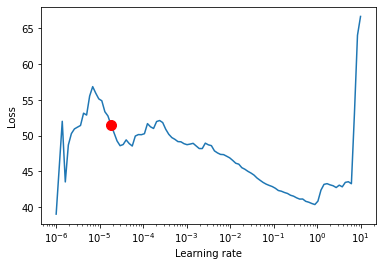

C:\Users\nmert\AppData\Local\Temp\ipykernel_36212\1637175533.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [12]:
# Find Optimal Learning Rate:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader = train_dataloader,
    val_dataloaders = val_dataloader,
    max_lr = 10.0,
    min_lr = 1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show = True, suggest = True)
fig.show()

#tft.hparams["learning_rate"] = res.suggestion() # Set the suggested learning rate

In [13]:
# Configure Logging and Trainier:
early_stop_callback = EarlyStopping(monitor = "val_loss", min_delta = 1e-4, 
                                    patience = 10, verbose = True, mode = "min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs", name = "tft", log_graph = True)  # logging results to a tensorboard

# tensorboard --logdir=lightning_logs, run this command to load tensorboard

trainer = pl.Trainer(
    max_epochs = 10,
    gpus = 1,
    weights_summary = "top",
    gradient_clip_val = 0.03,
    #limit_train_batches = 24,  # Commet during training
    #fast_dev_run = True,
    callbacks = [lr_logger, early_stop_callback],
    logger = logger
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
# Fit Model:
trainer.fit(
    tft,
    train_dataloader = train_dataloader,
    val_dataloaders = val_dataloader,
)

c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\loggers\tensorboard.py:247: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  rank_zero_warn(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList              

Global seed set to 43


Epoch 0:   3%|▎         | 277/9264 [02:58<1:36:29,  1.55it/s, loss=30.2, v_num=4, train_loss_step=29.50]

In [ ]:
# Load best model:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

In [ ]:
rmse = torch.round(((predictions - actuals)**2).mean(dim = 1).sqrt(), decimals = 2)

In [ ]:
rmse.mean()

tensor(33.3108)

In [ ]:
n = actuals.shape[0]
buildings = val.building_id.unique()

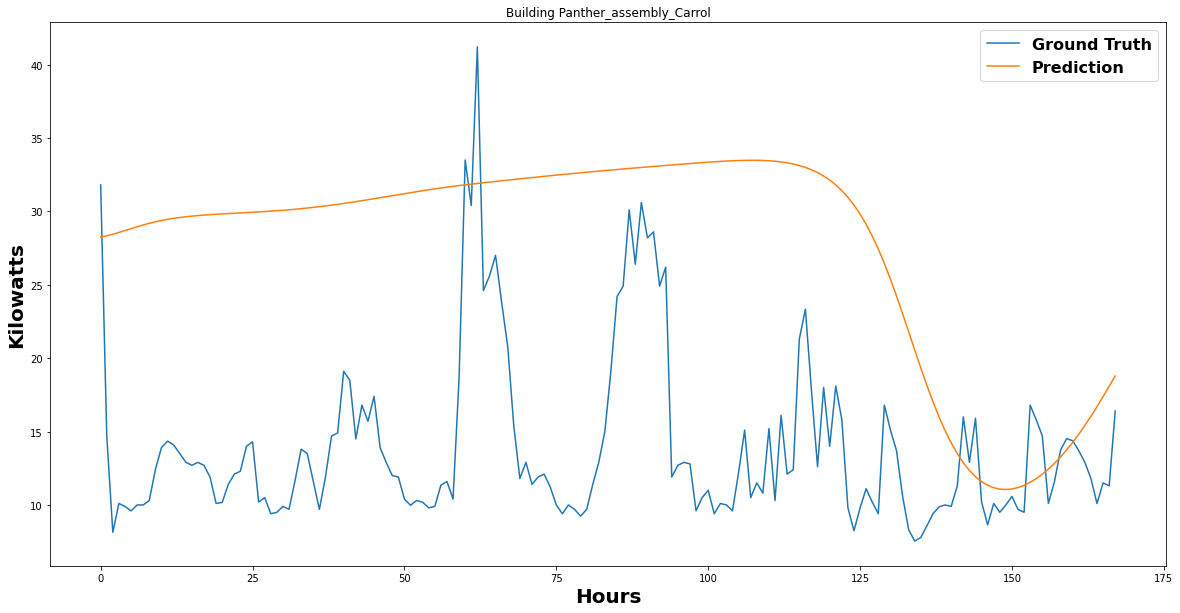

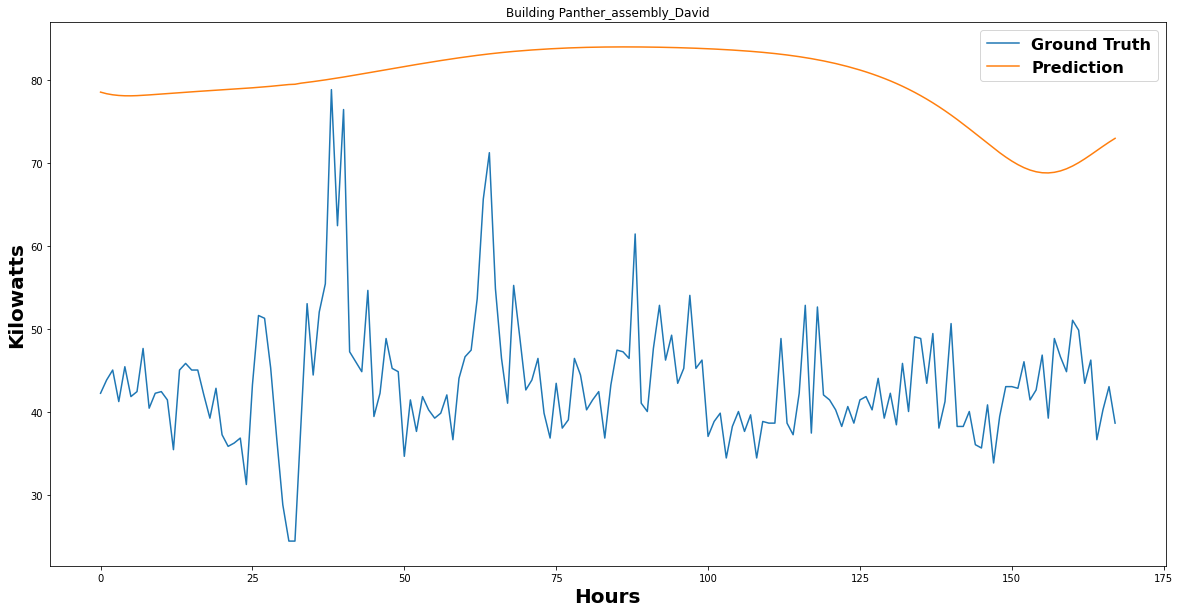

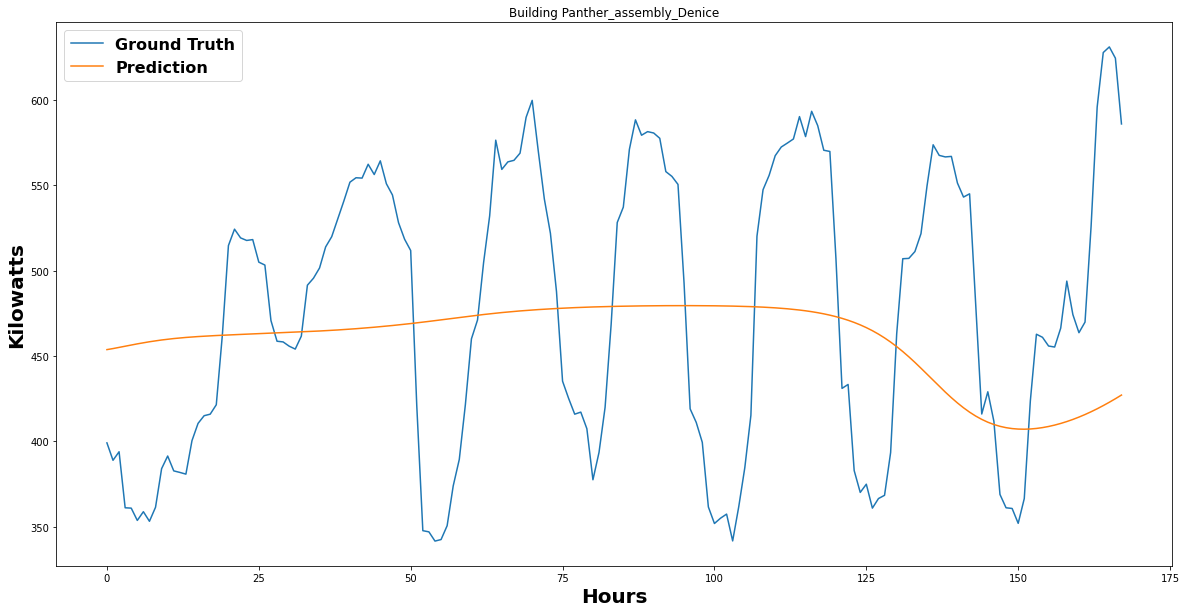

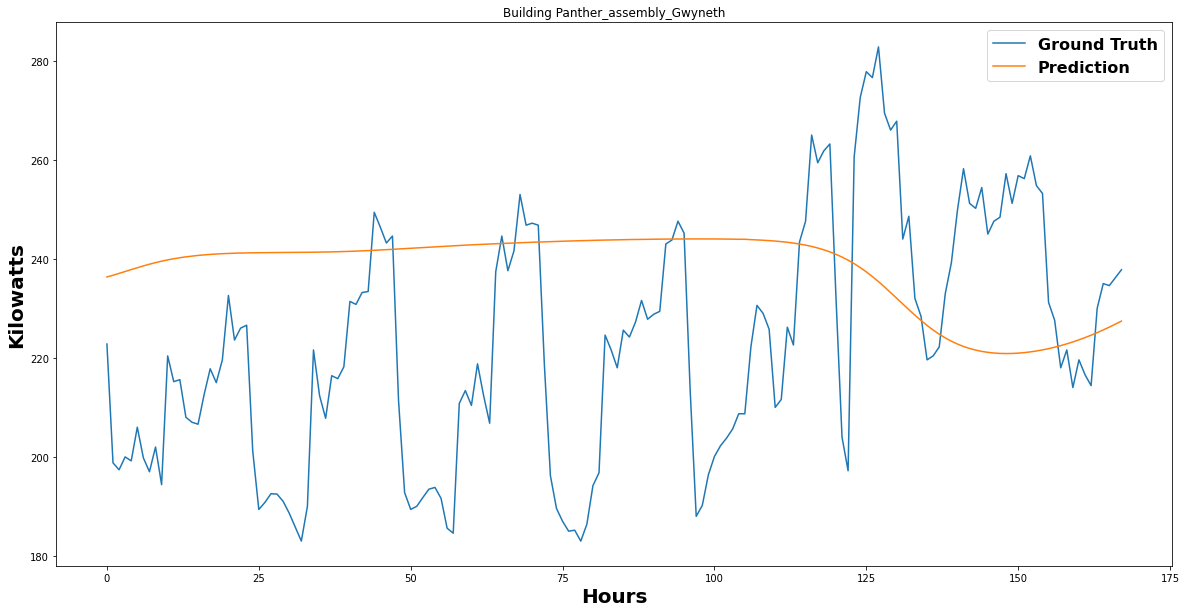

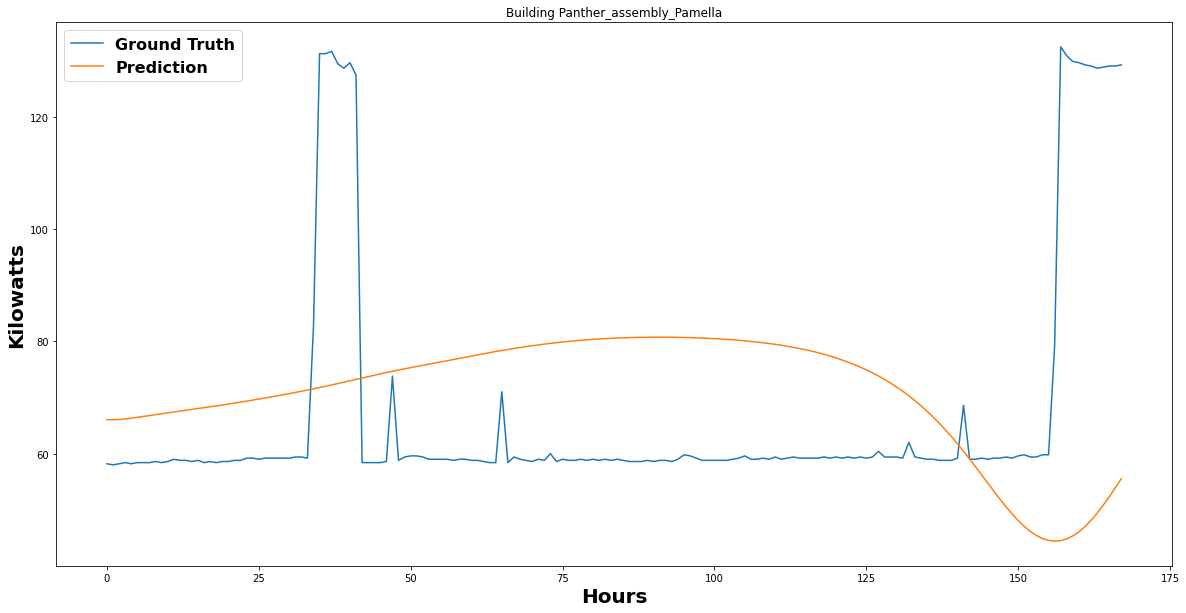

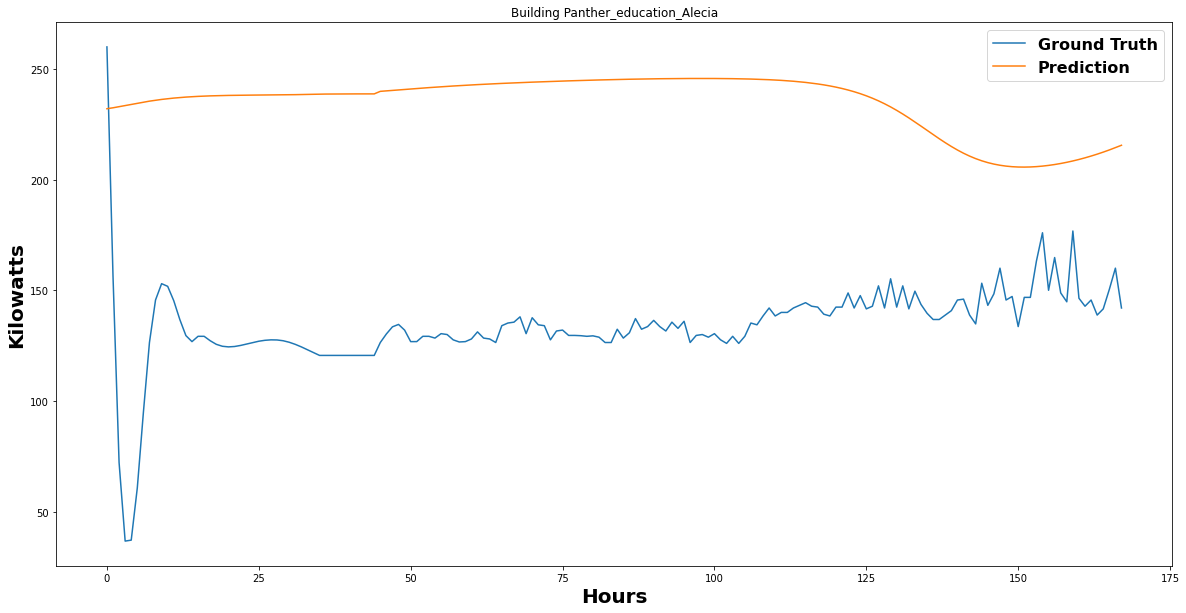

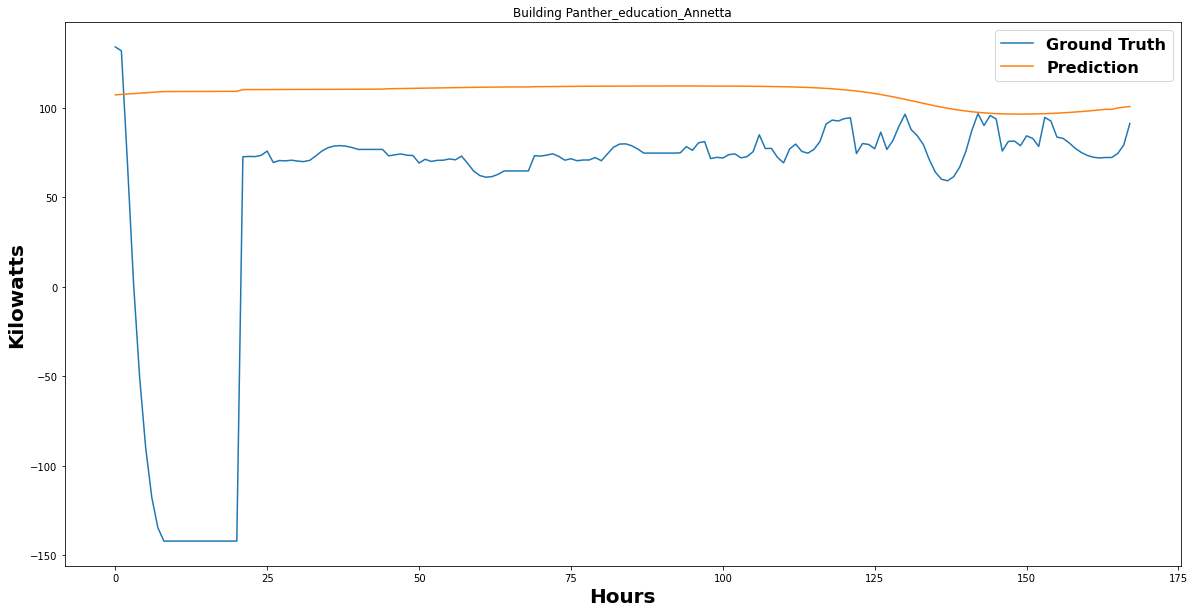

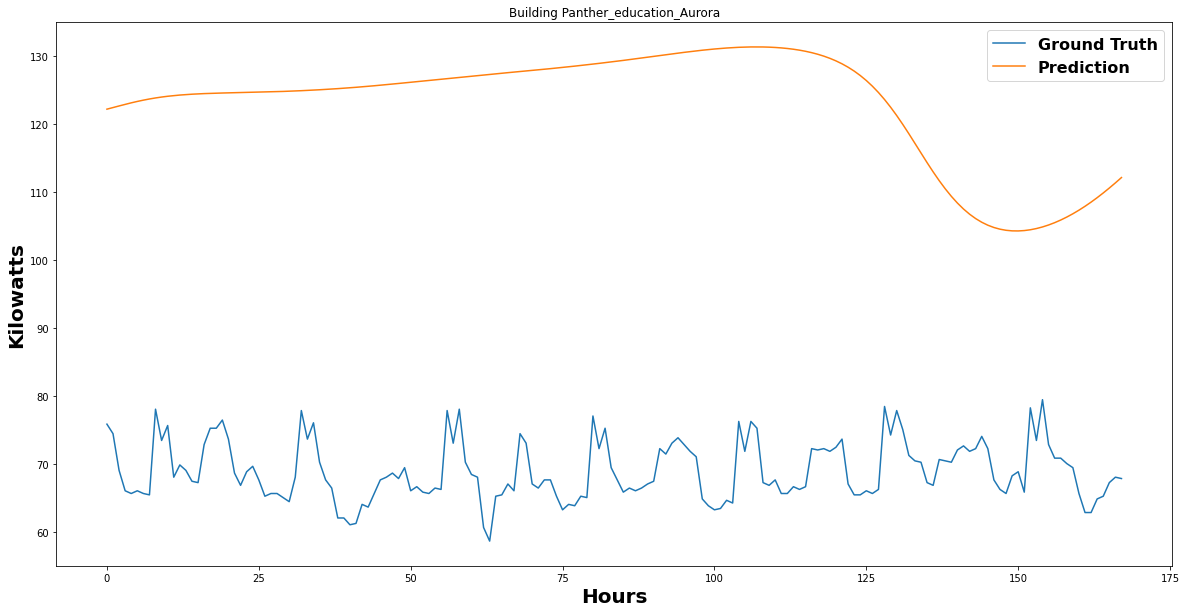

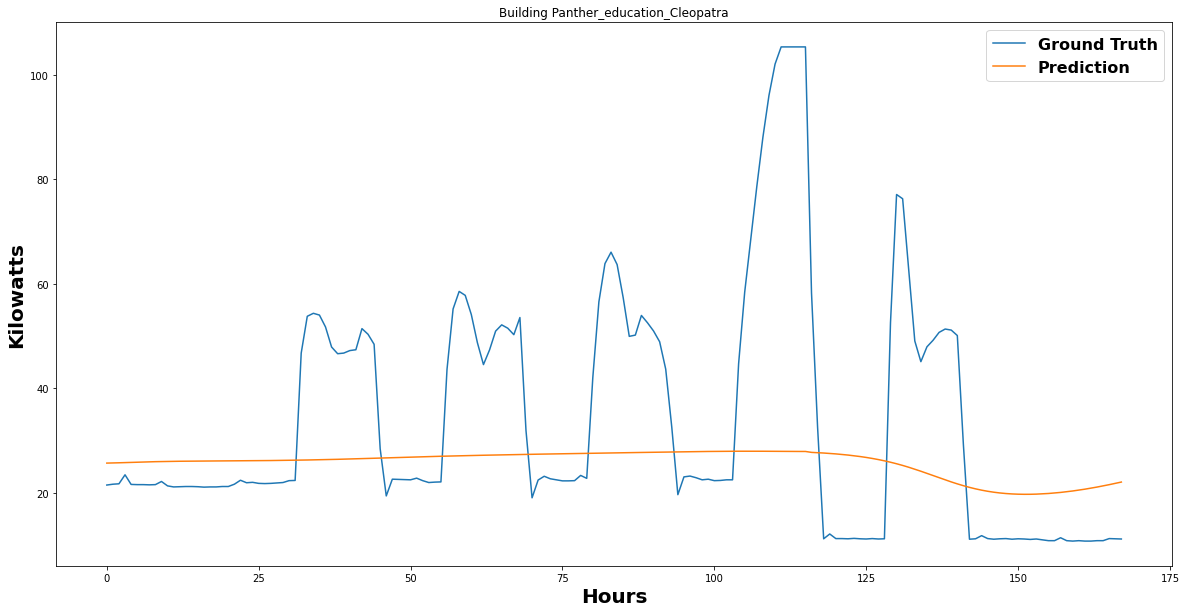

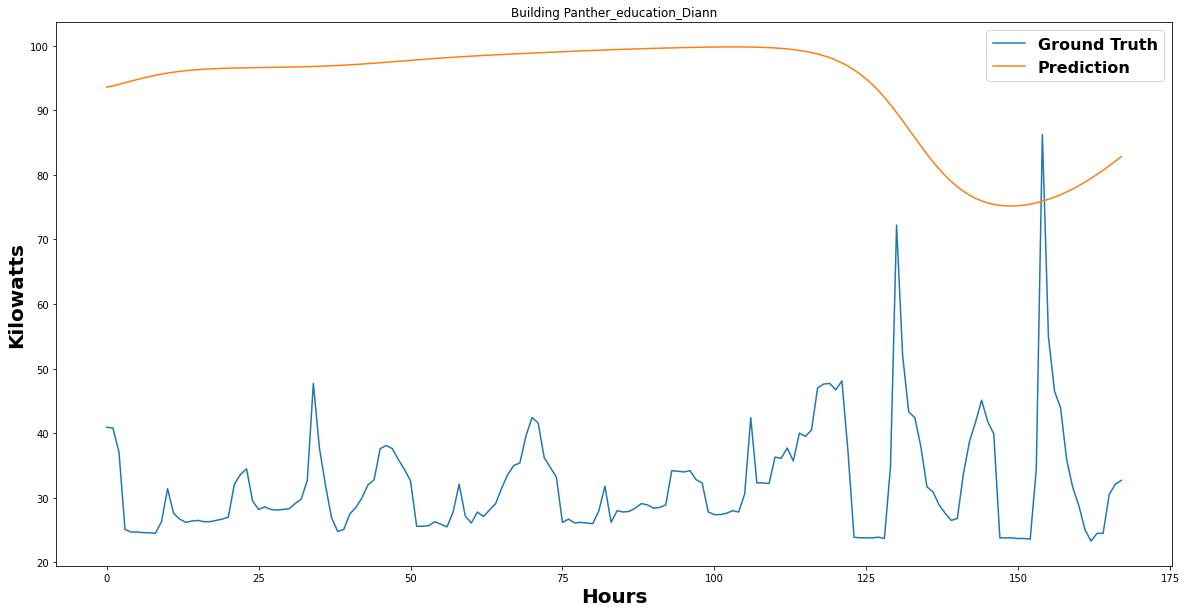

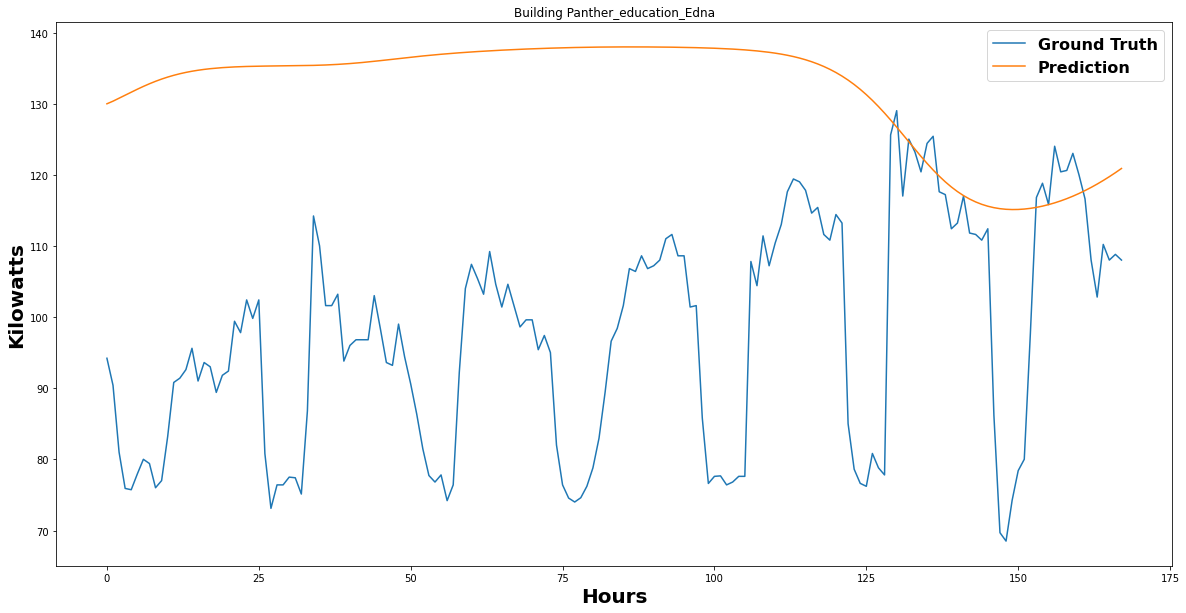

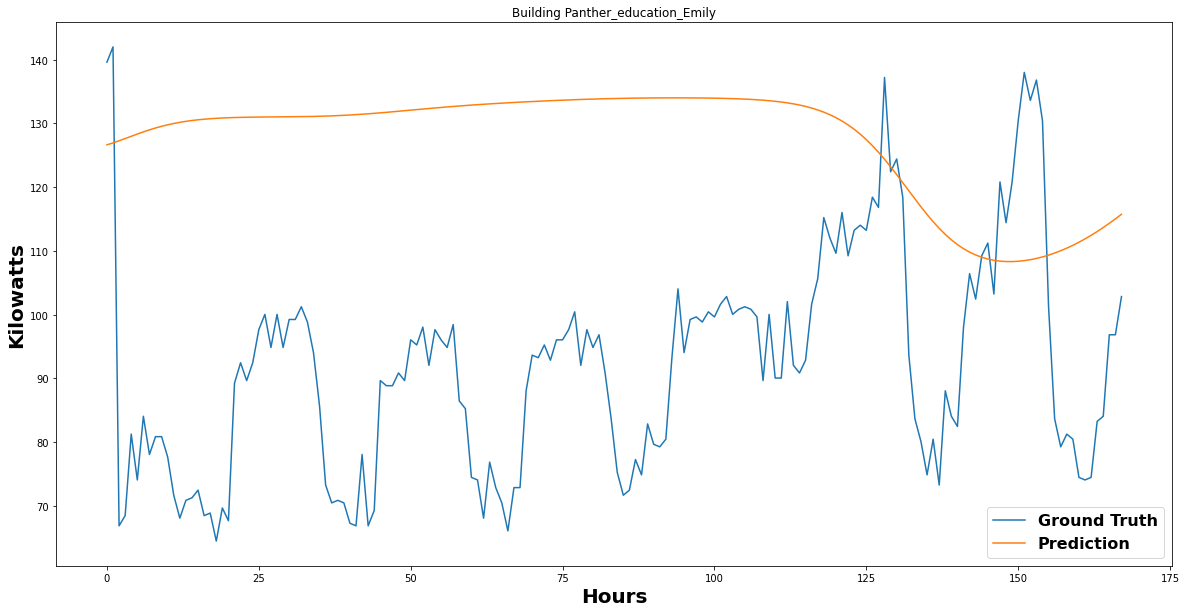

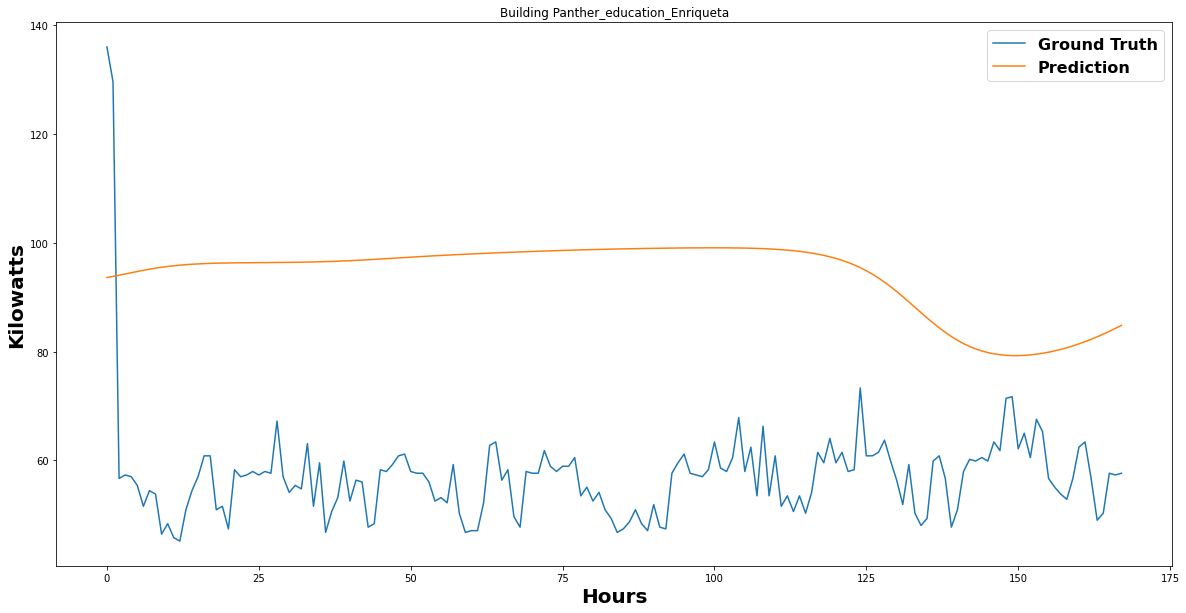

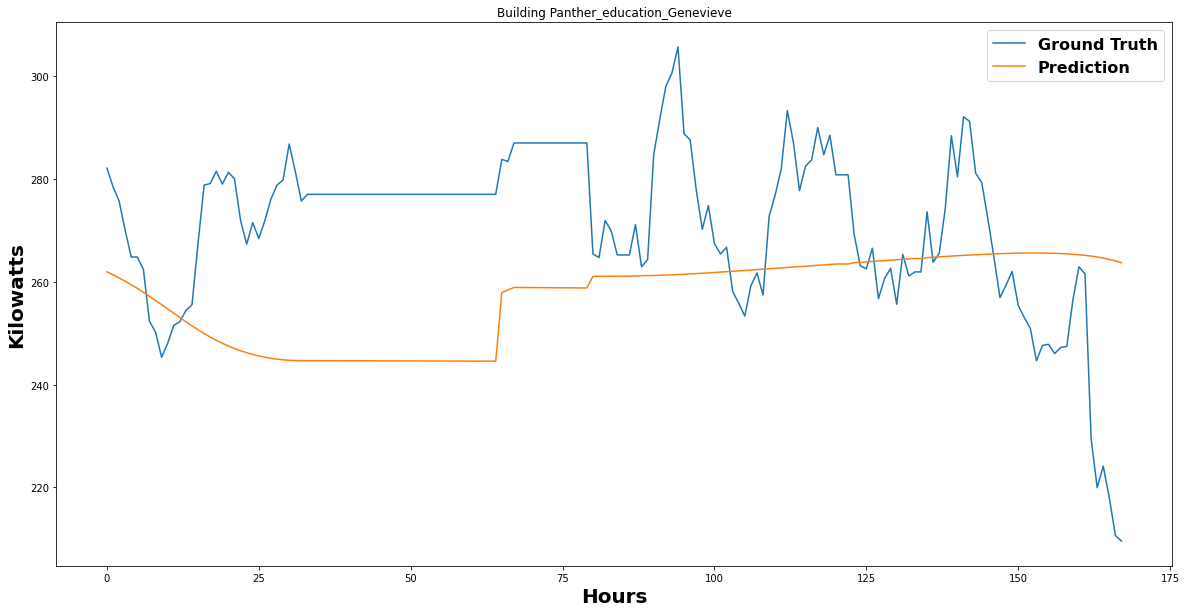

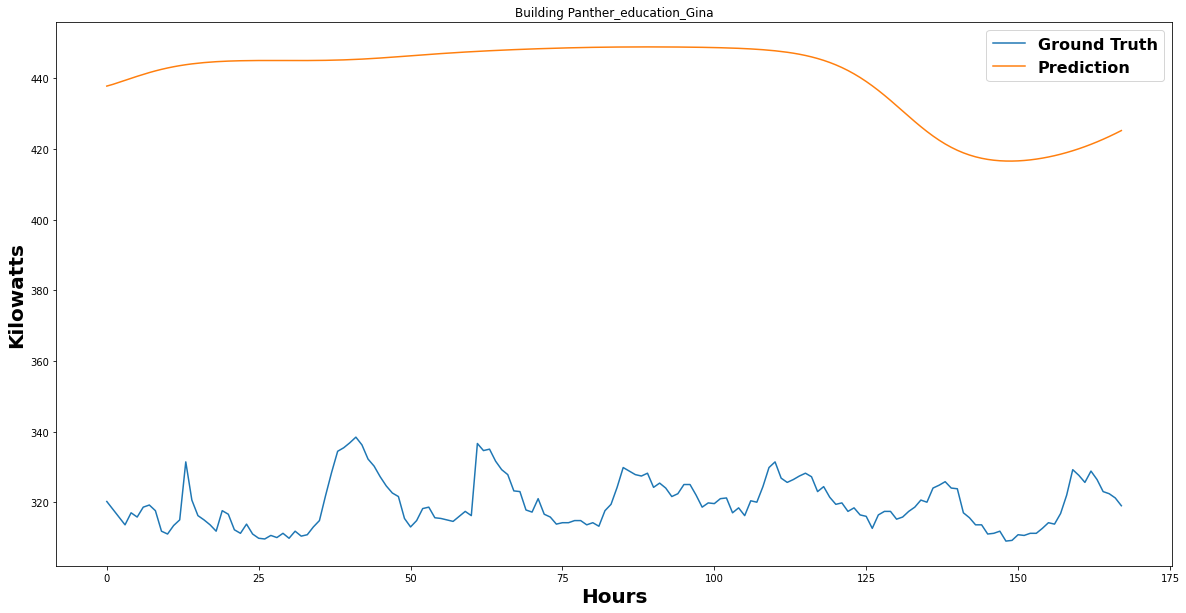

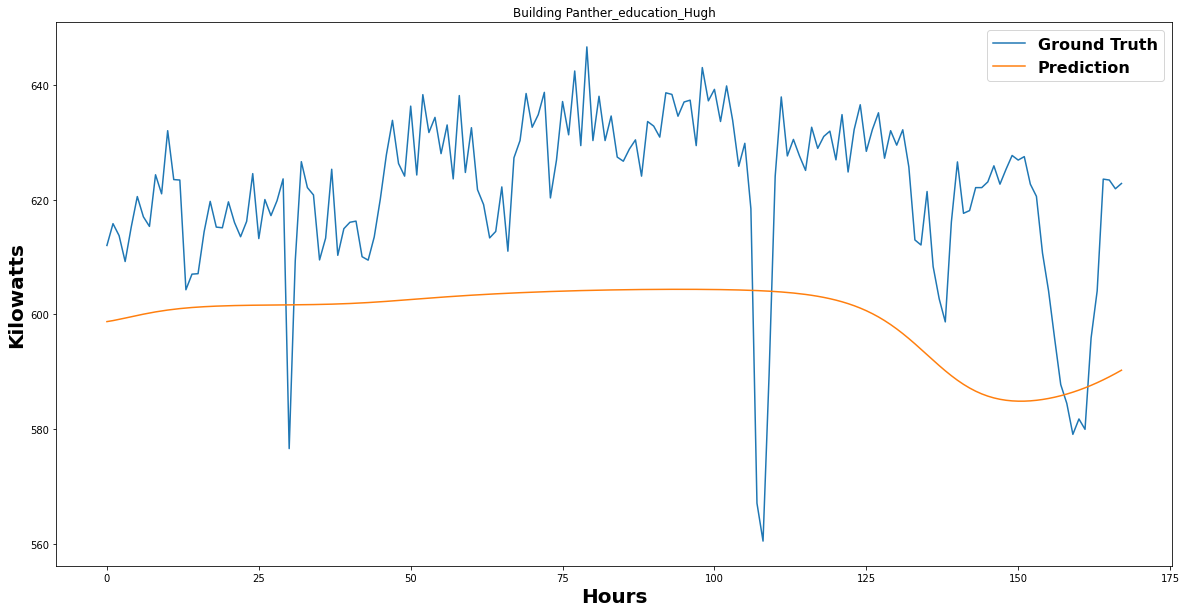

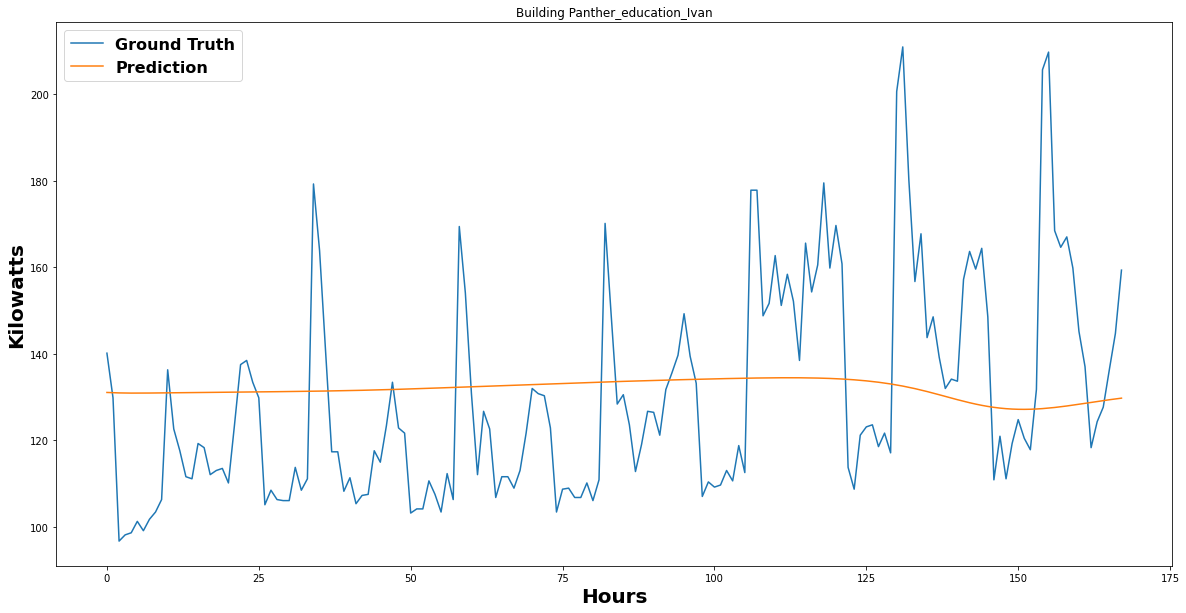

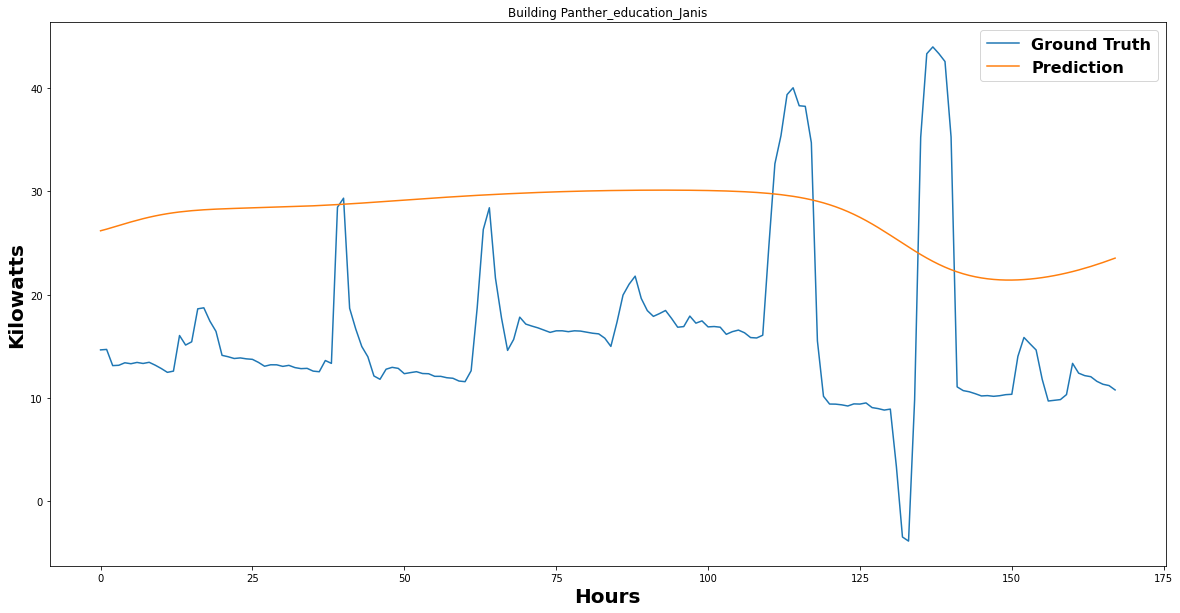

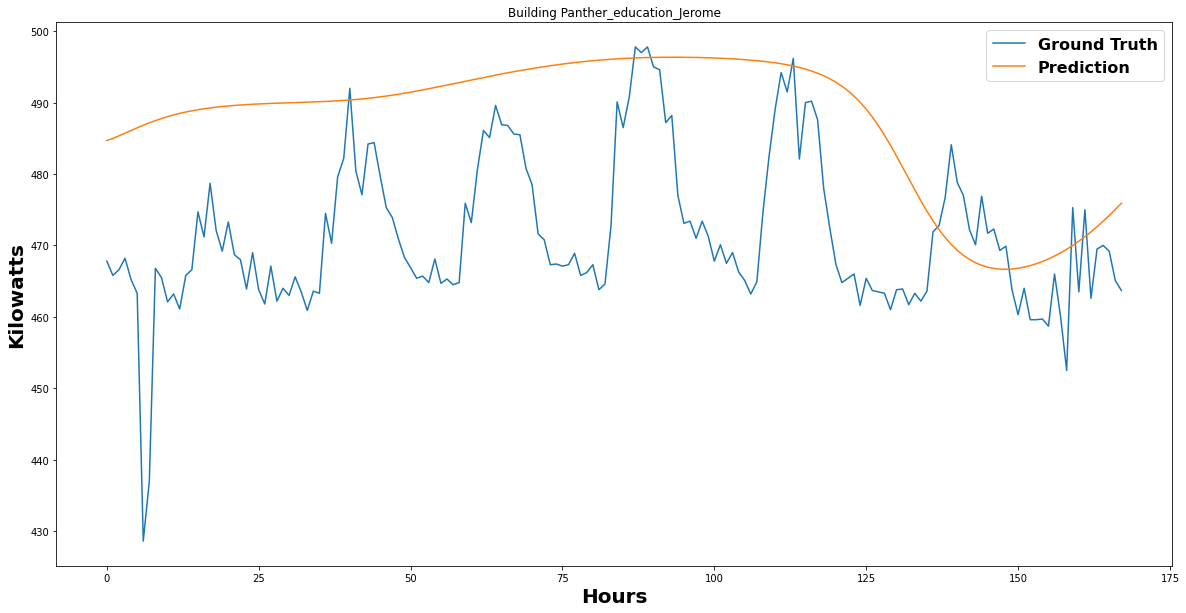

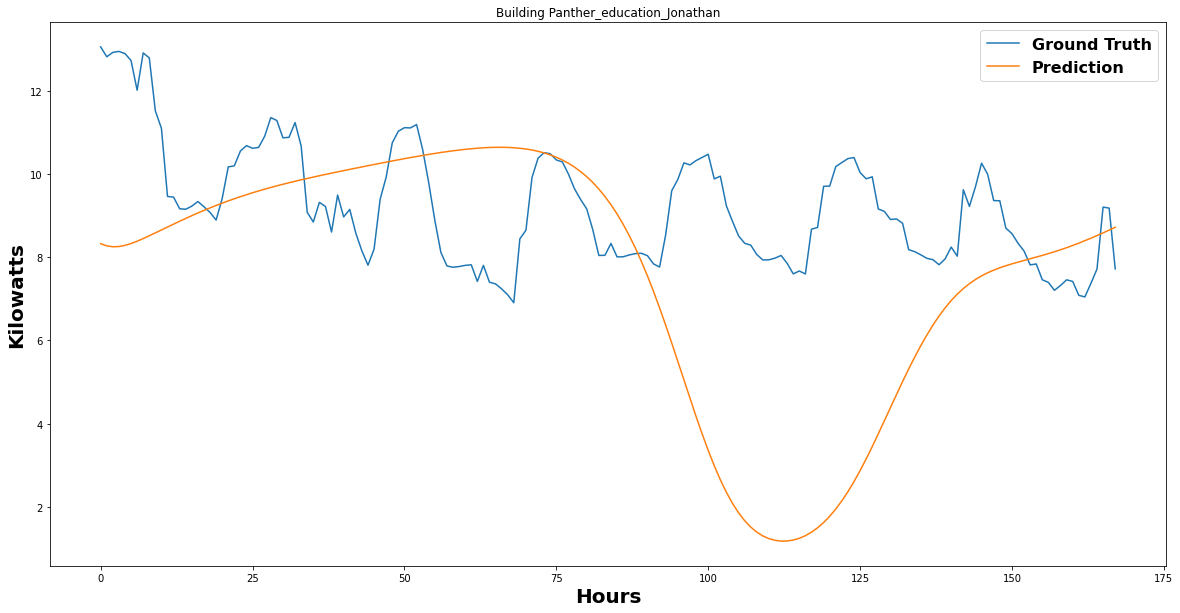

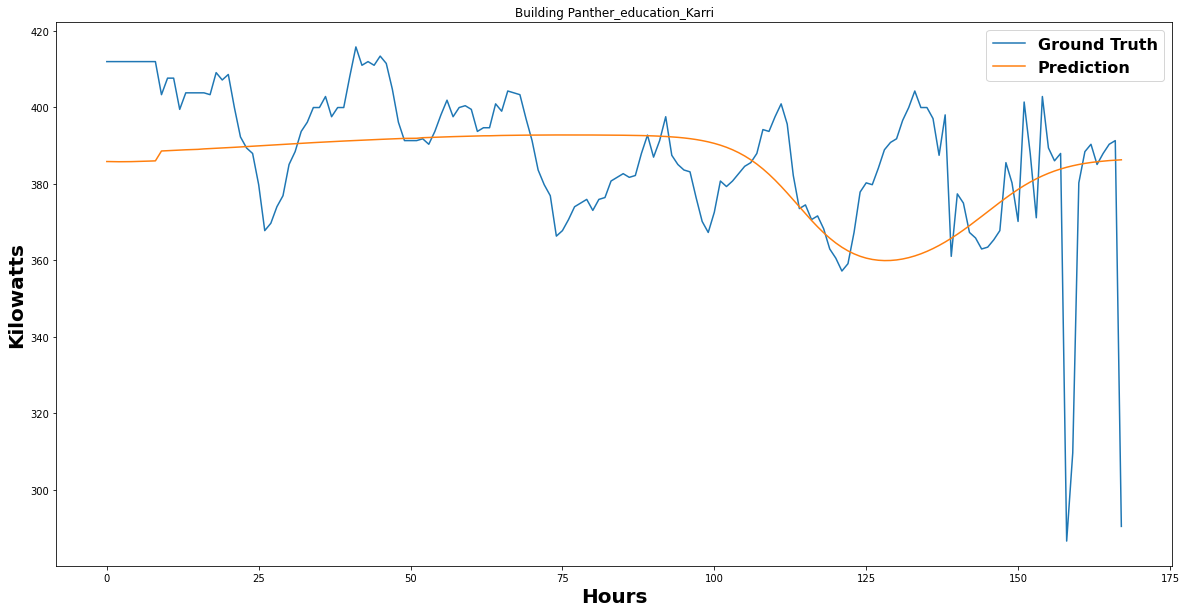

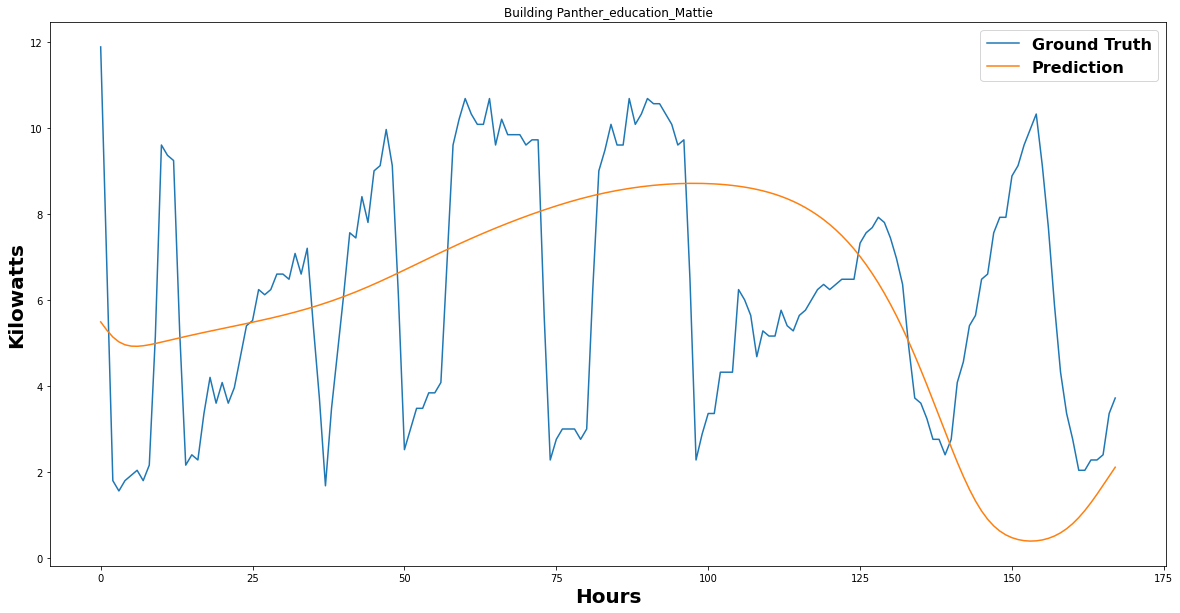

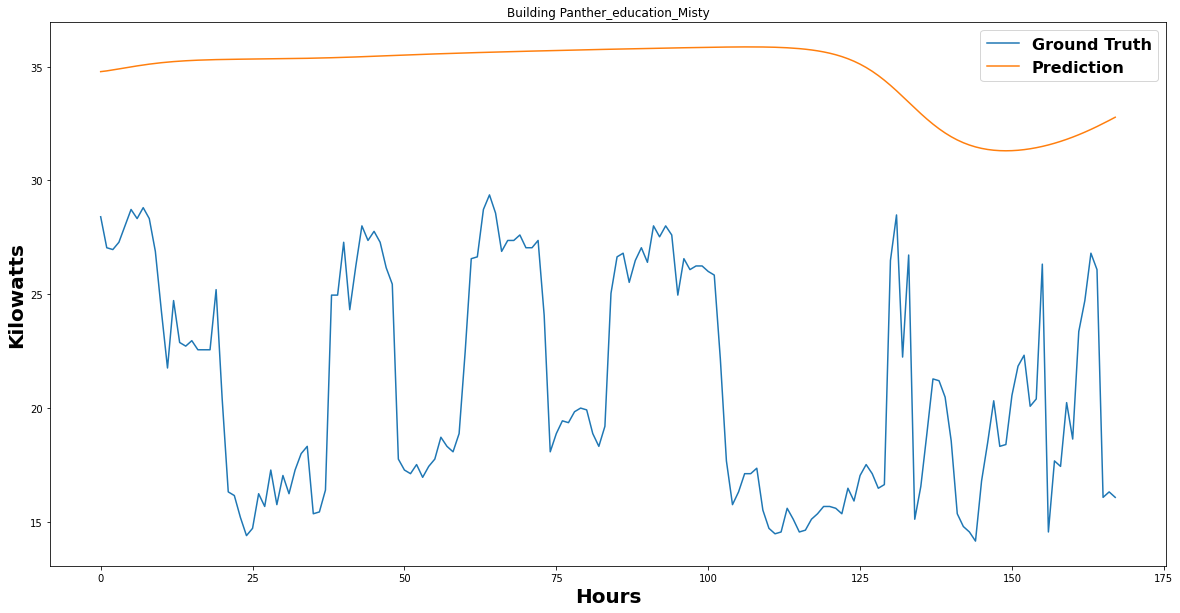

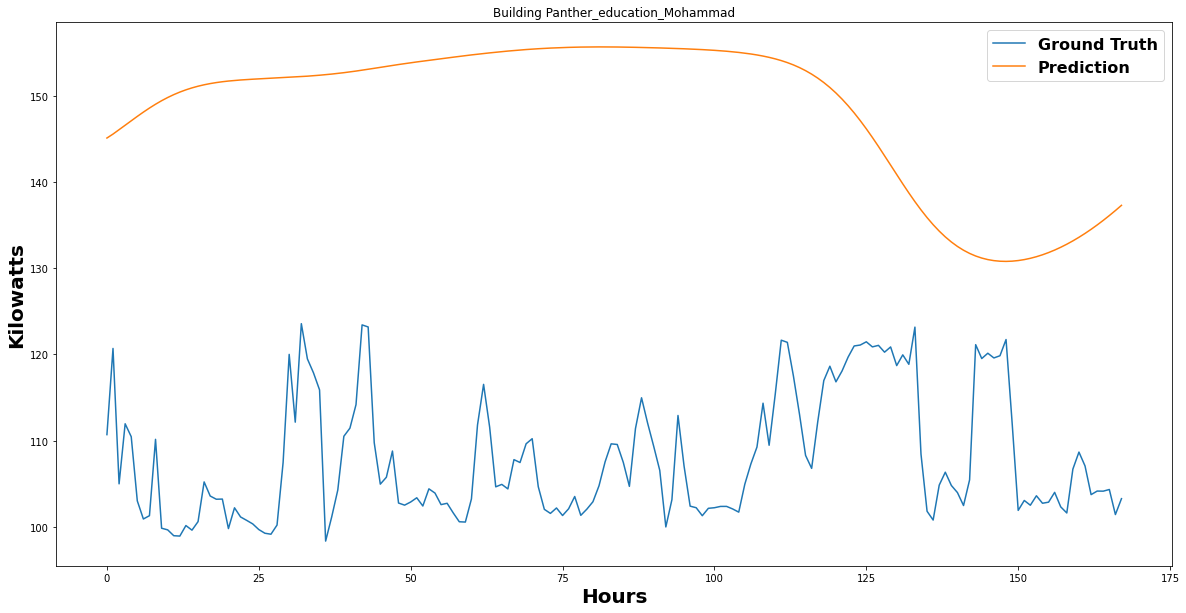

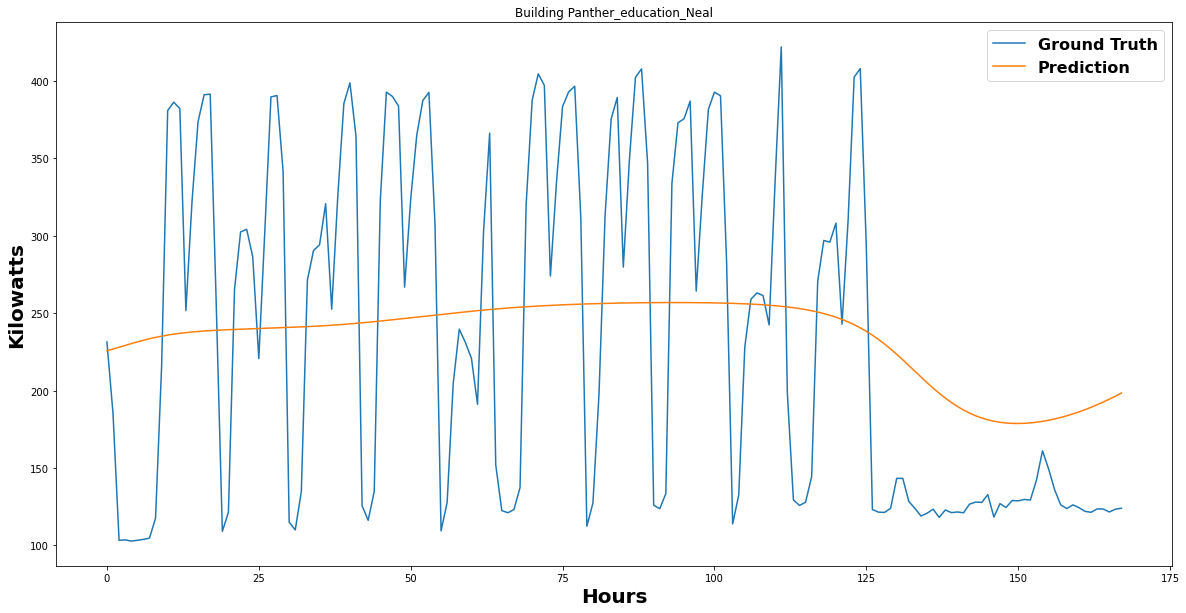

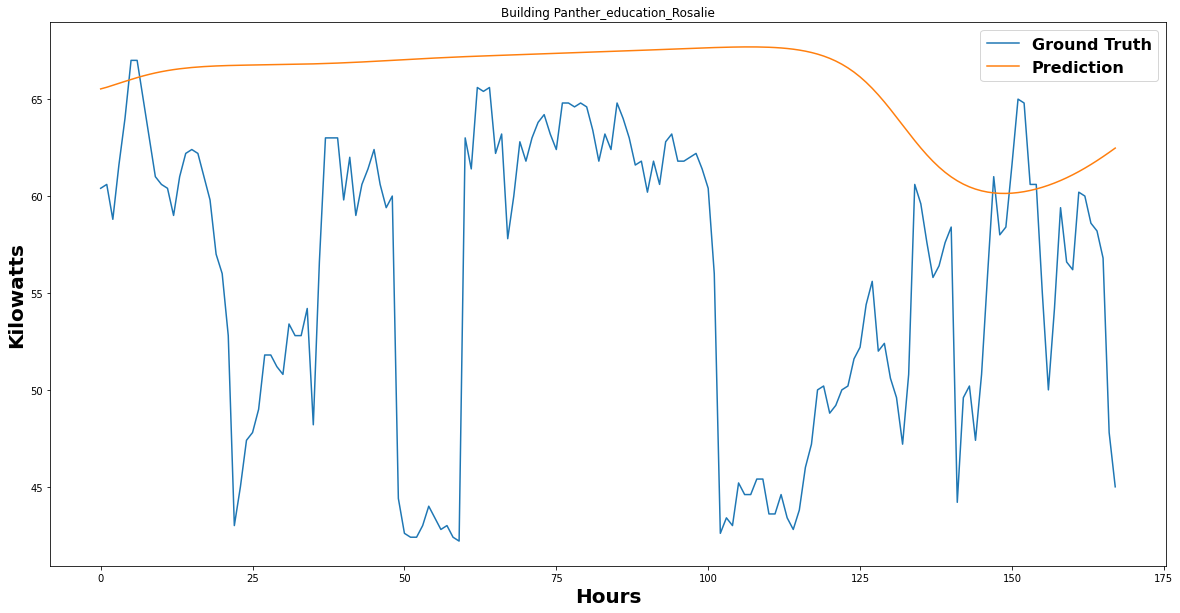

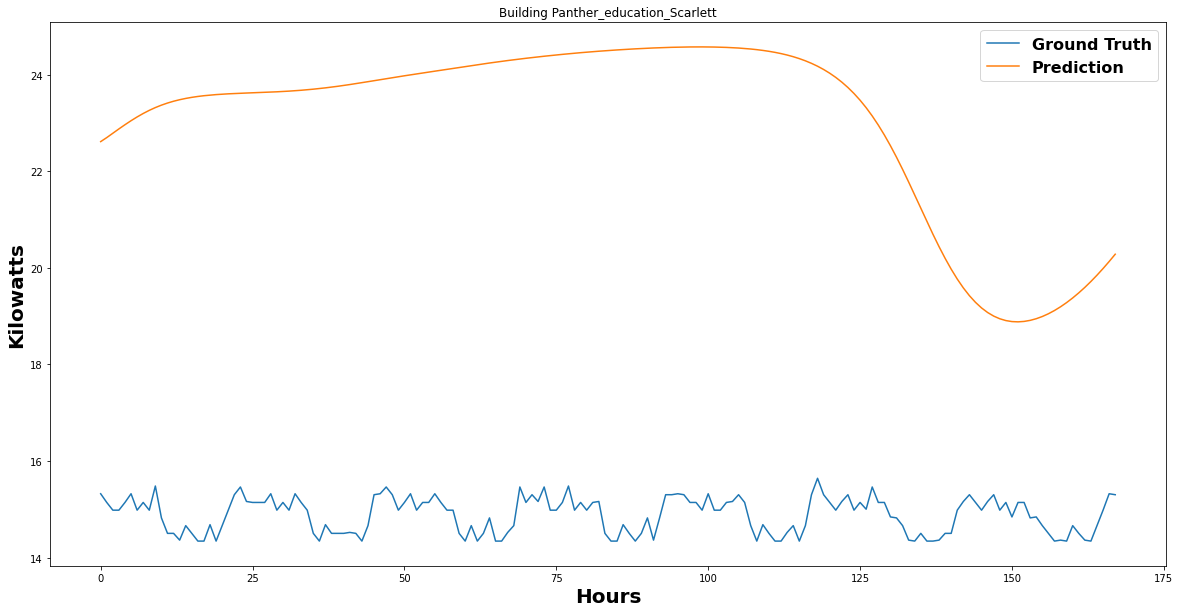

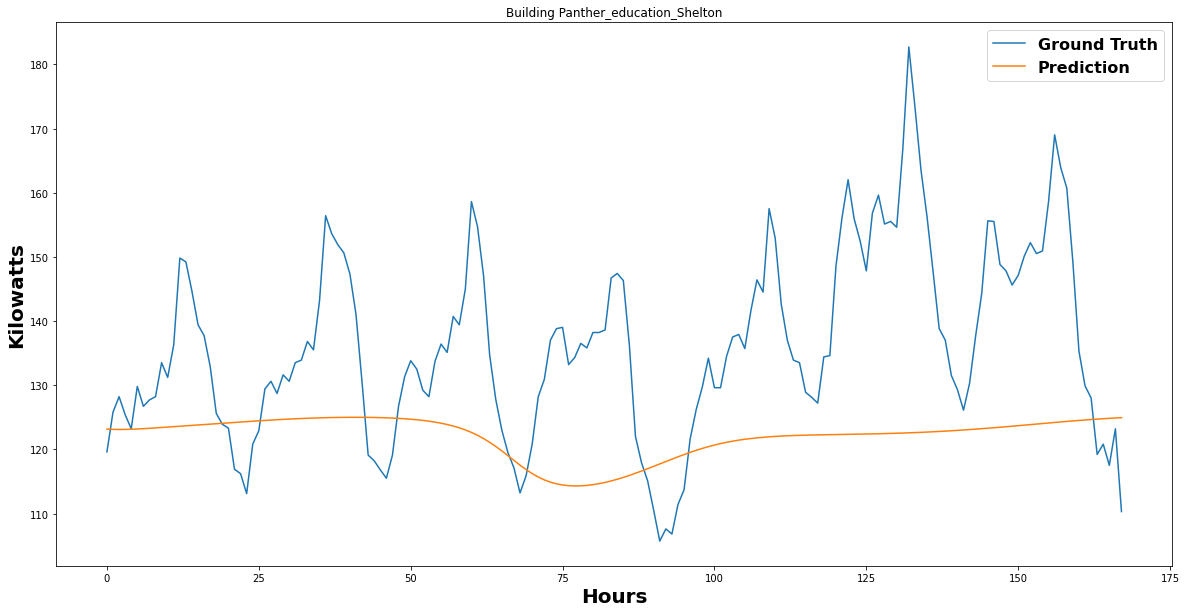

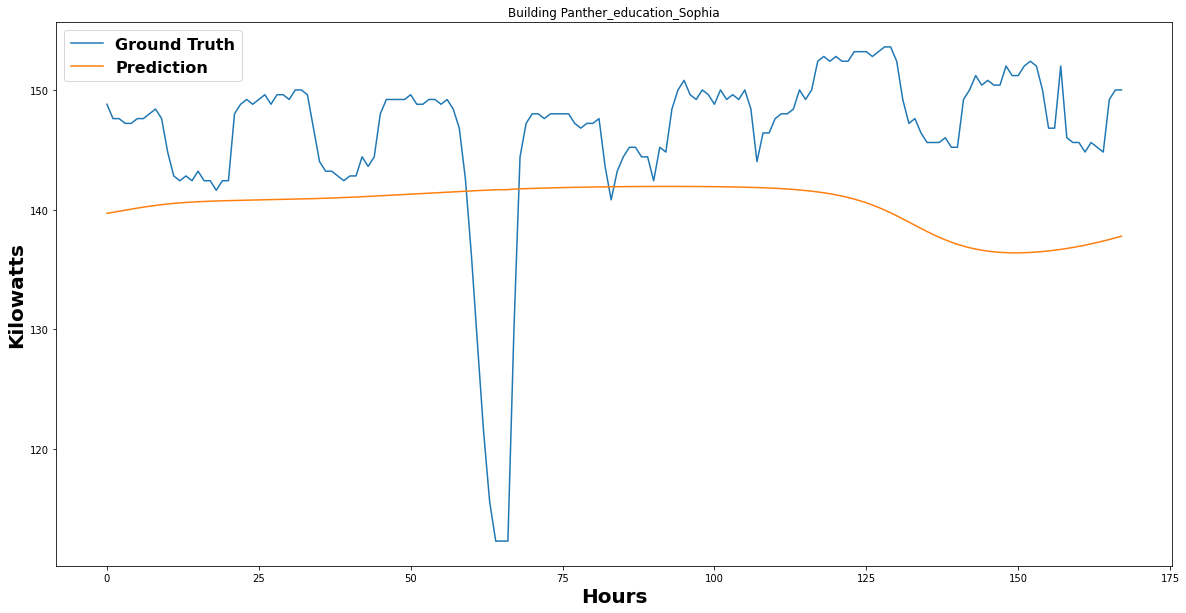

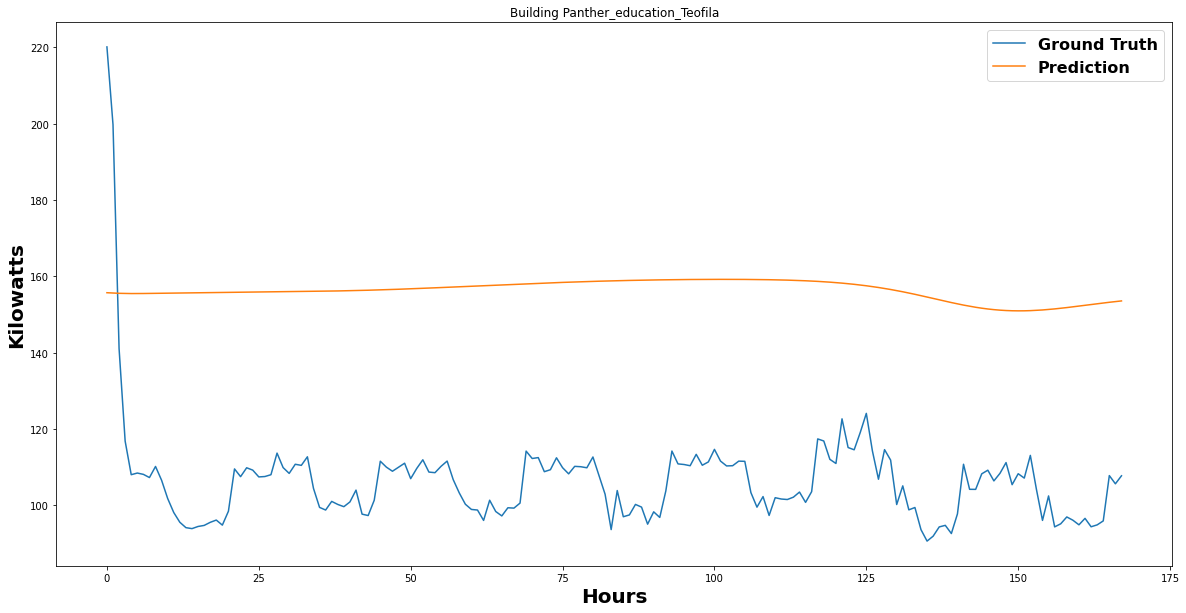

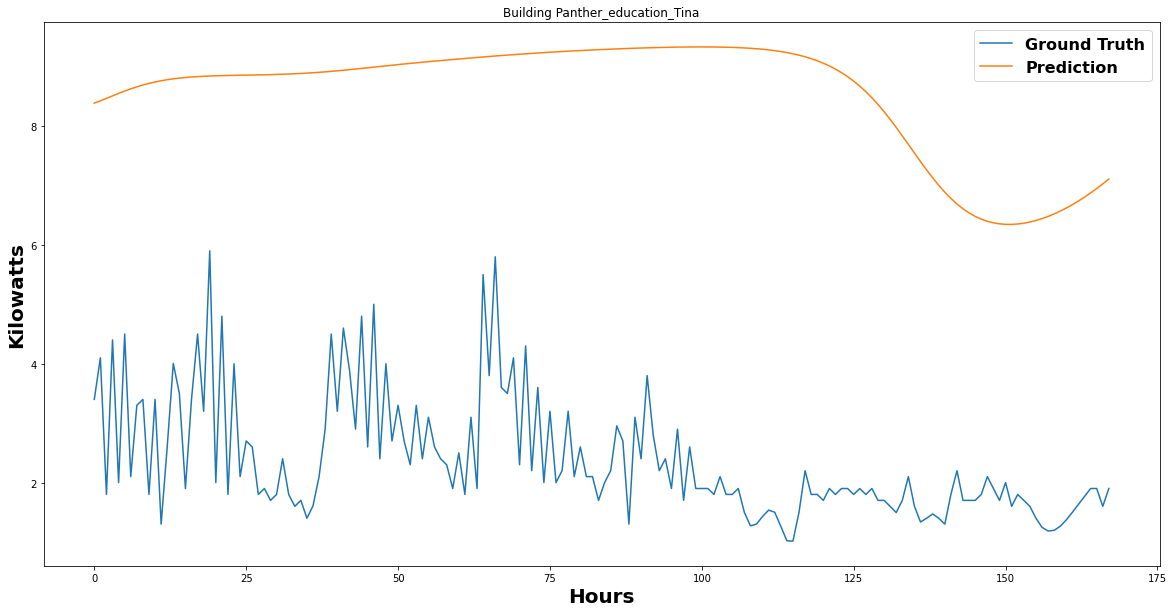

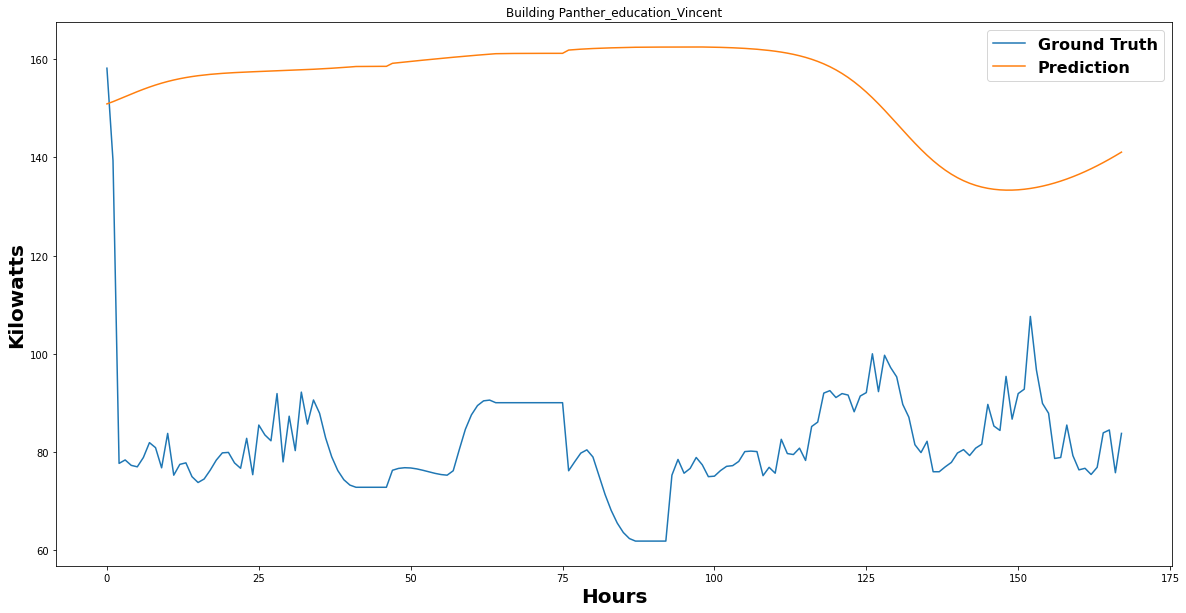

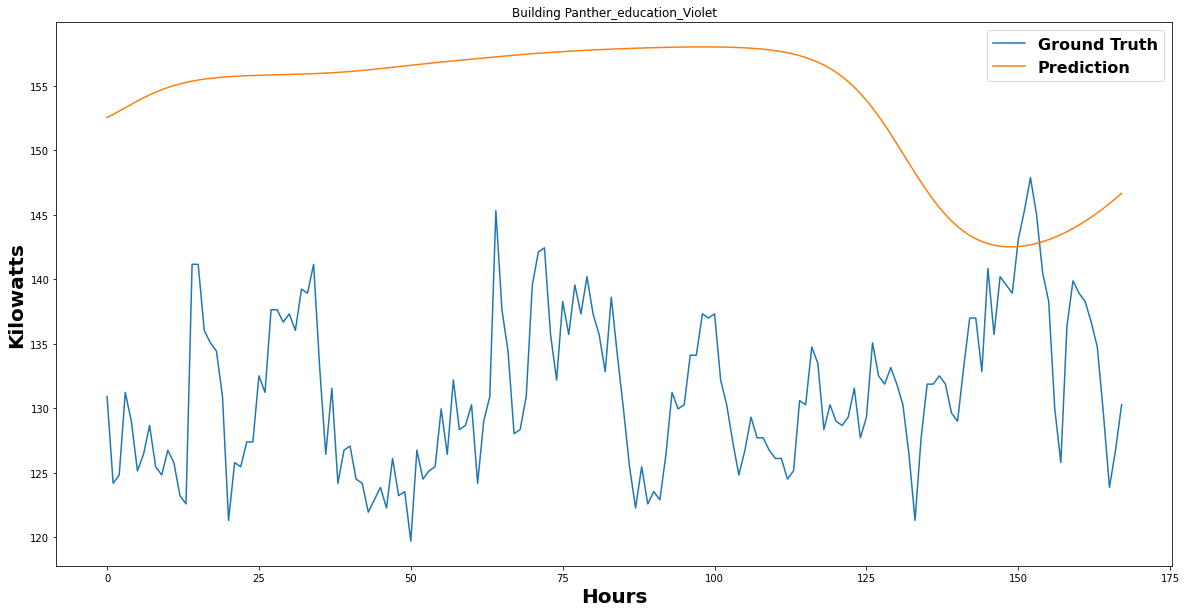

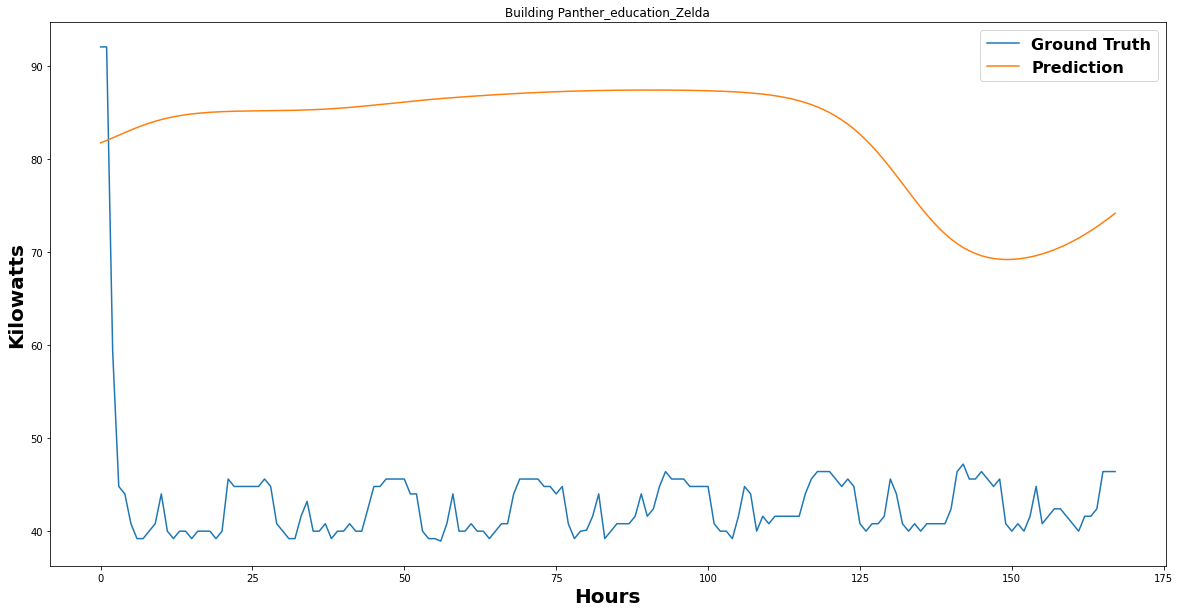

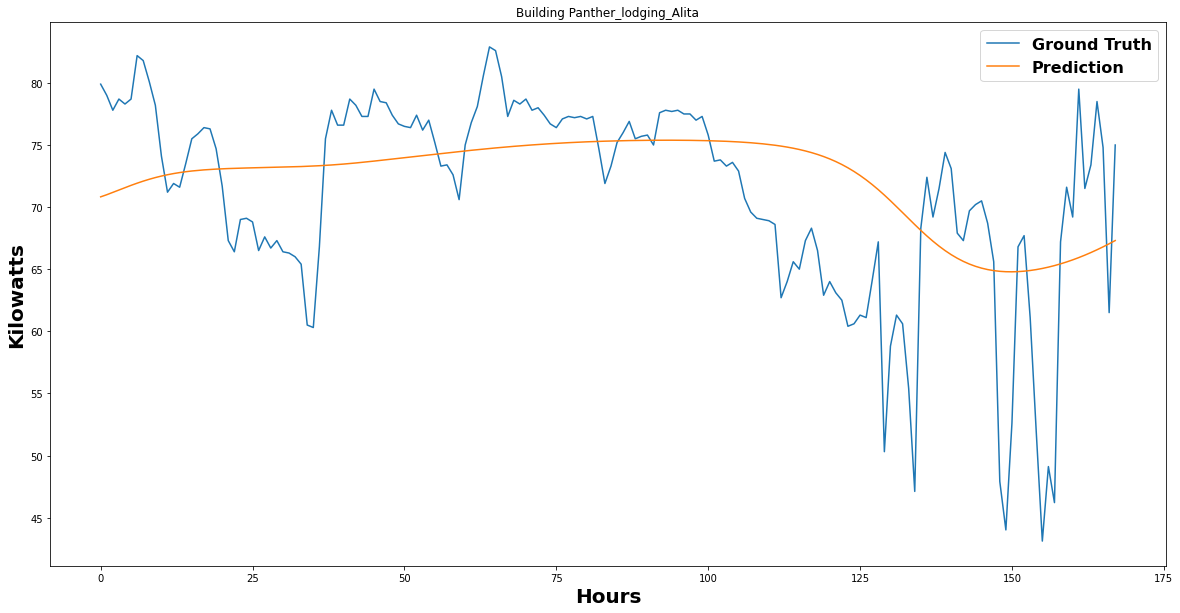

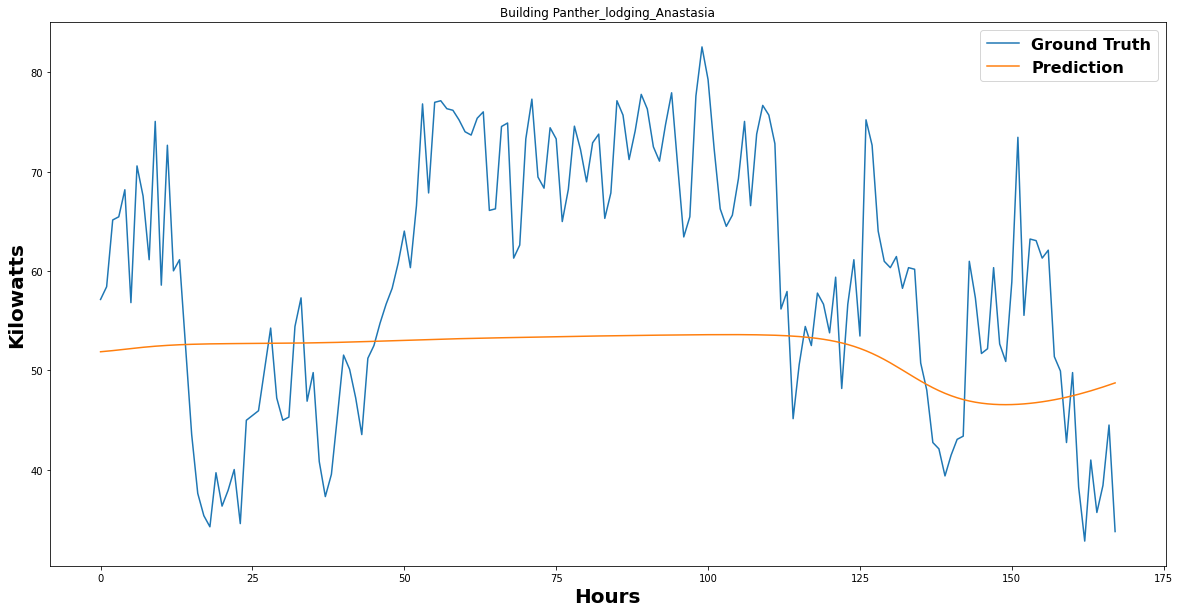

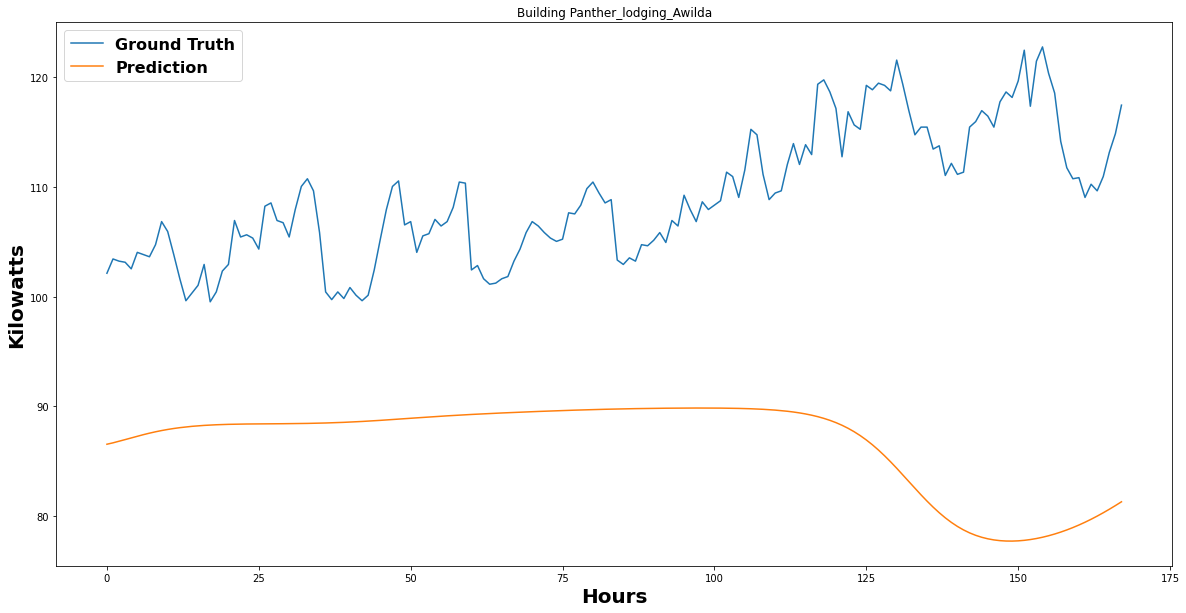

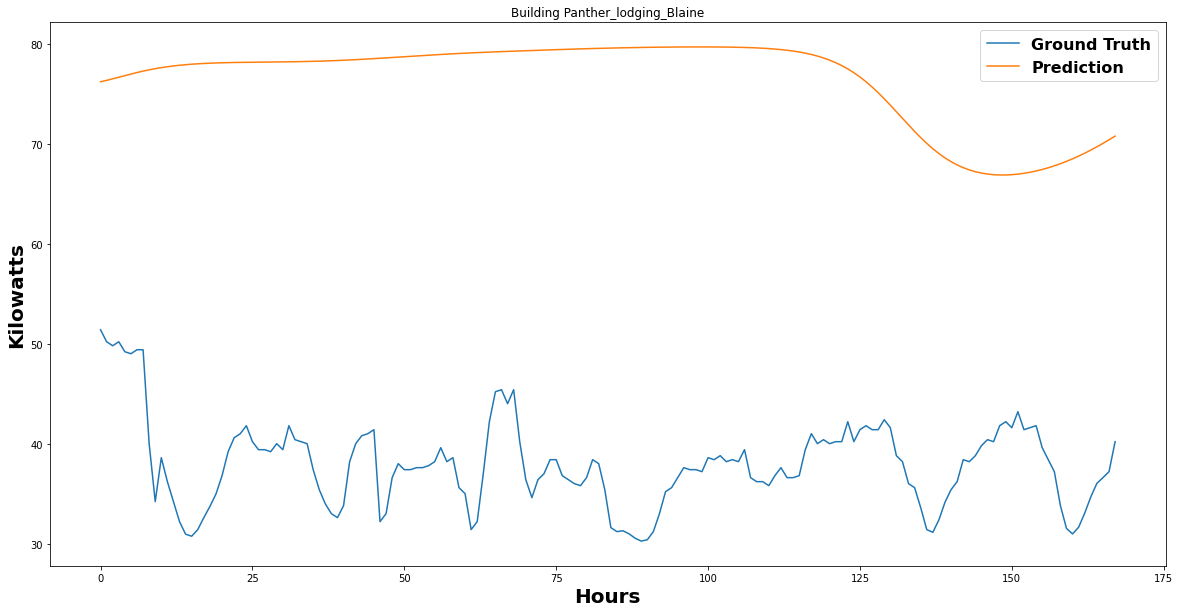

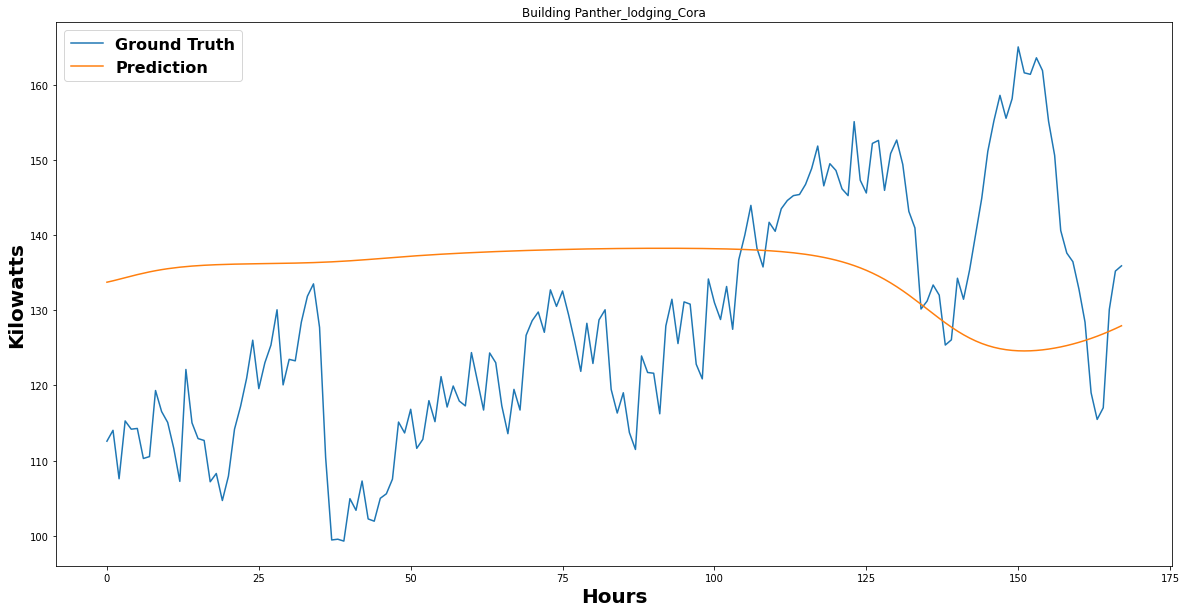

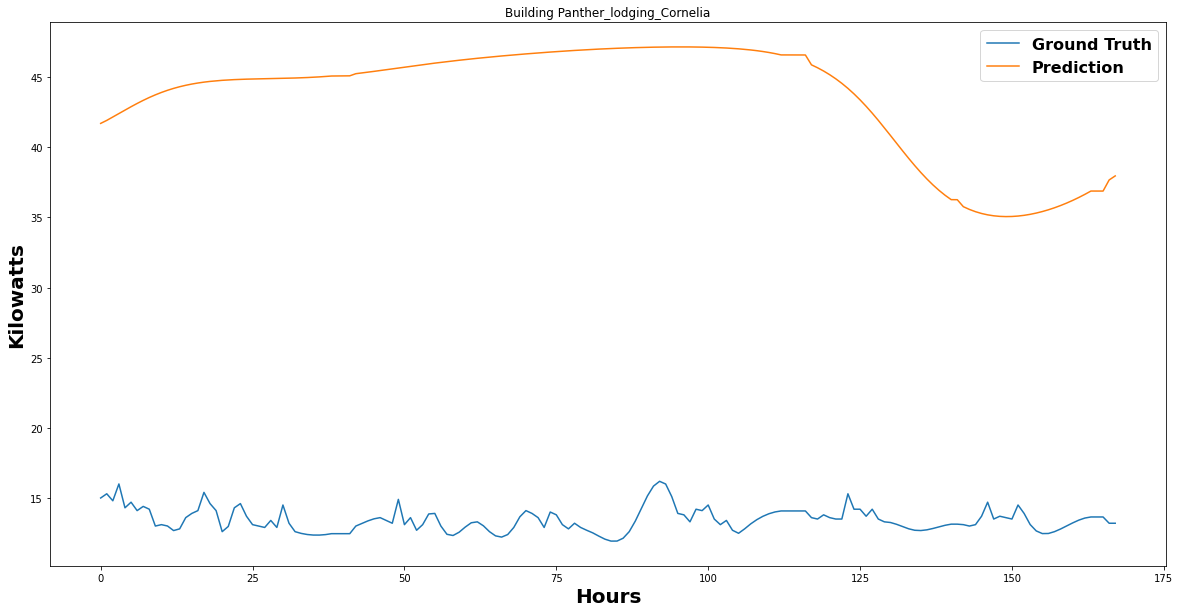

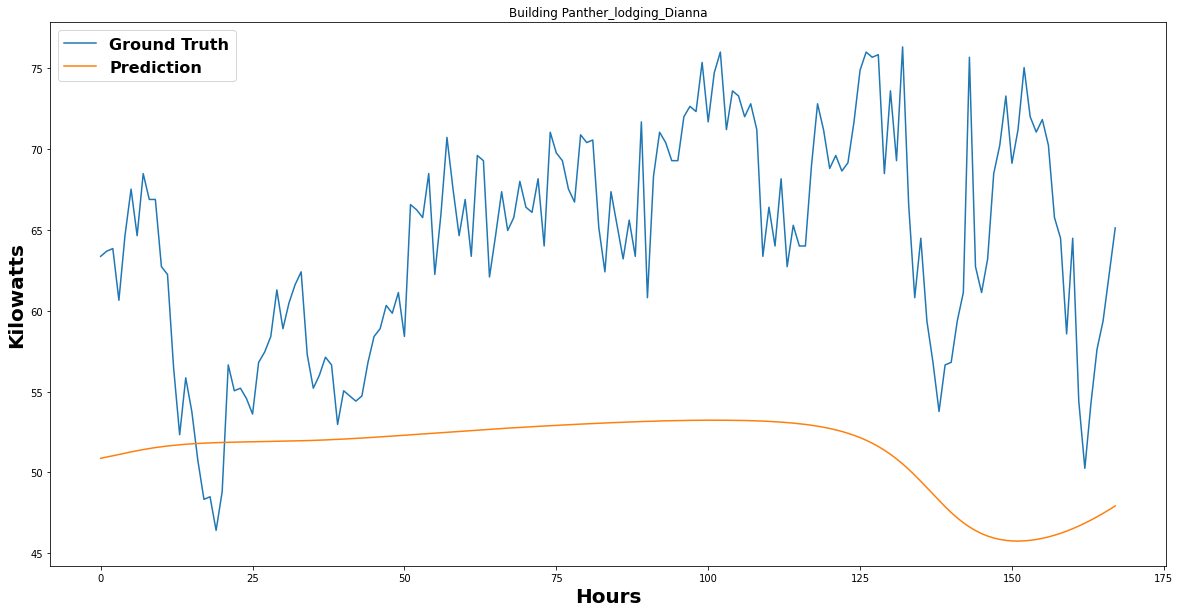

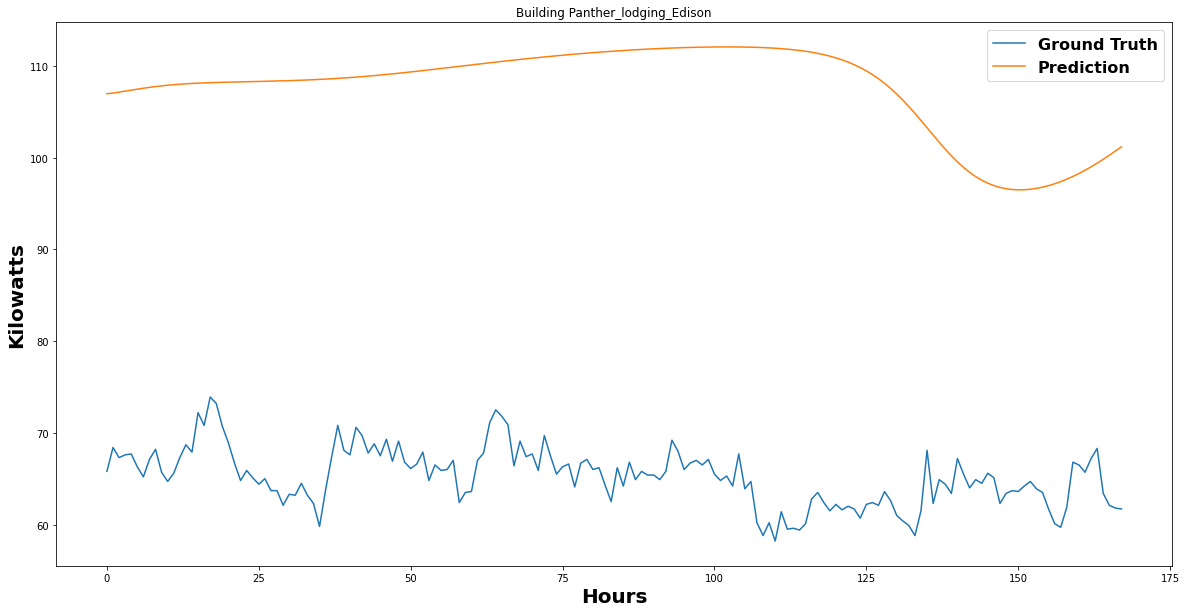

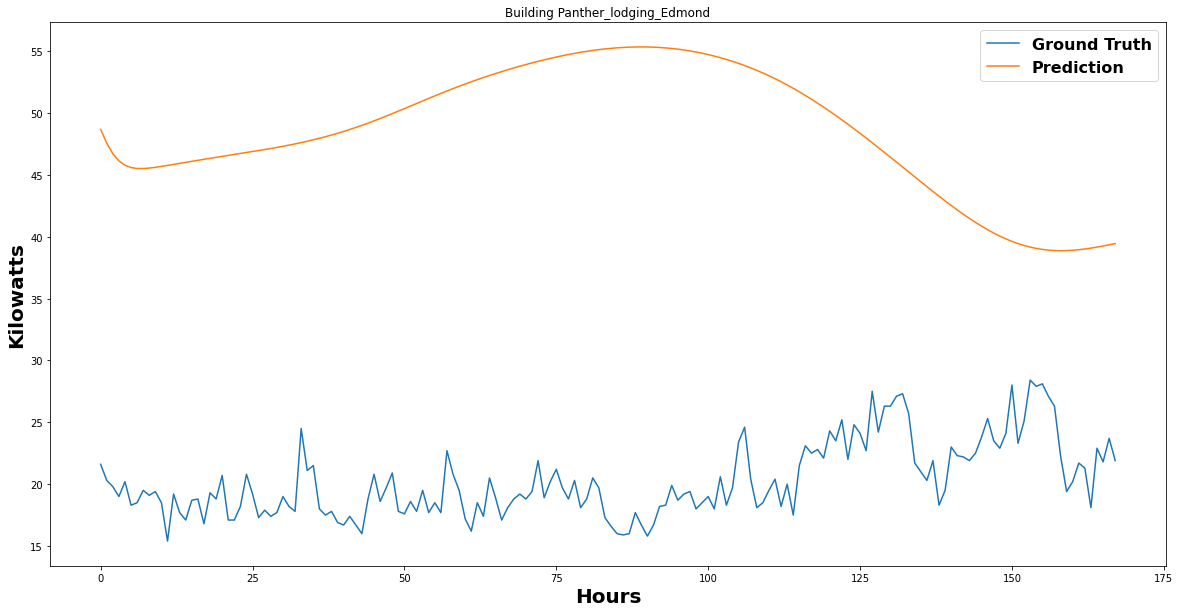

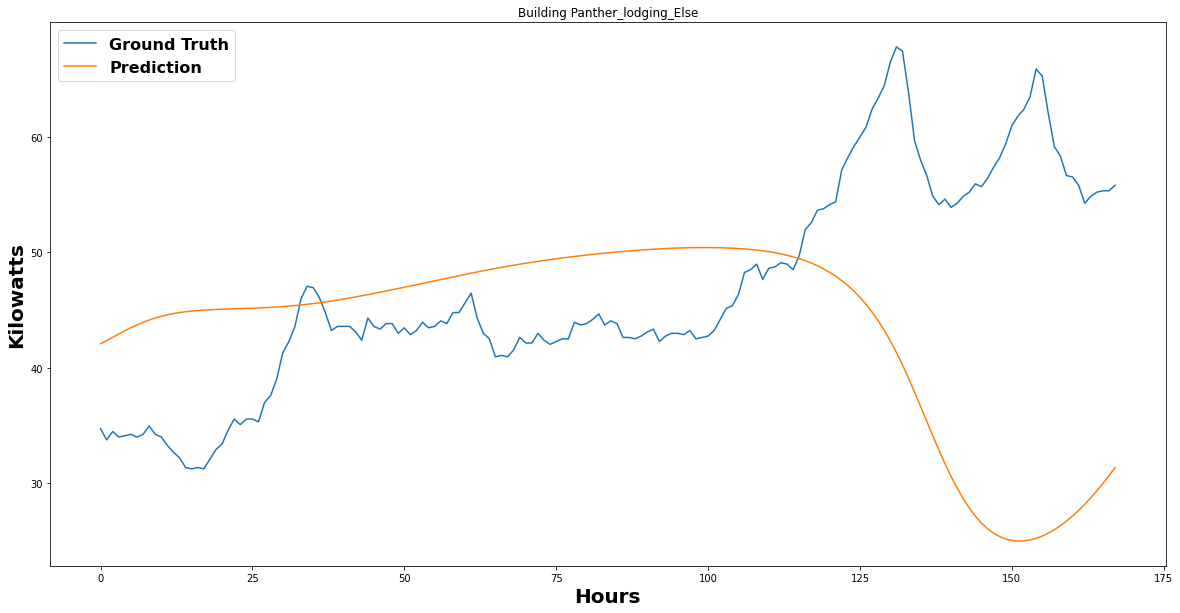

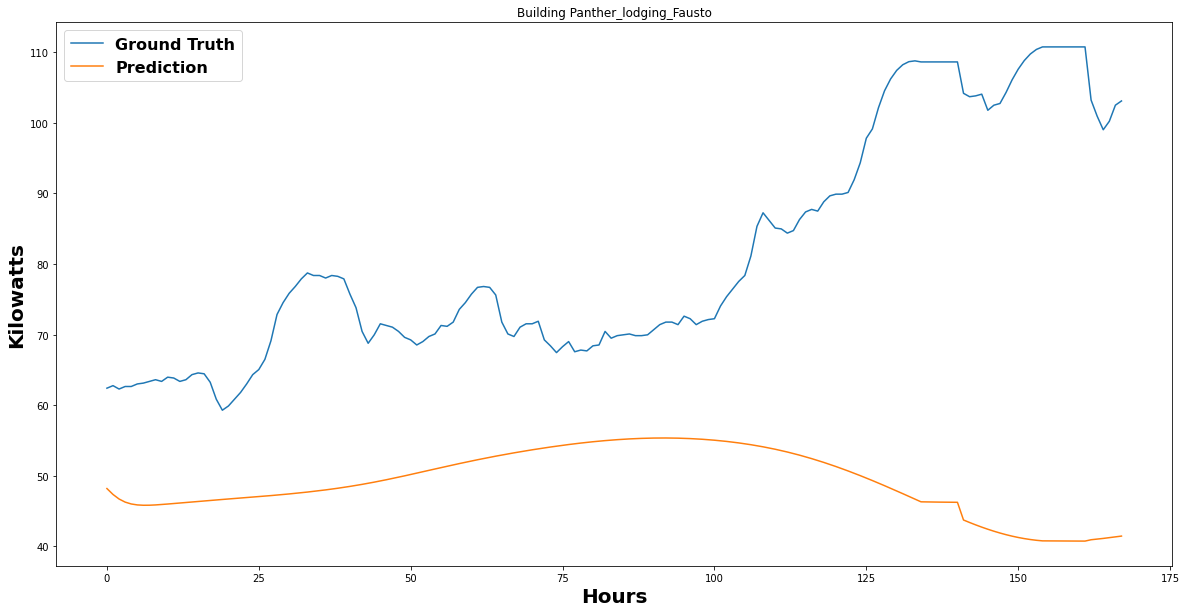

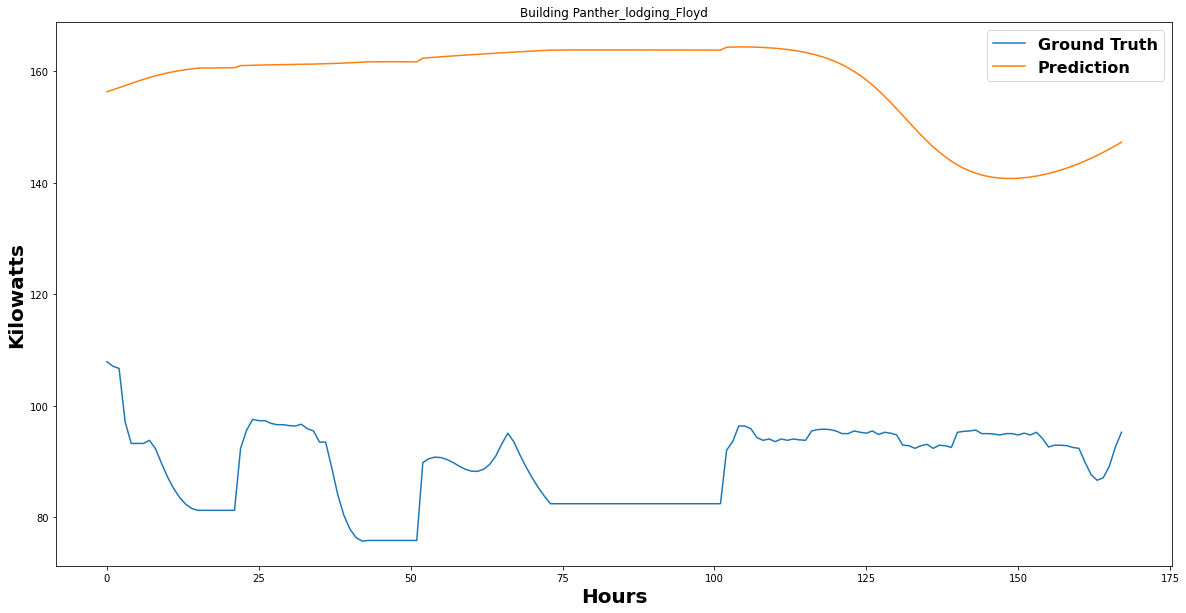

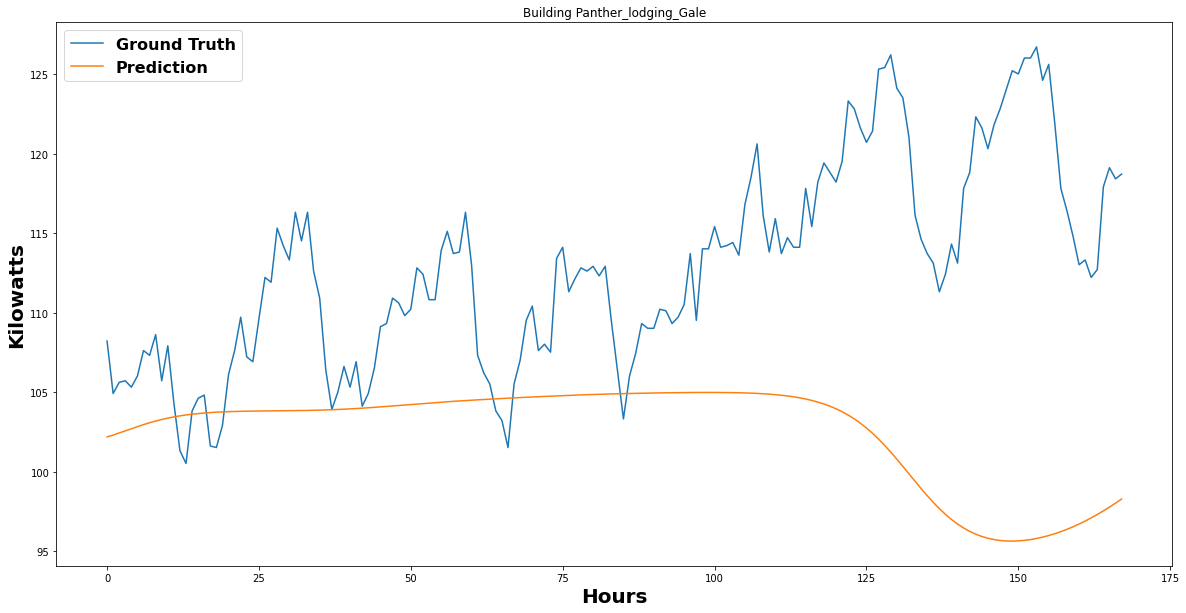

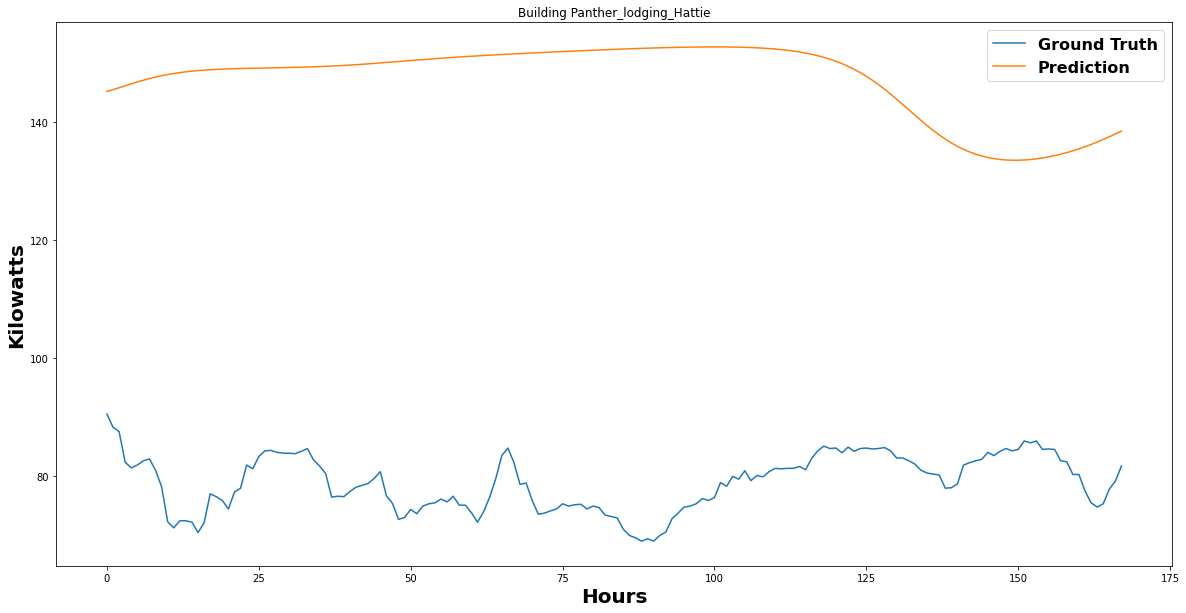

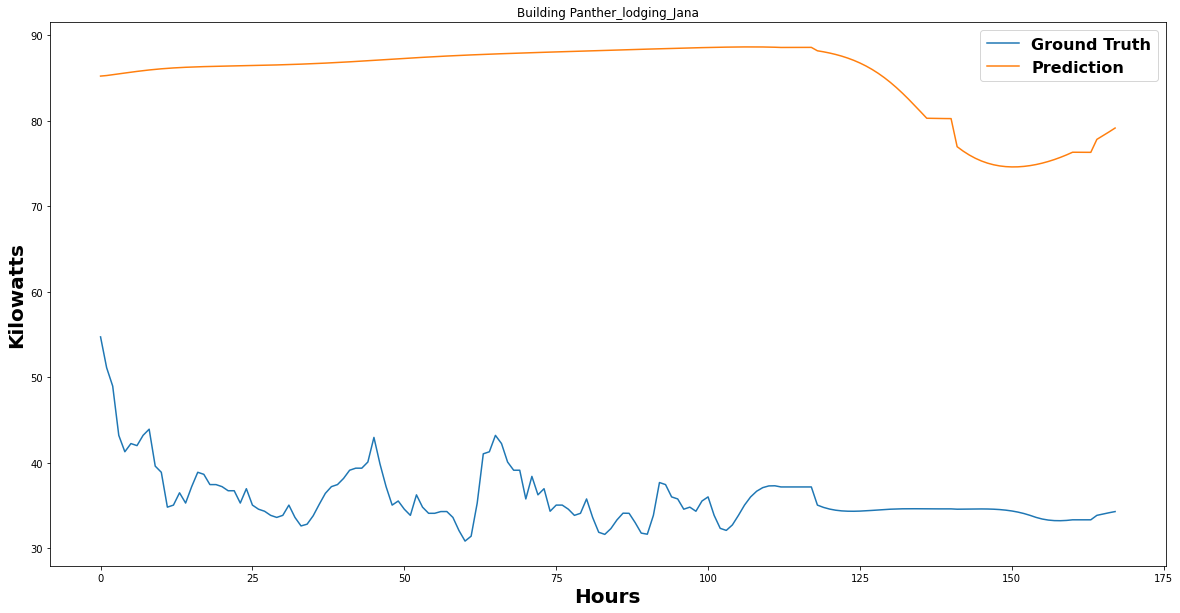

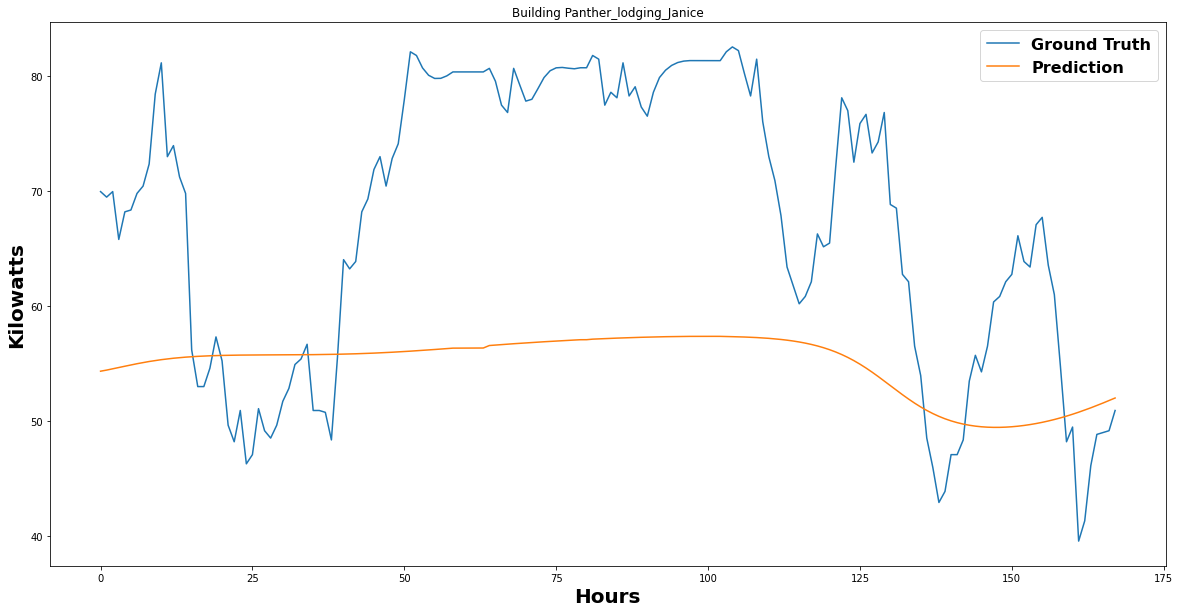

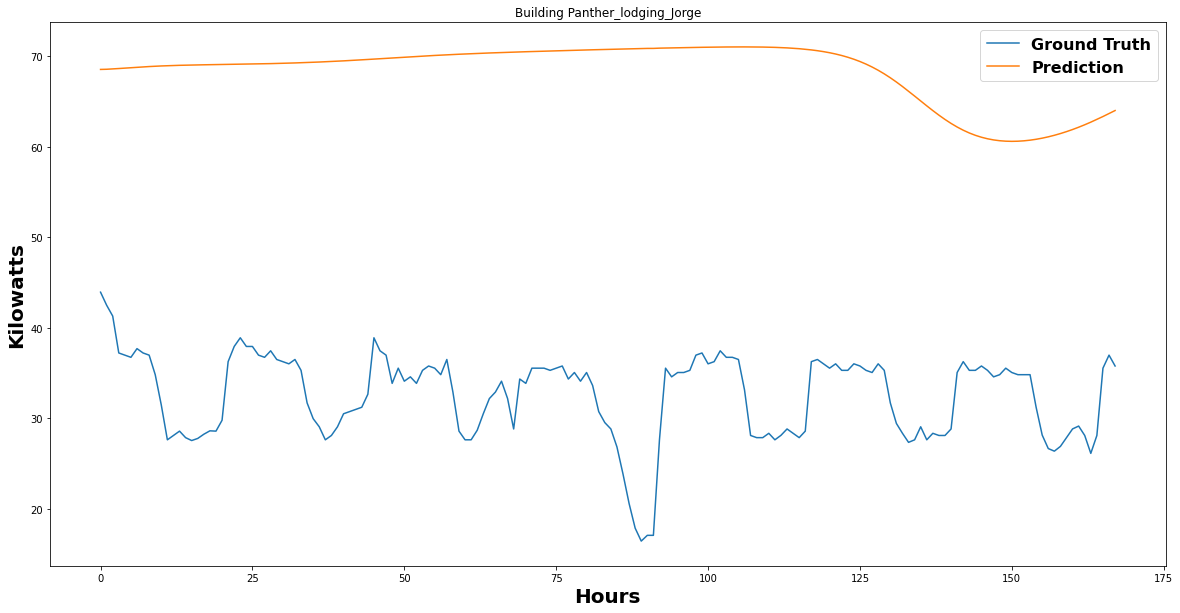

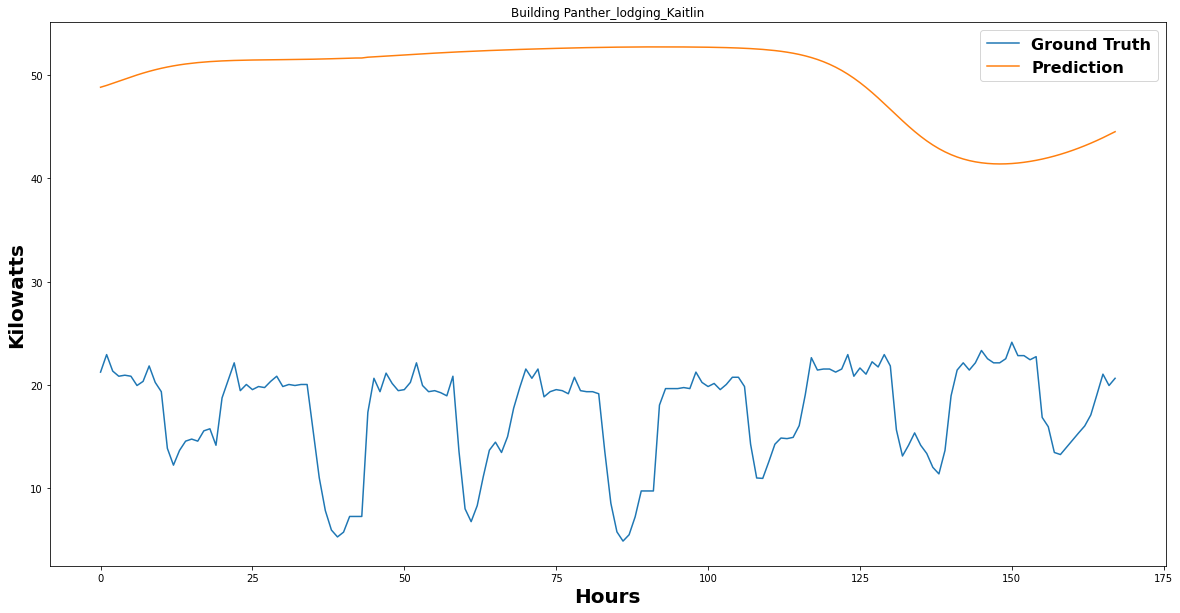

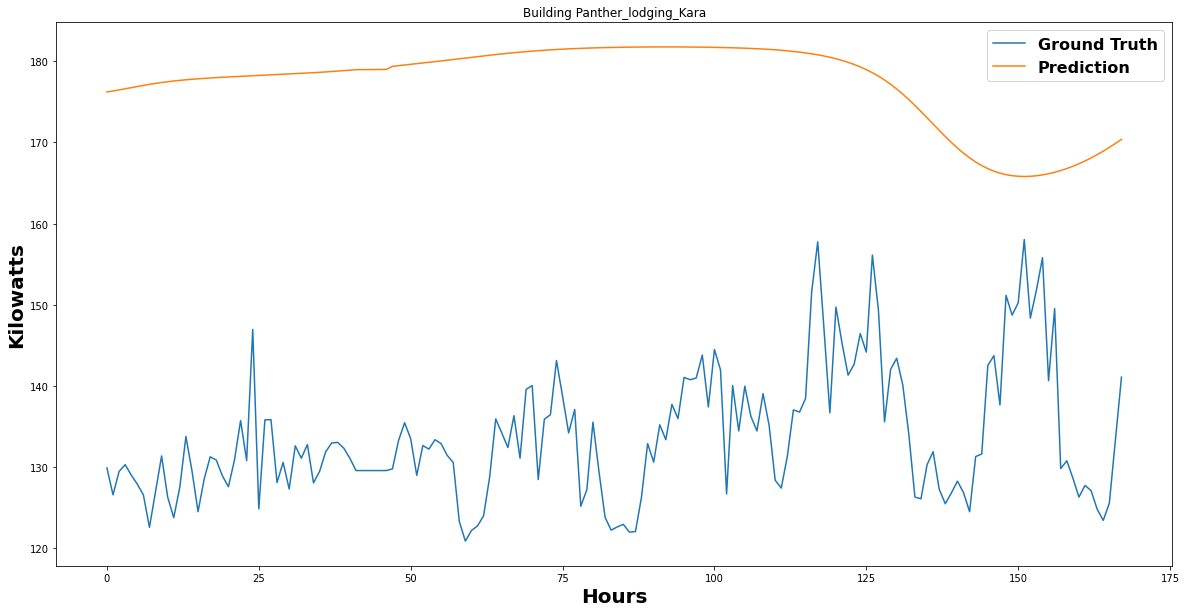

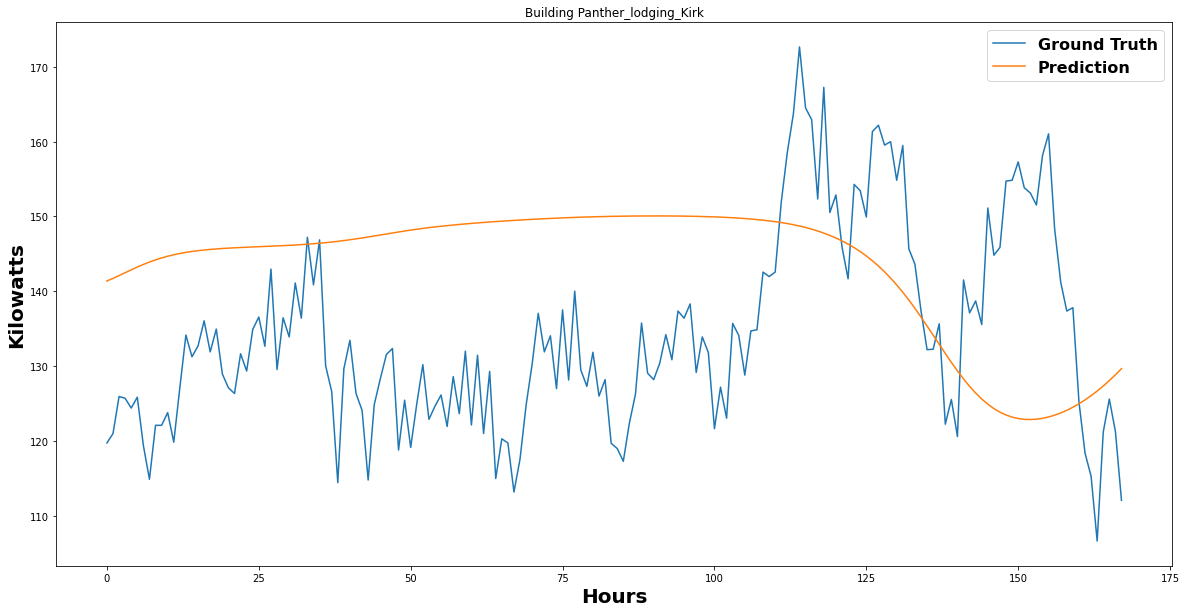

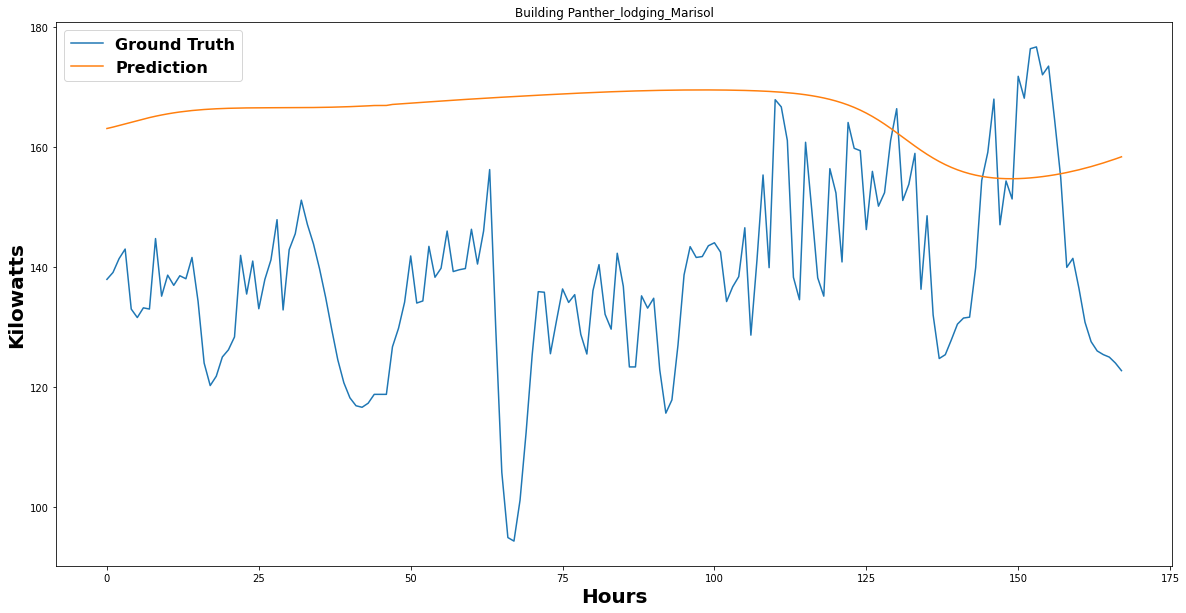

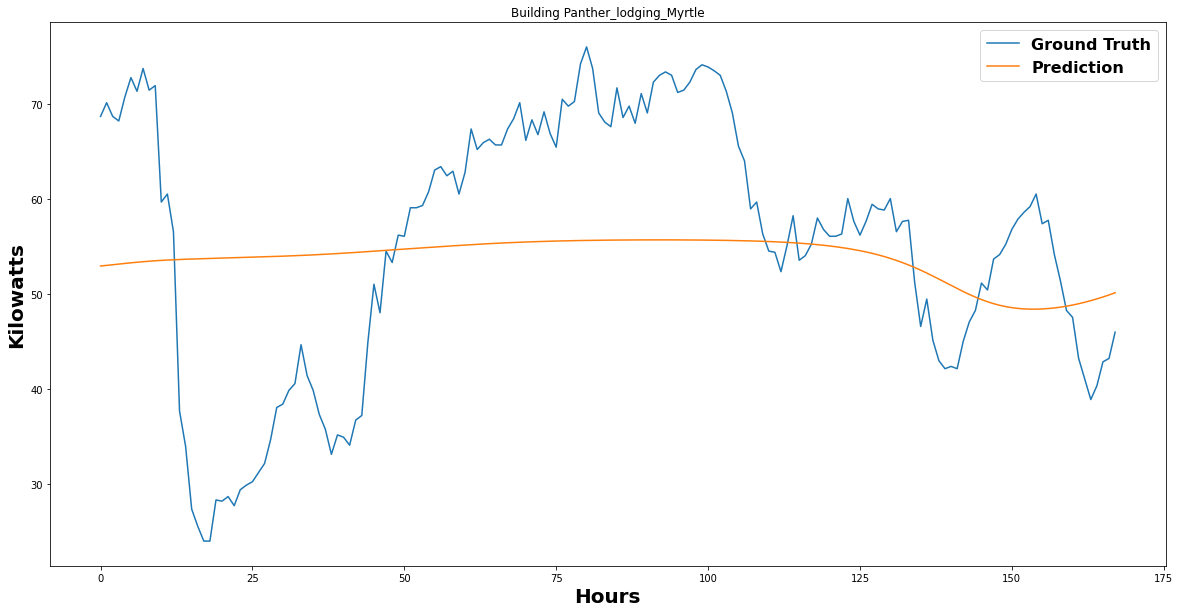

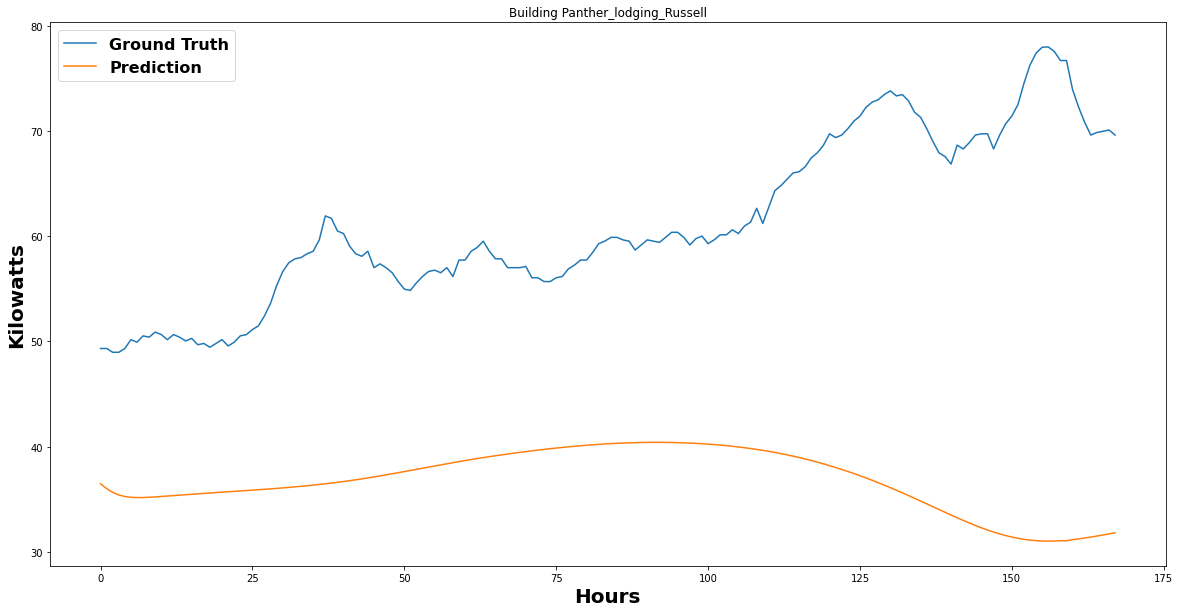

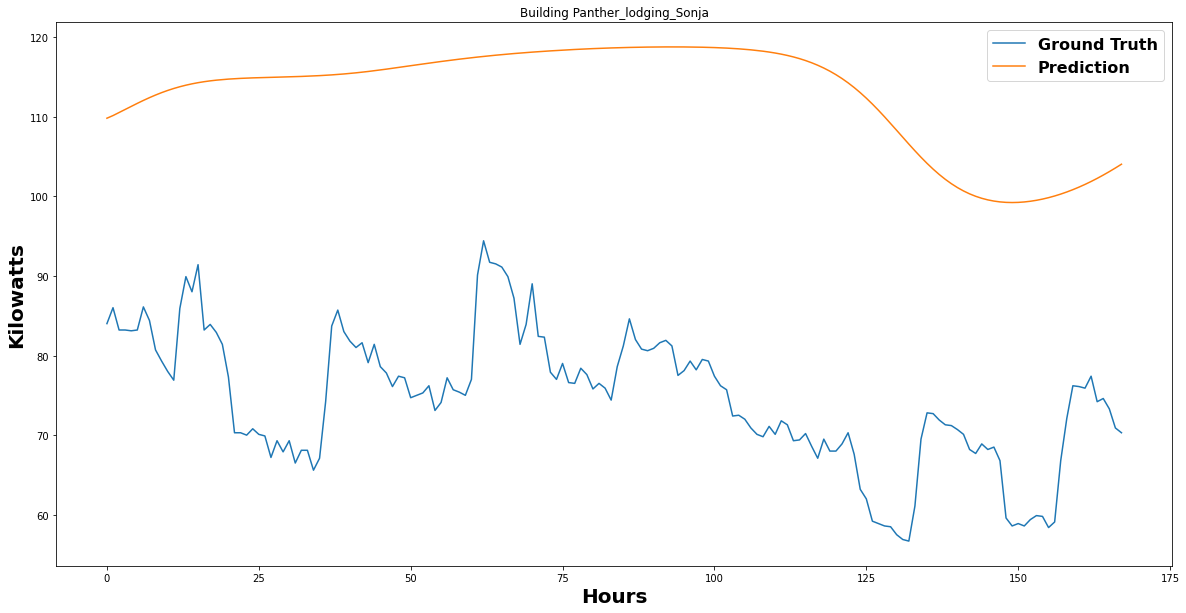

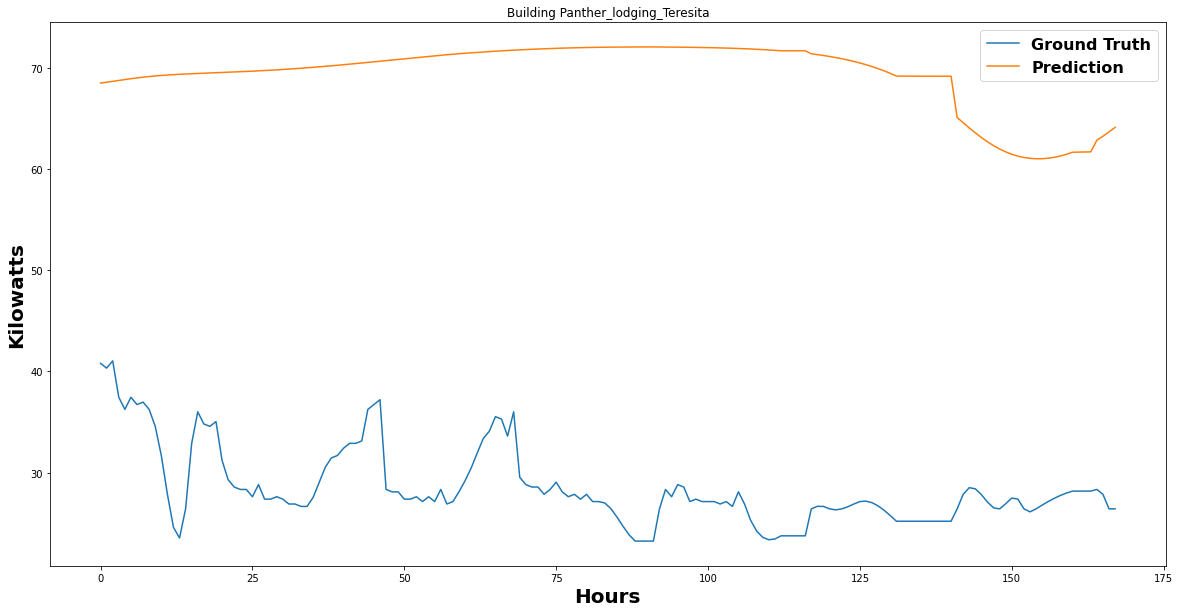

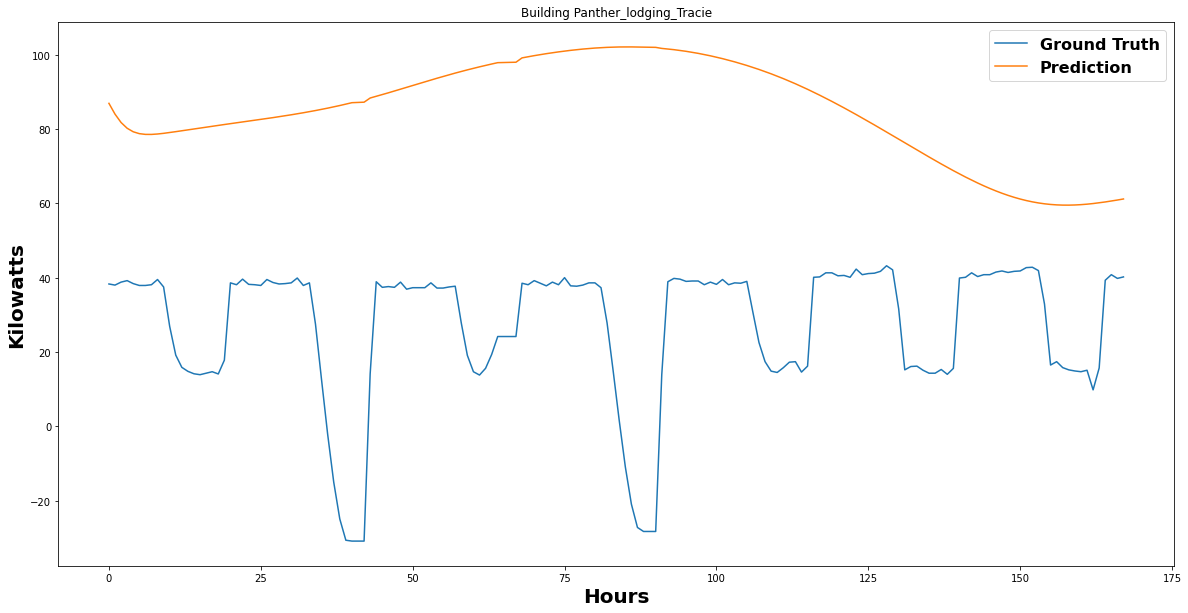

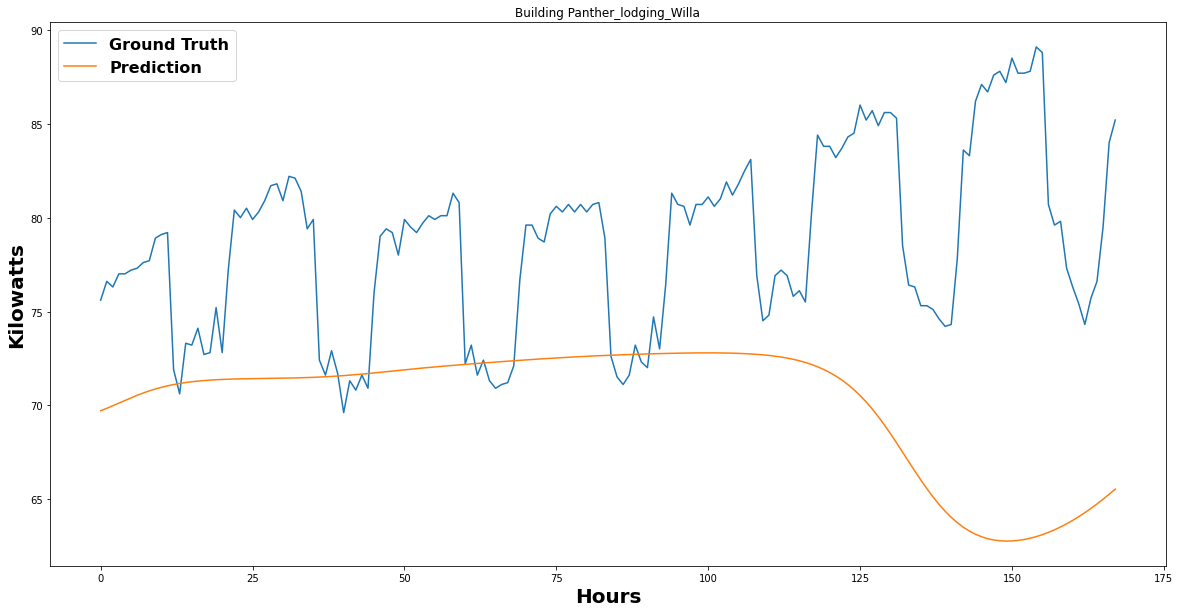

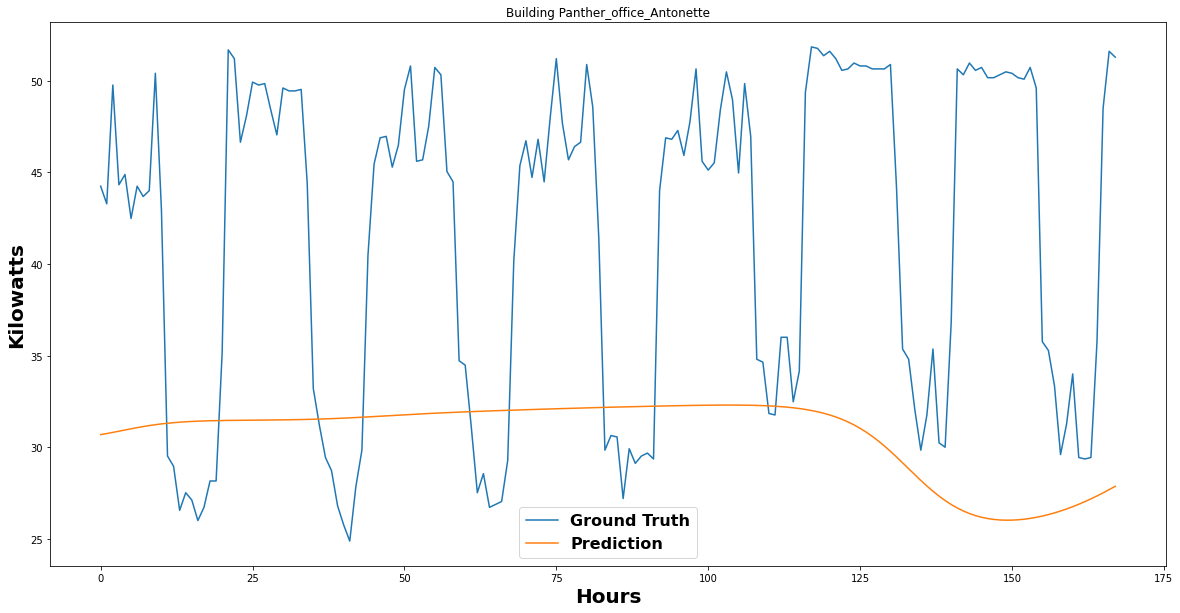

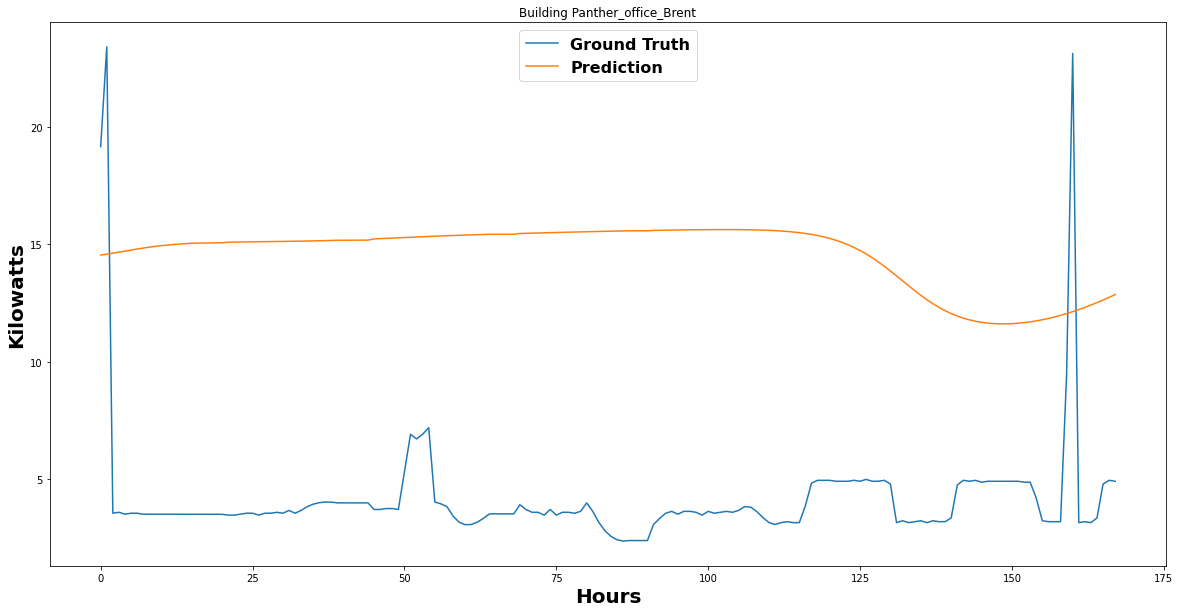

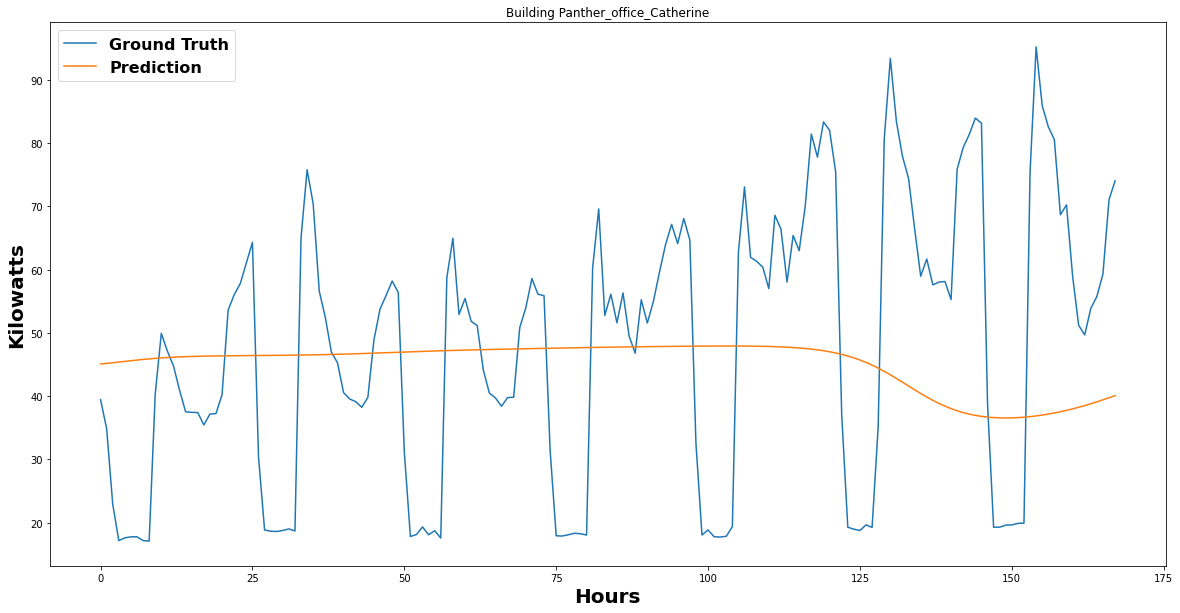

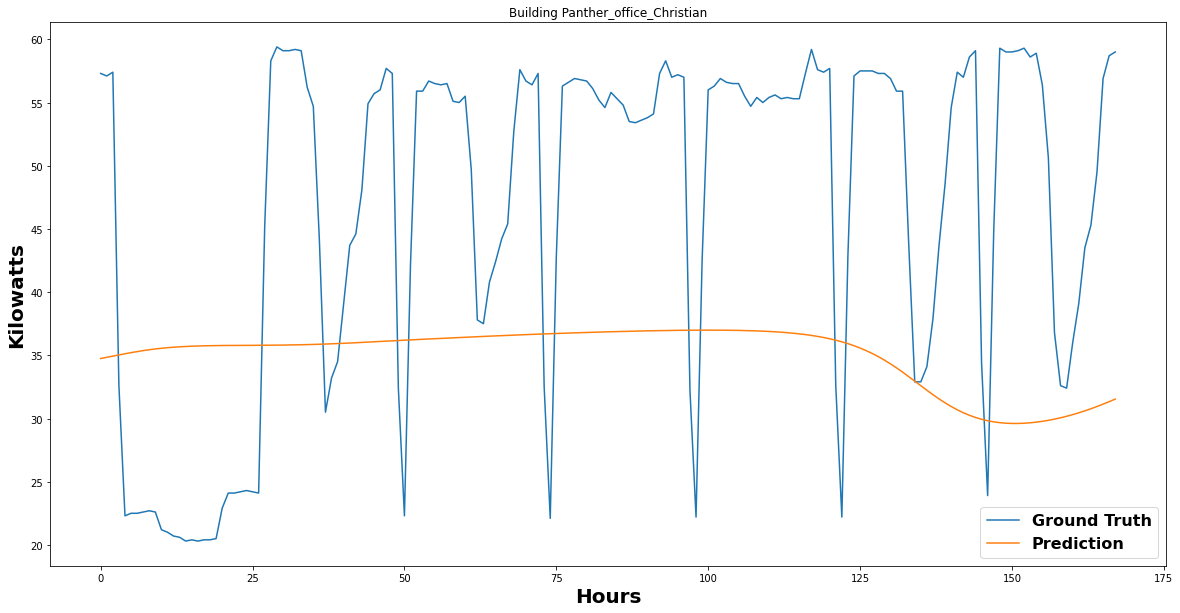

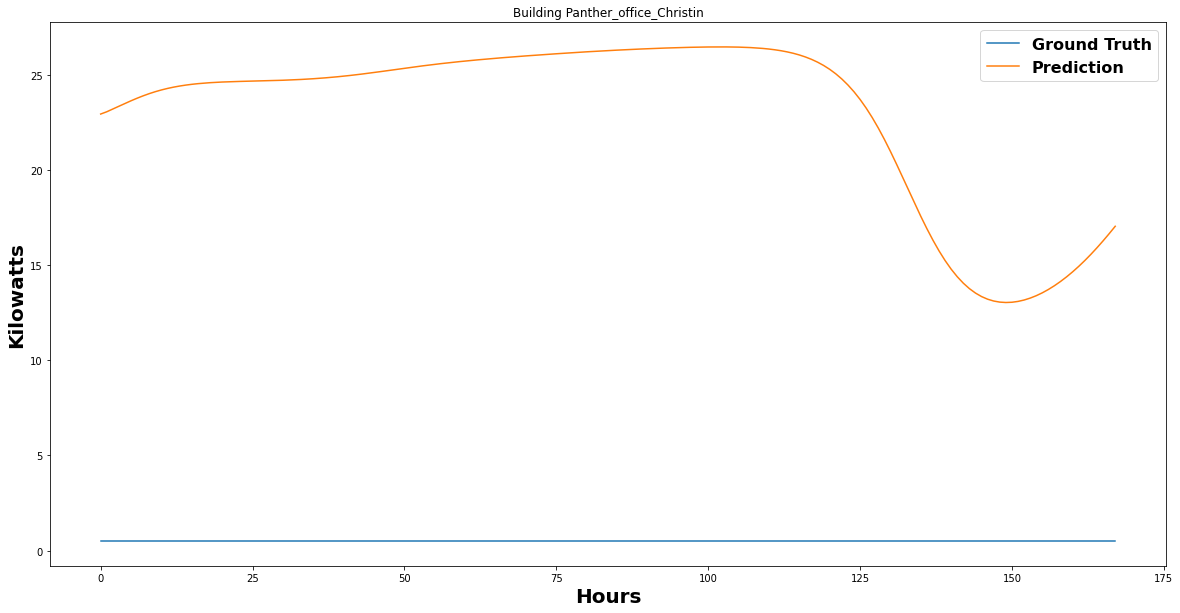

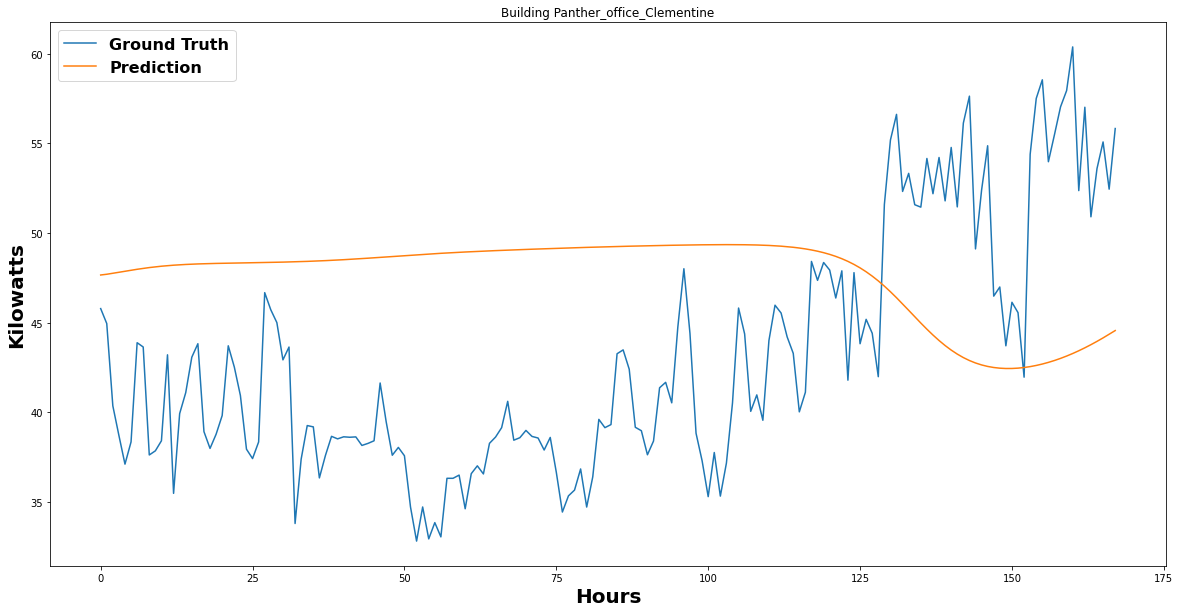

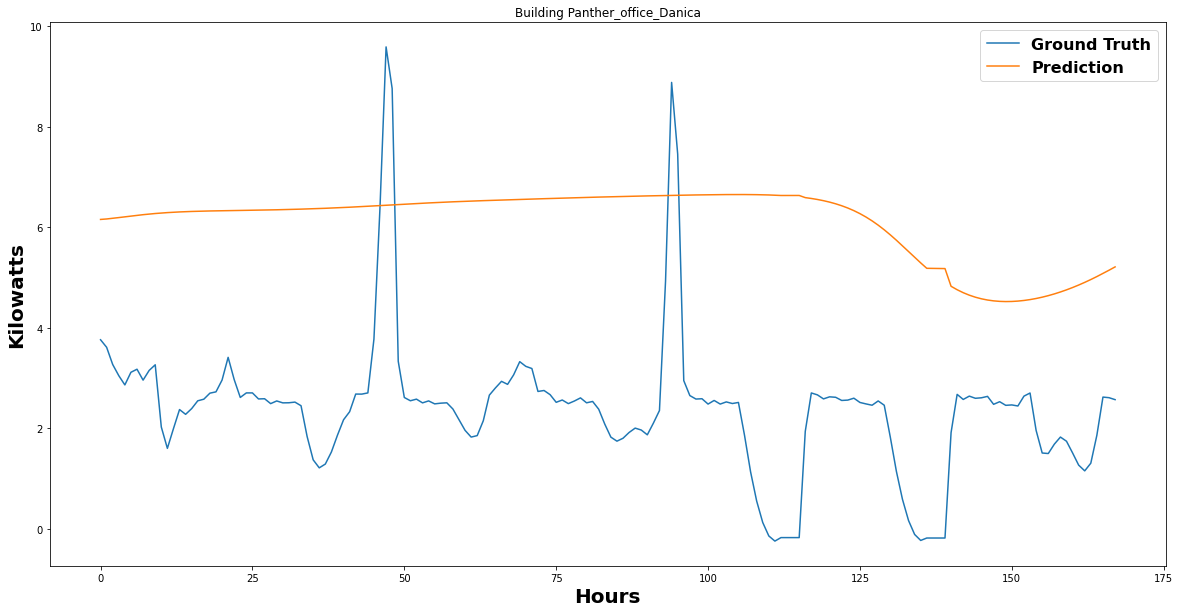

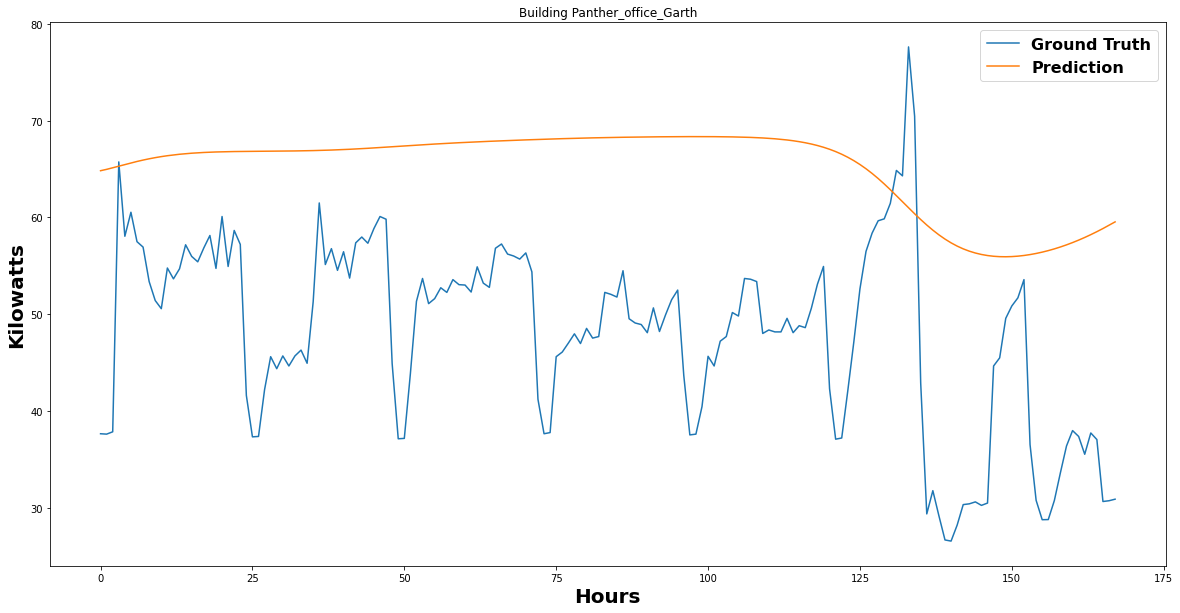

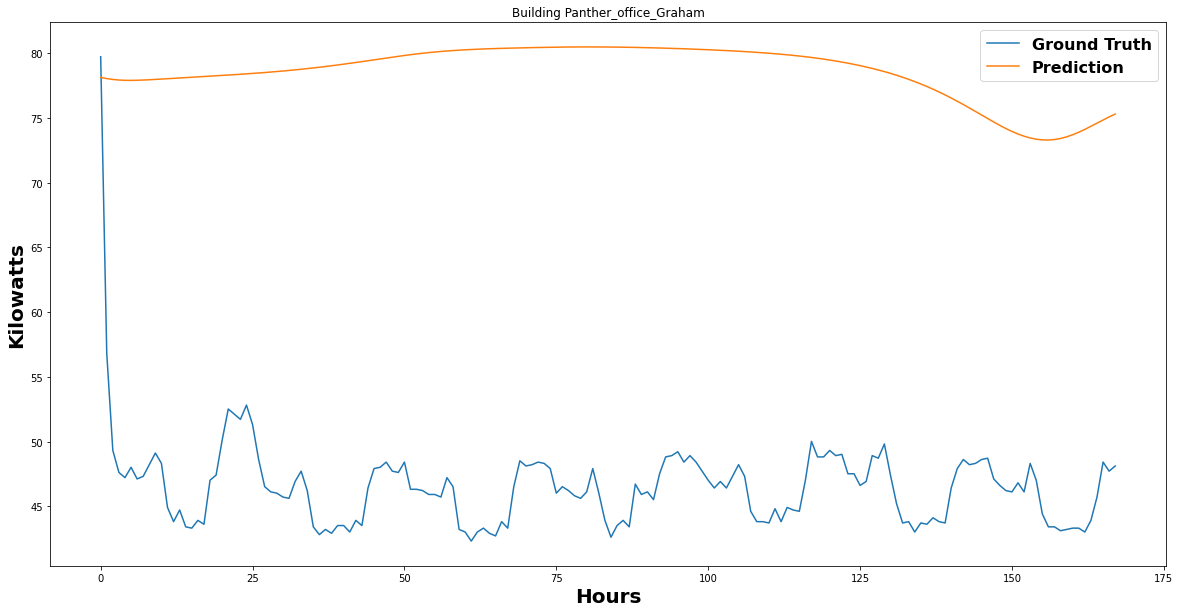

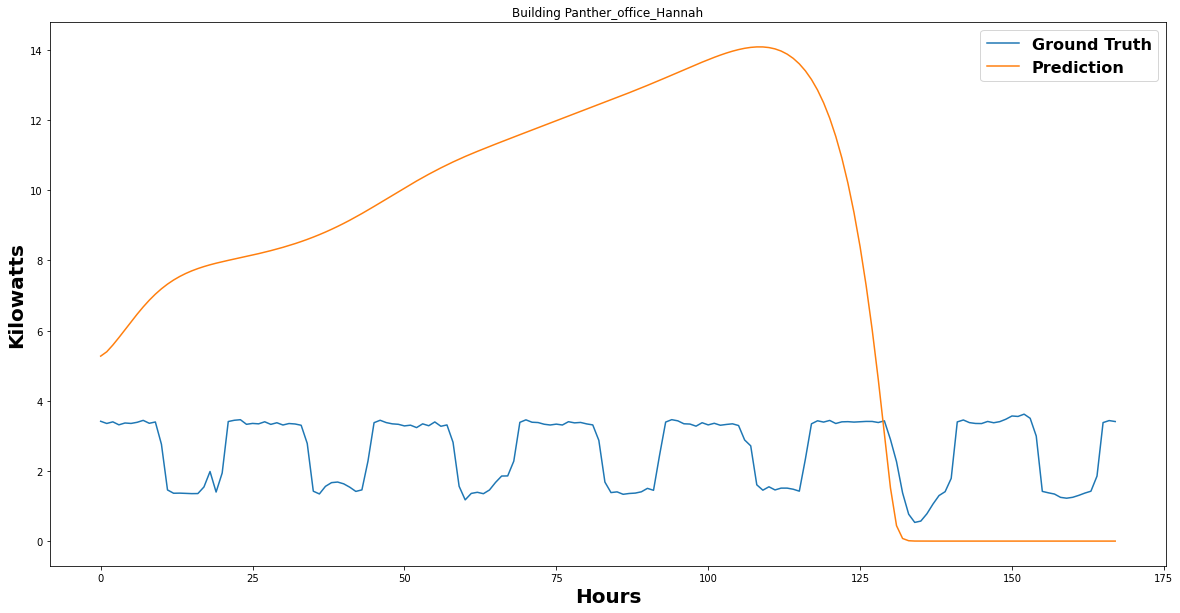

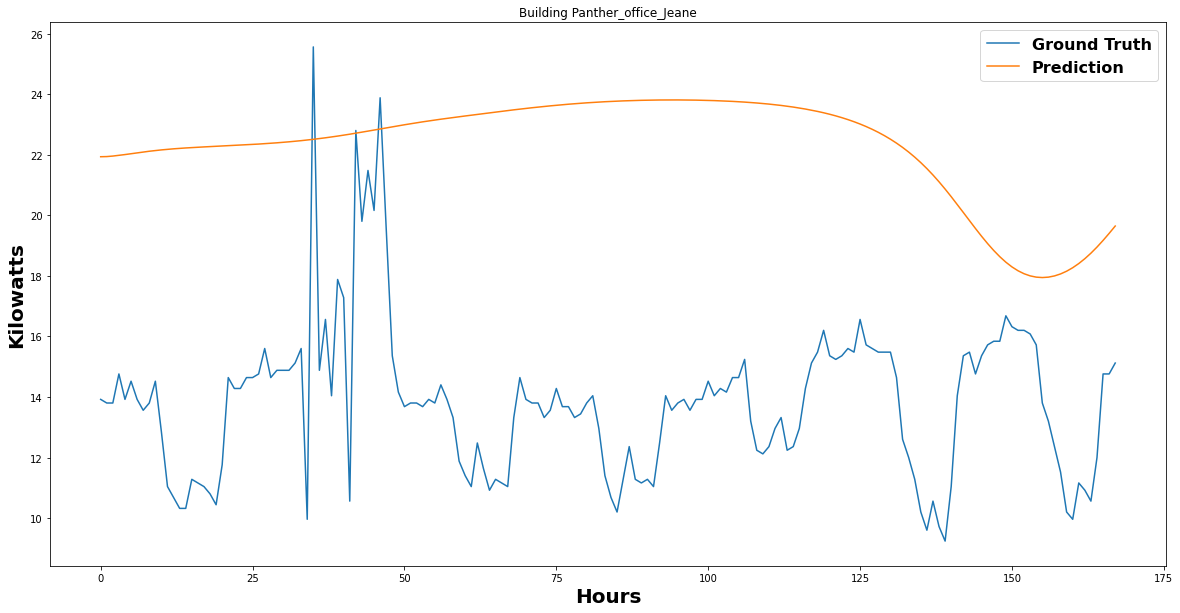

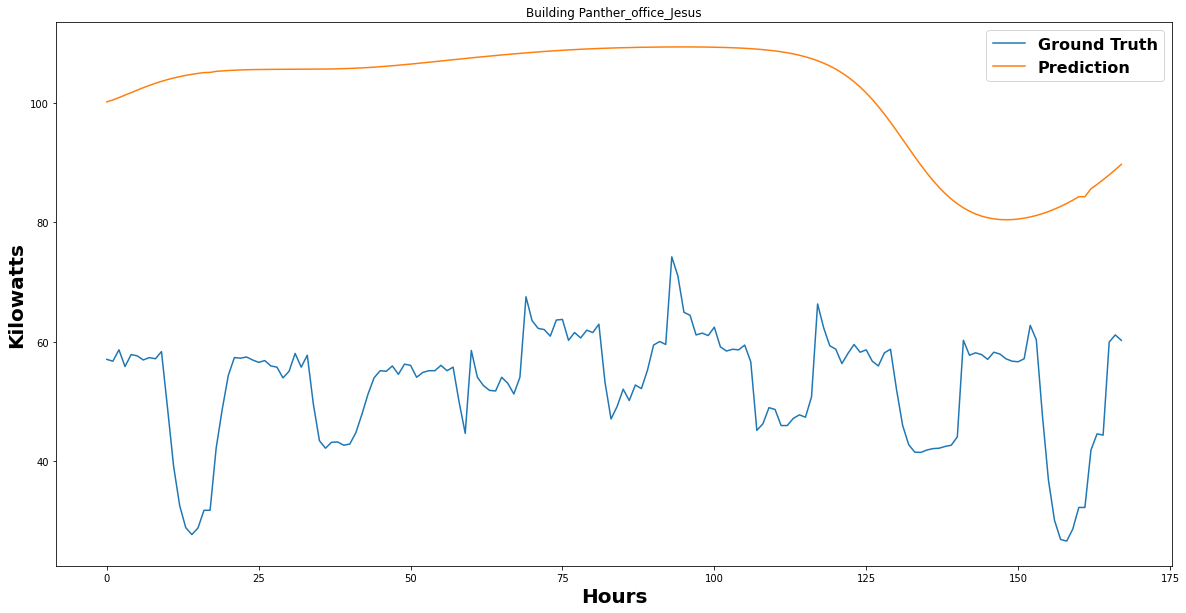

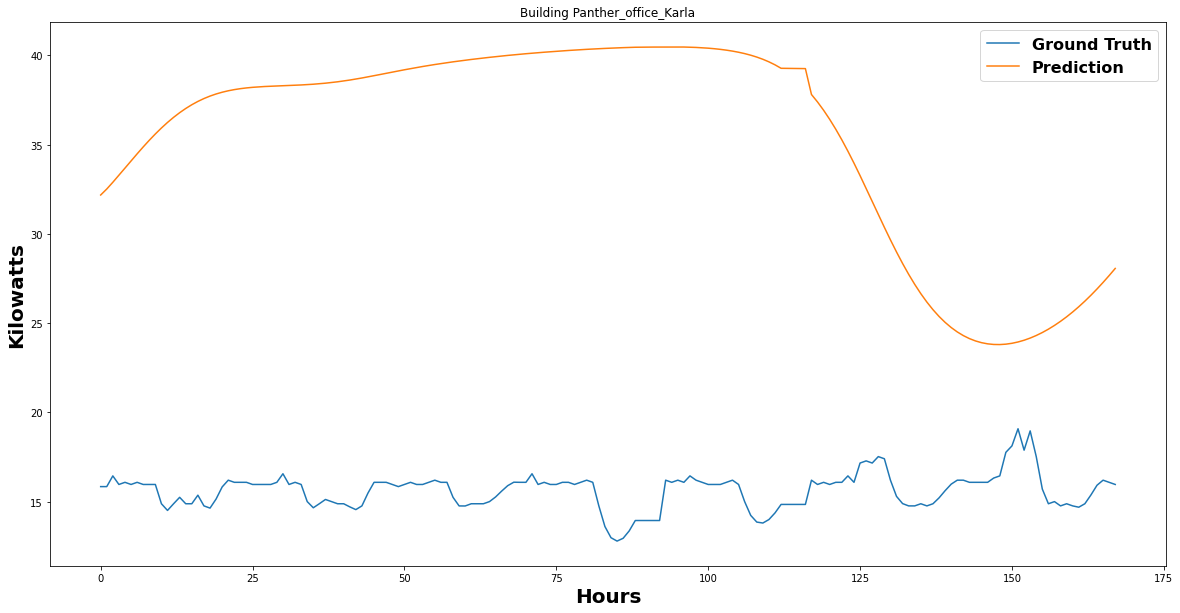

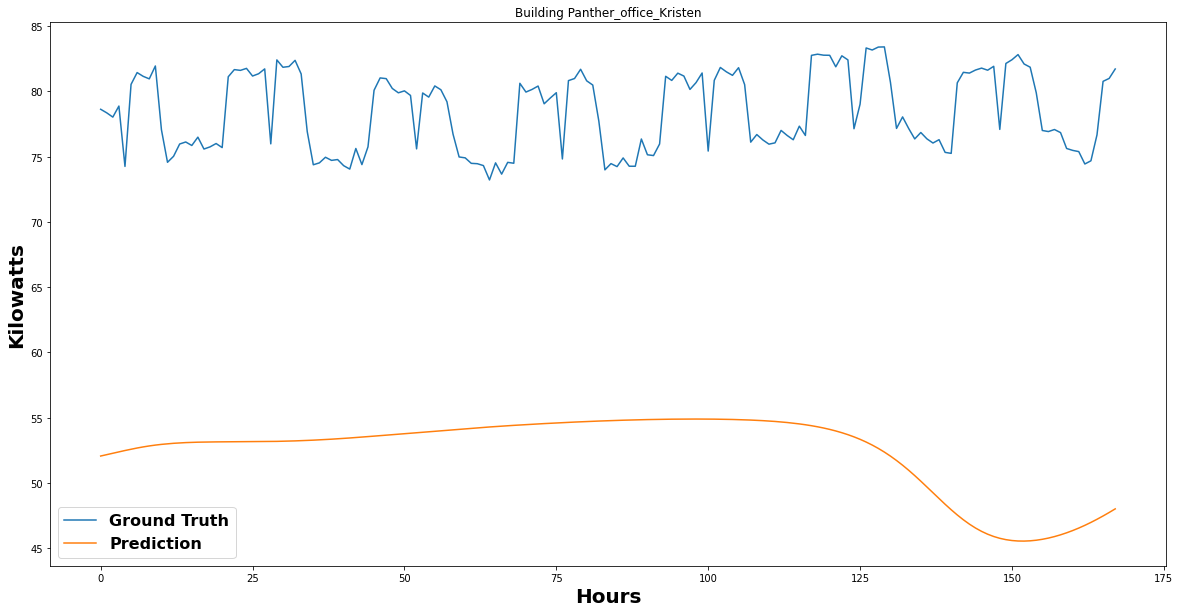

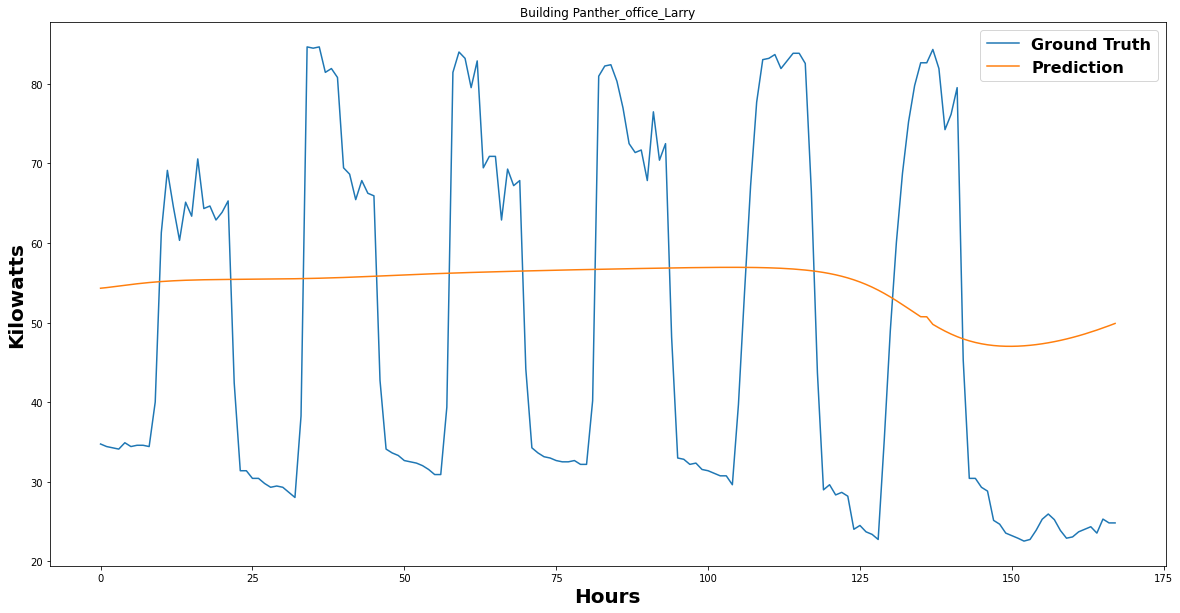

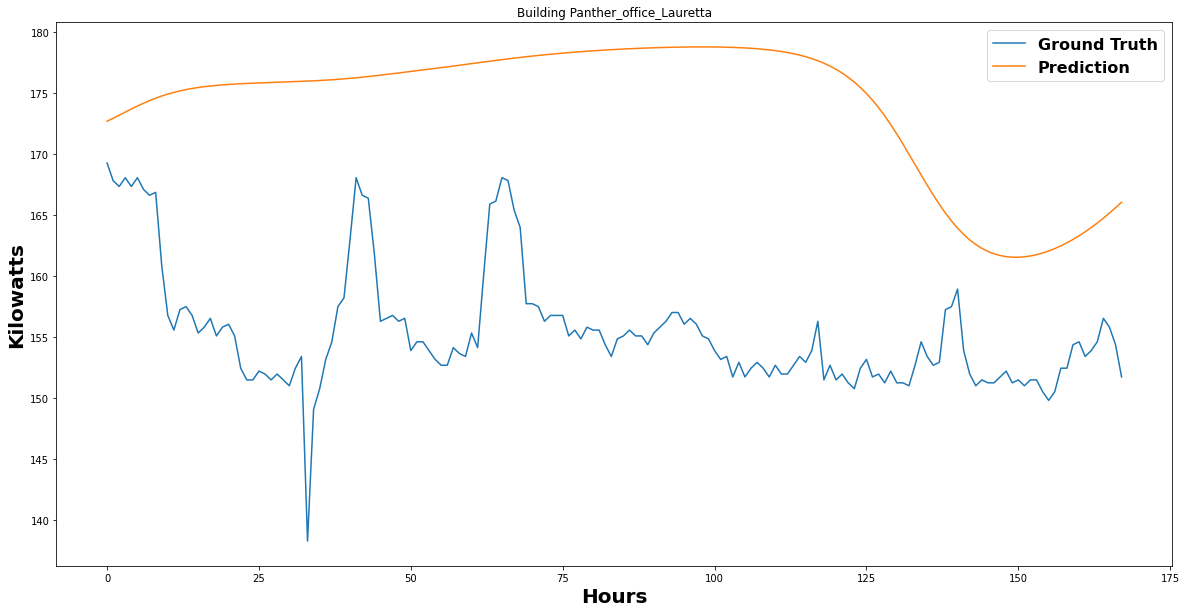

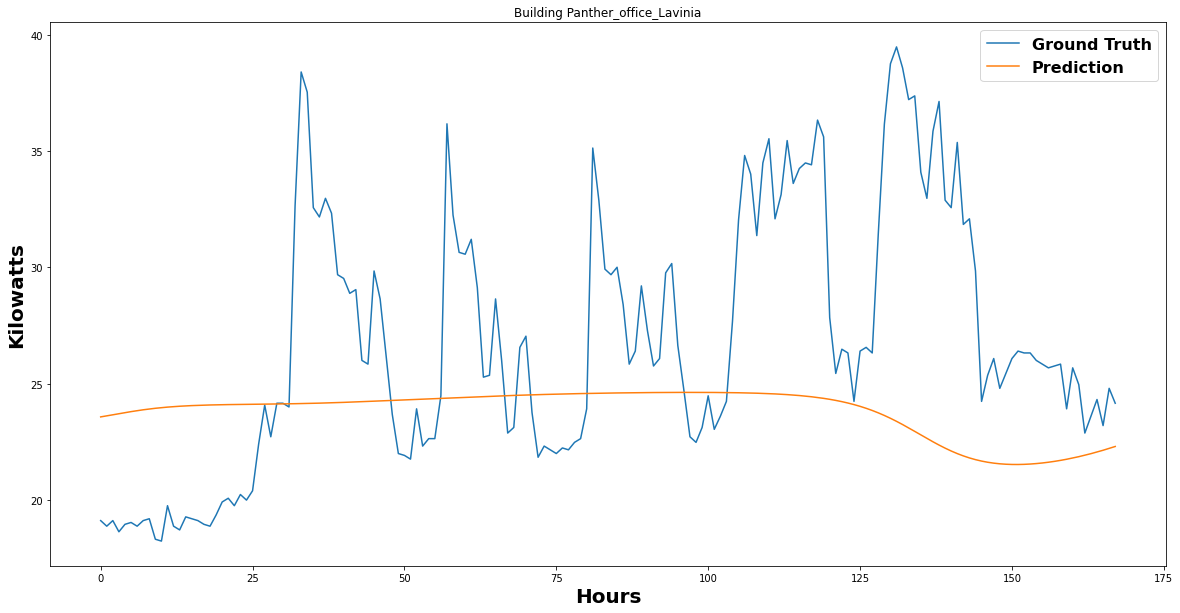

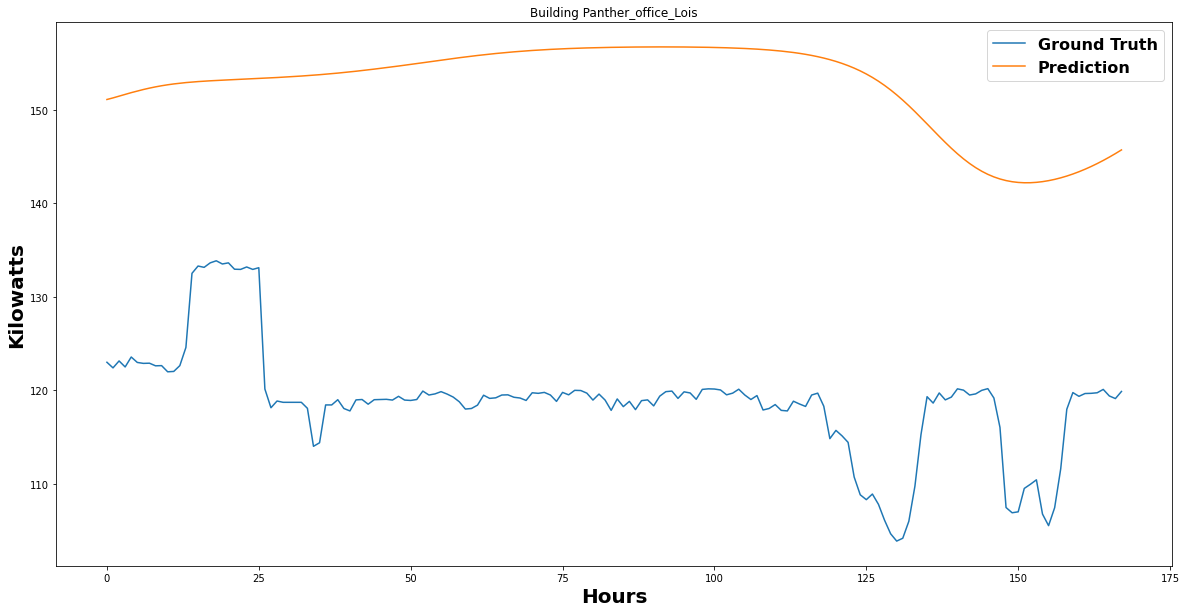

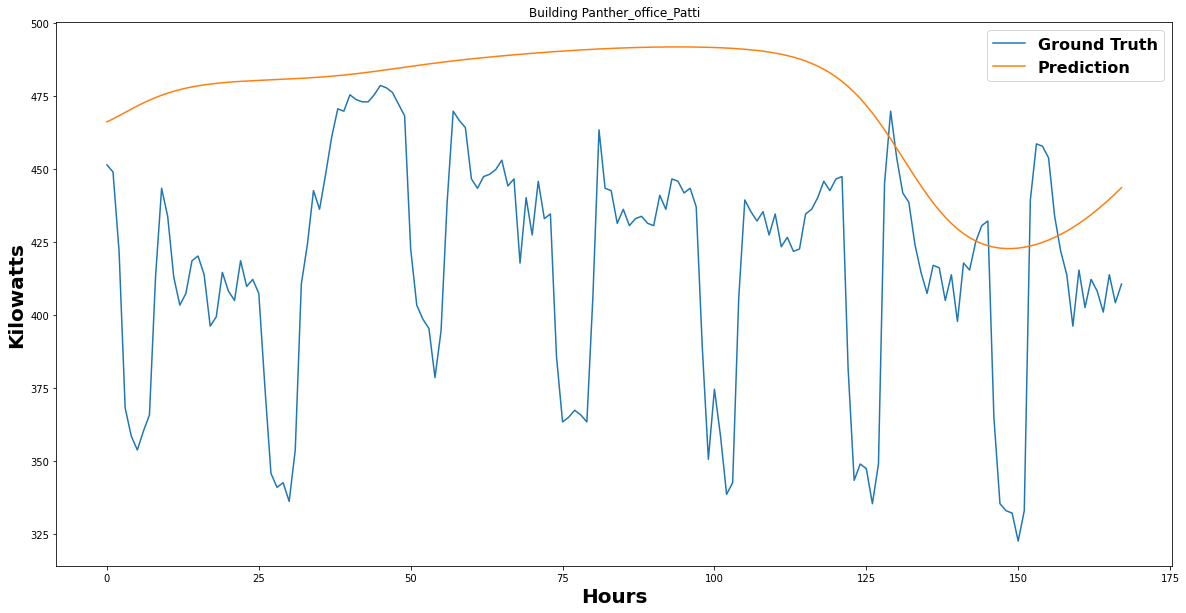

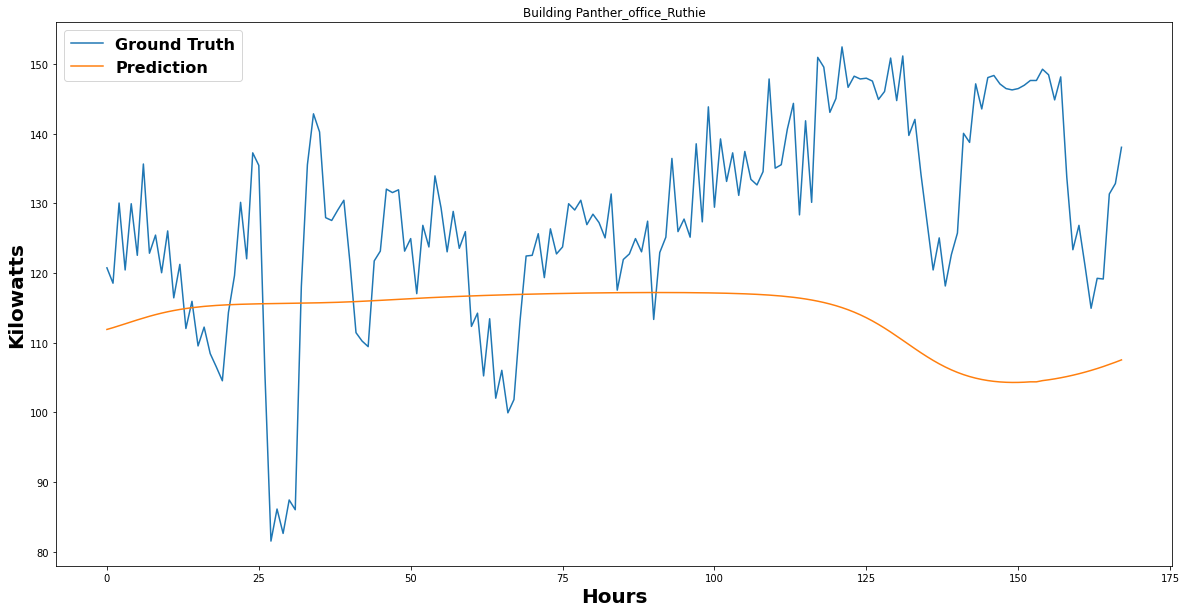

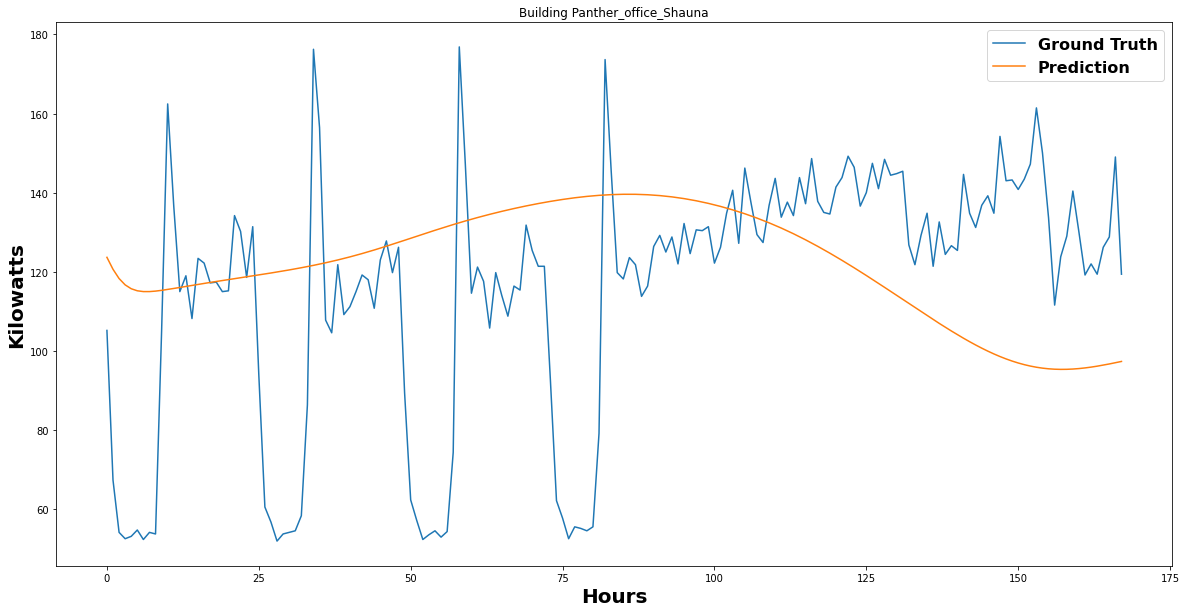

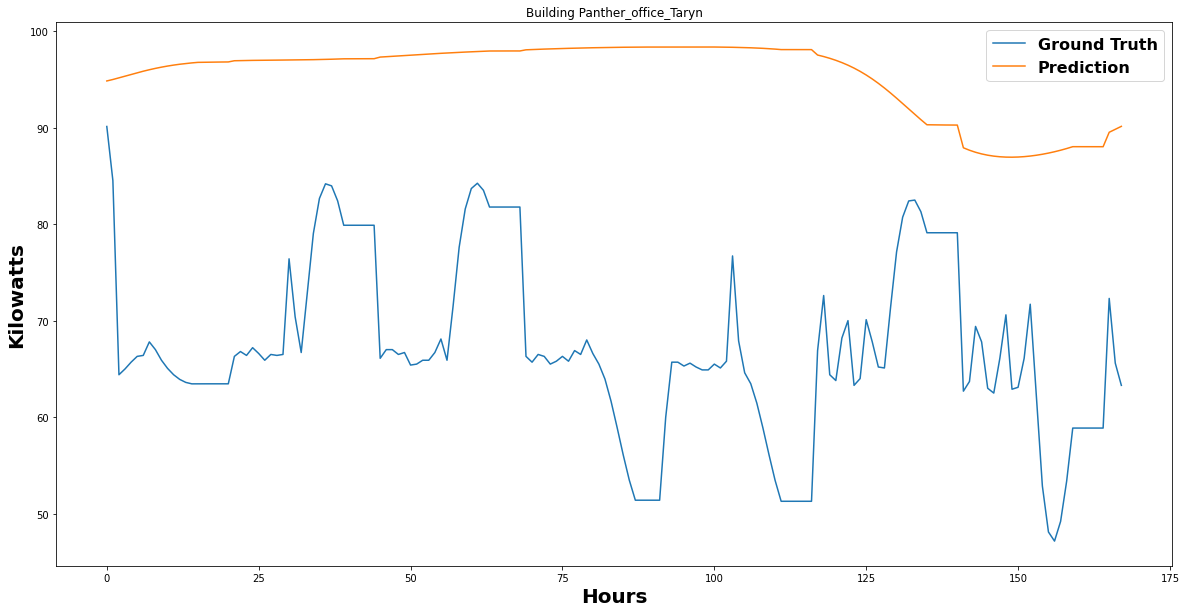

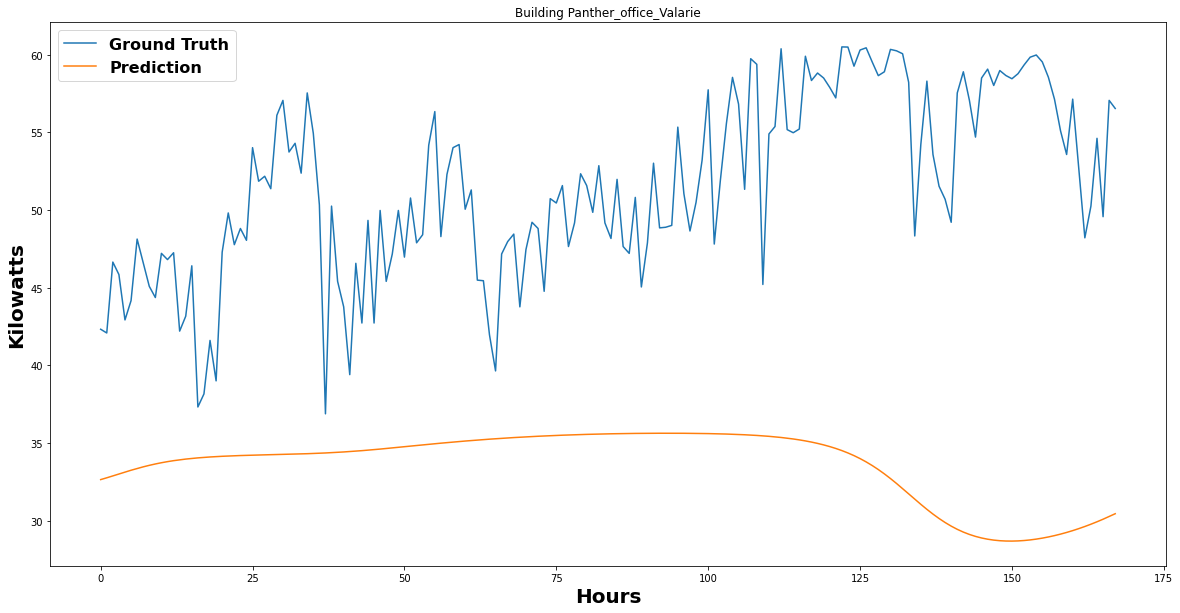

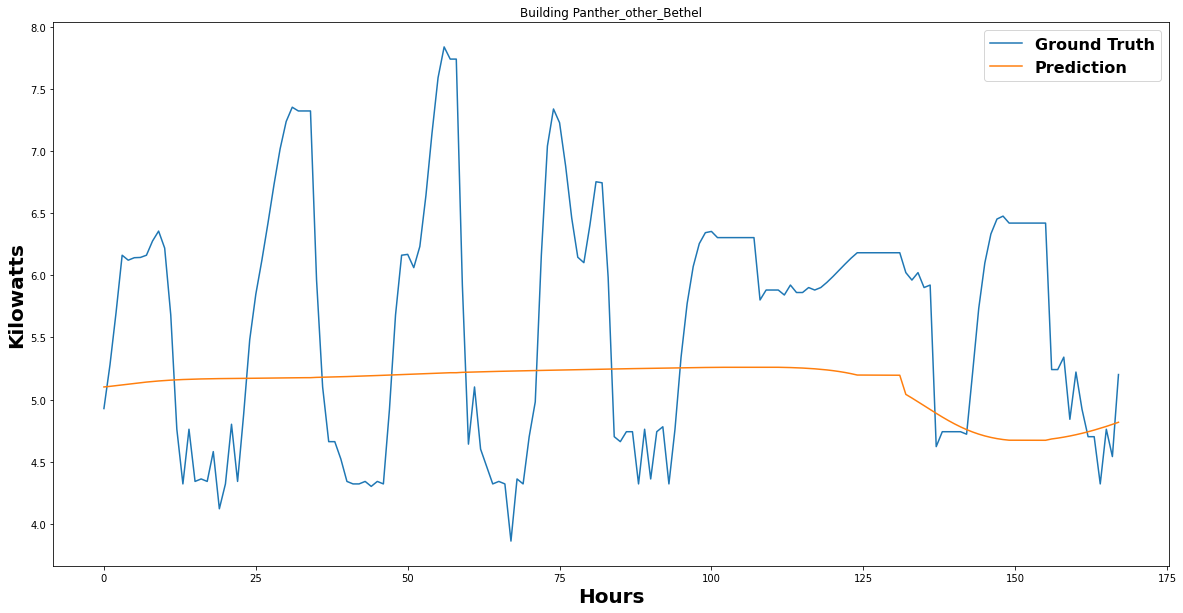

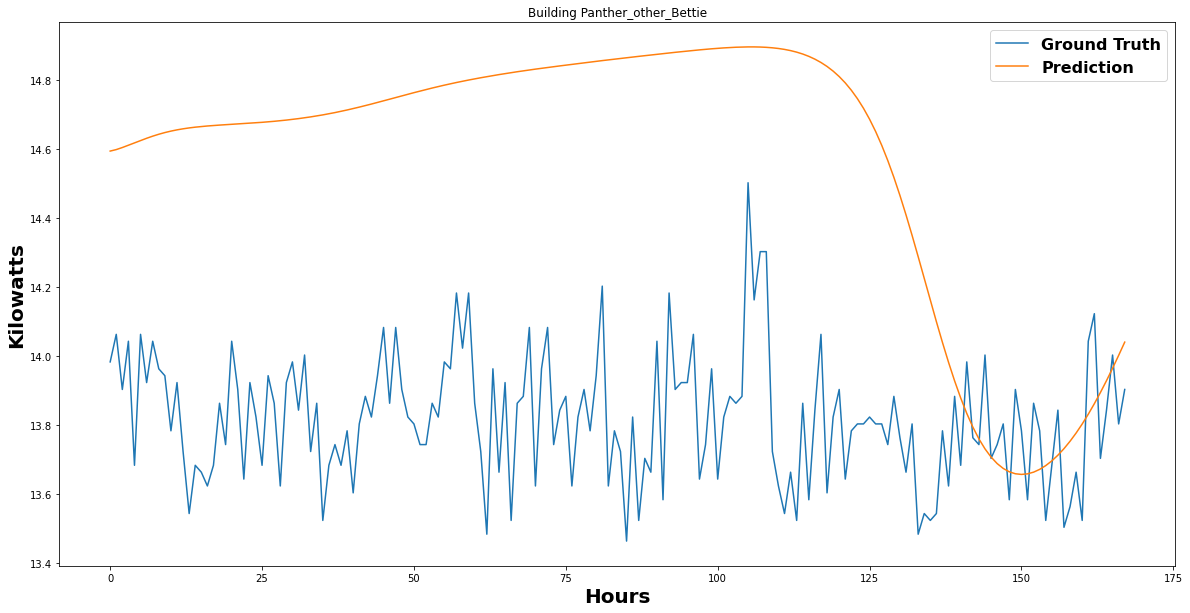

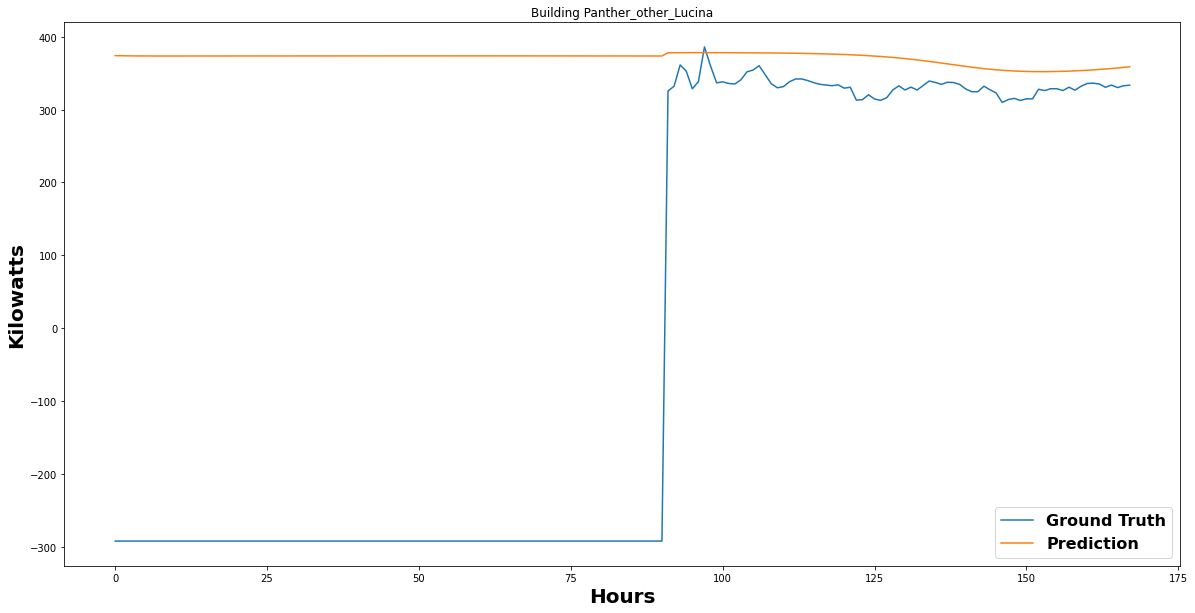

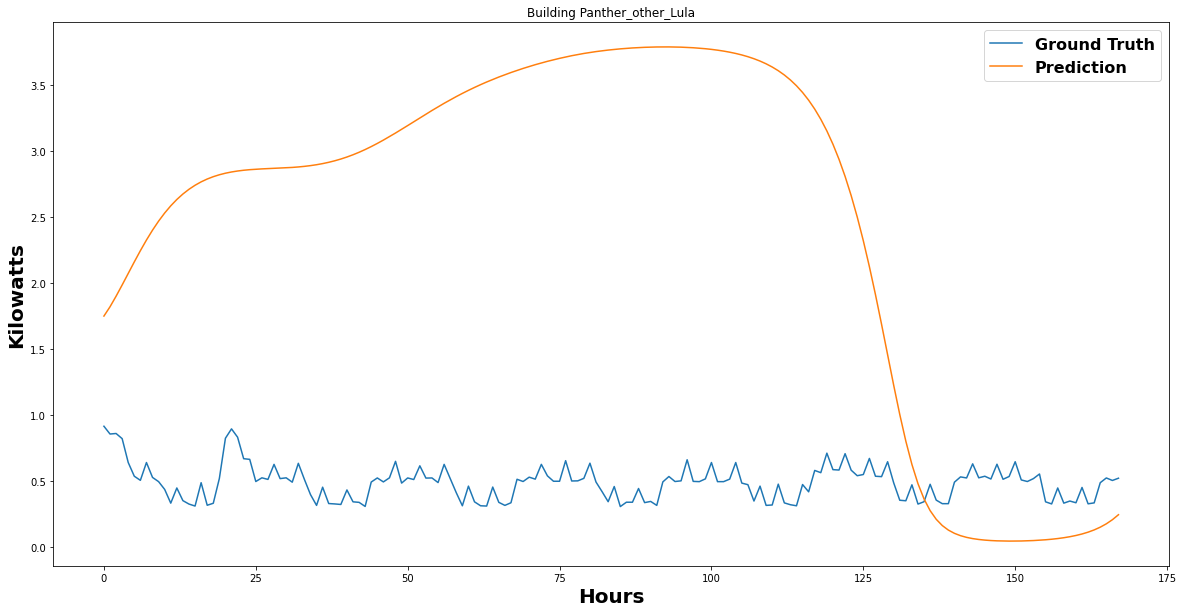

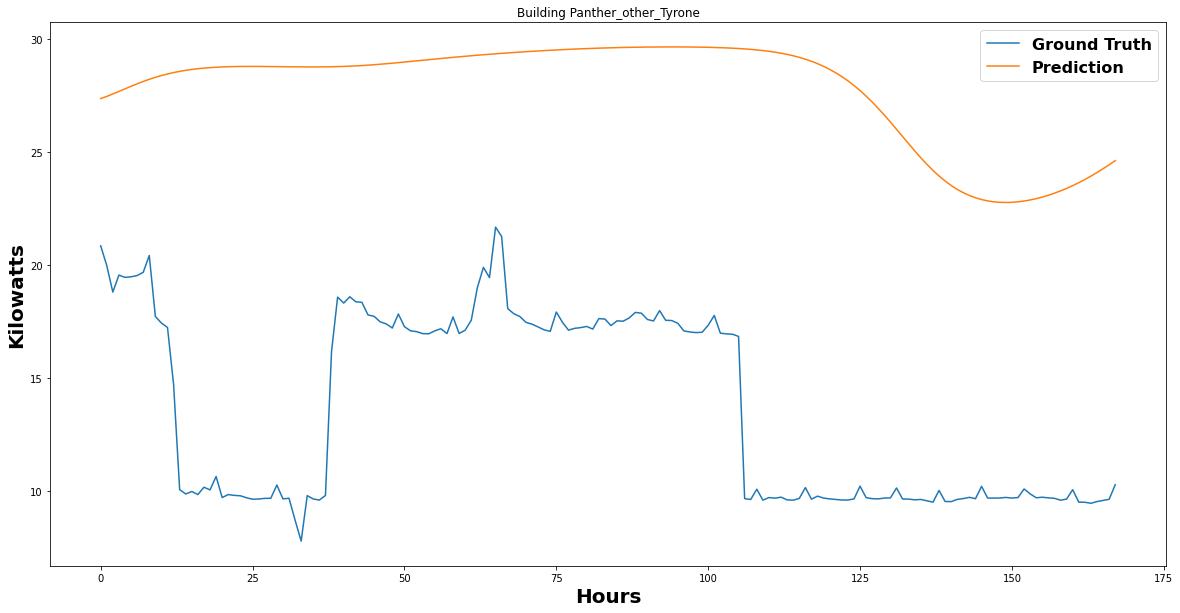

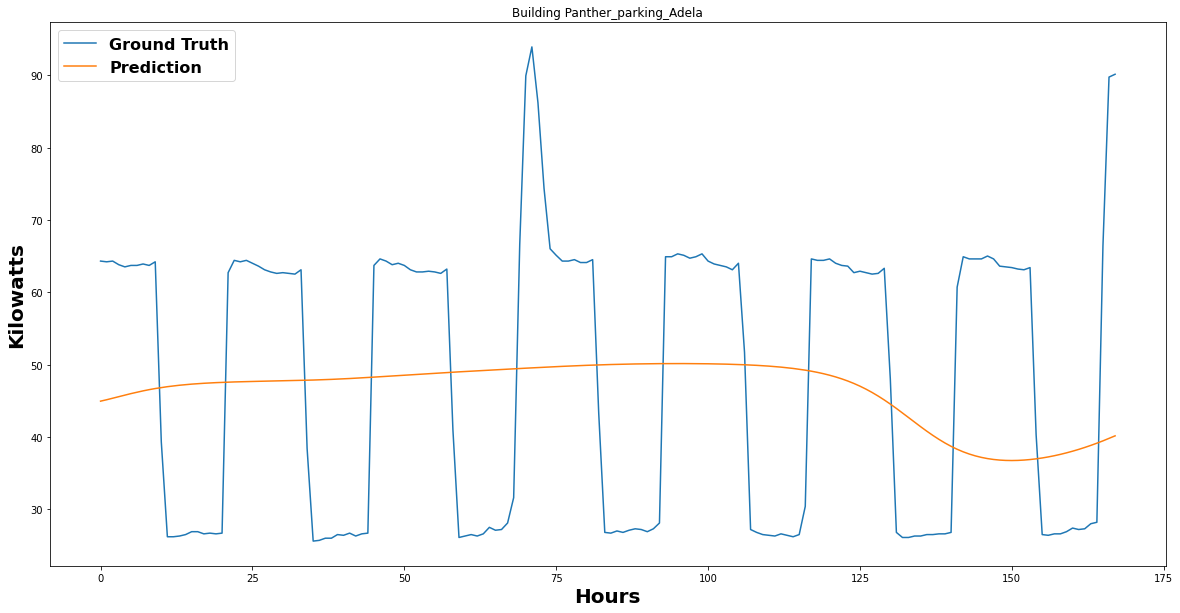

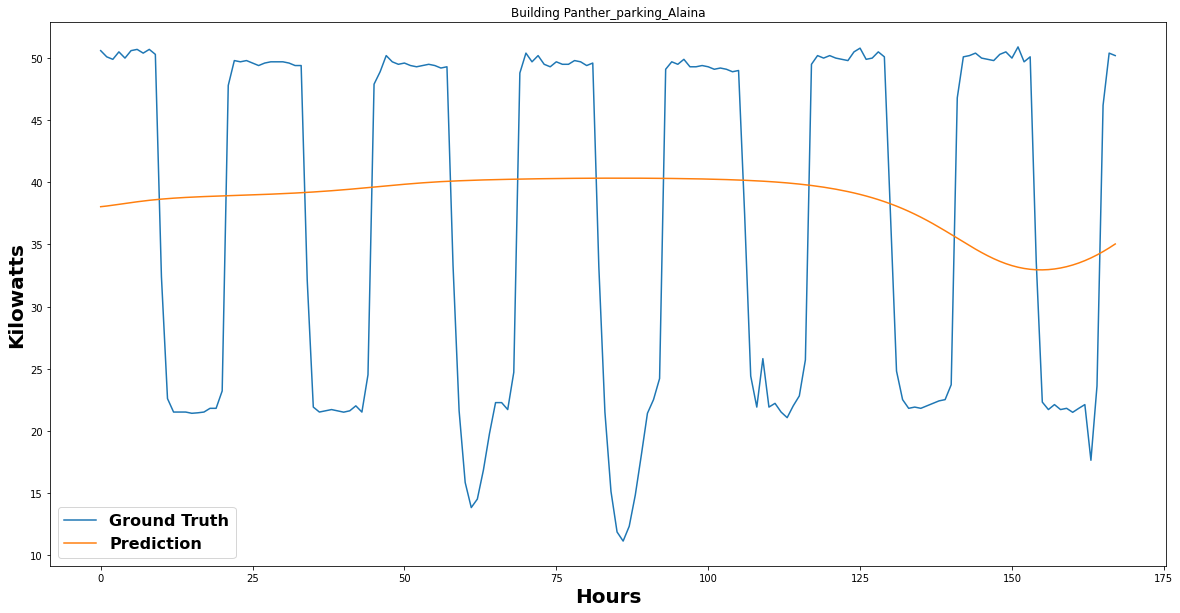

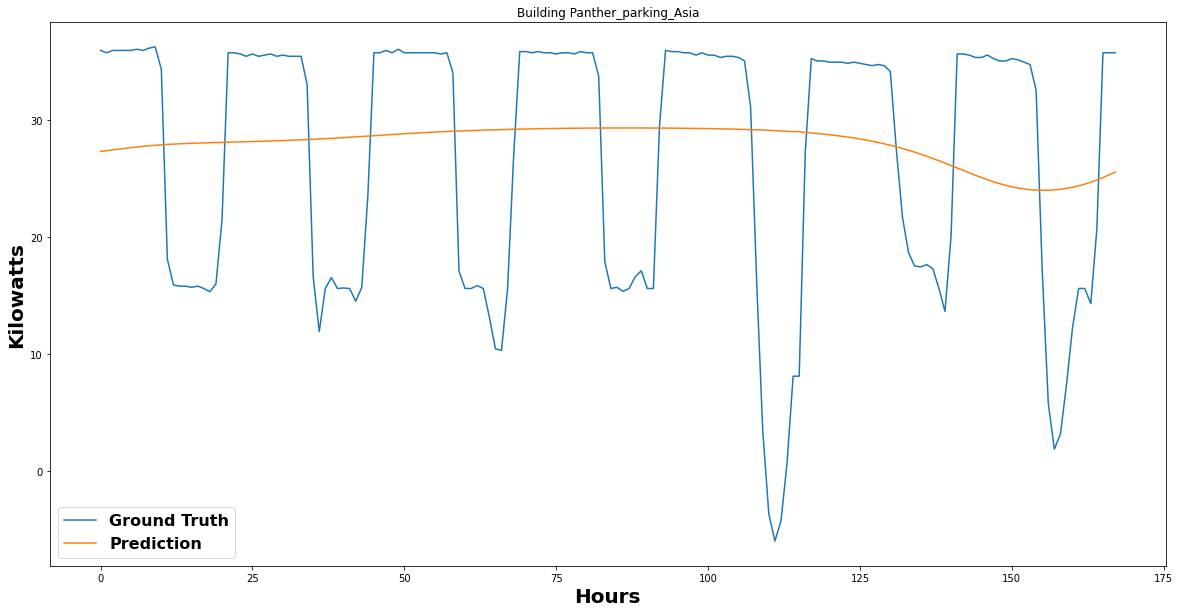

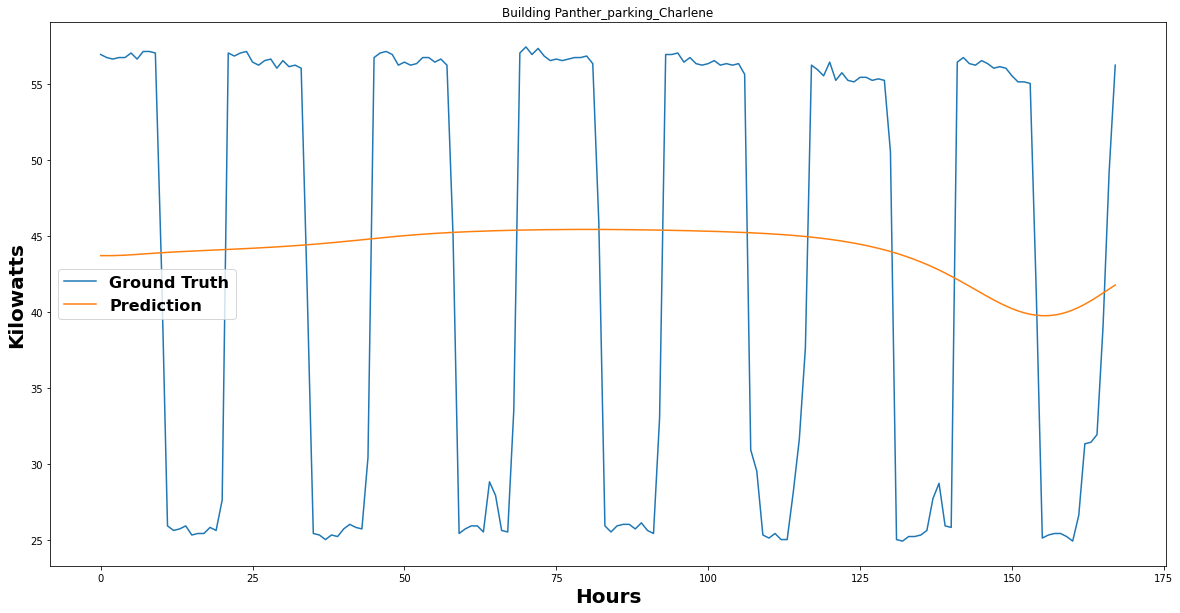

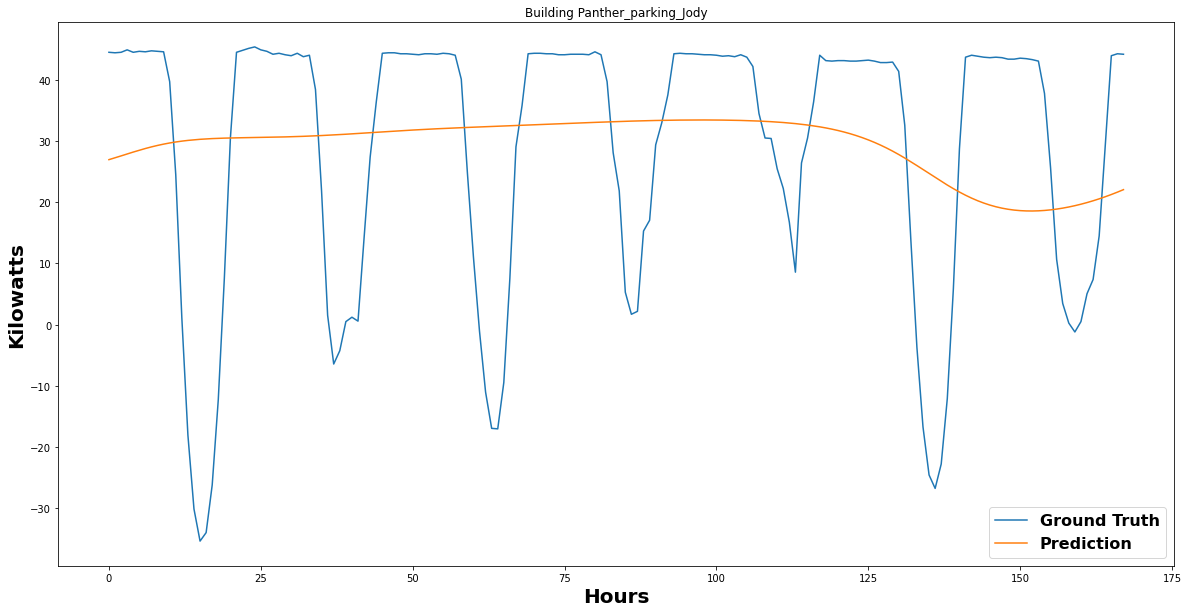

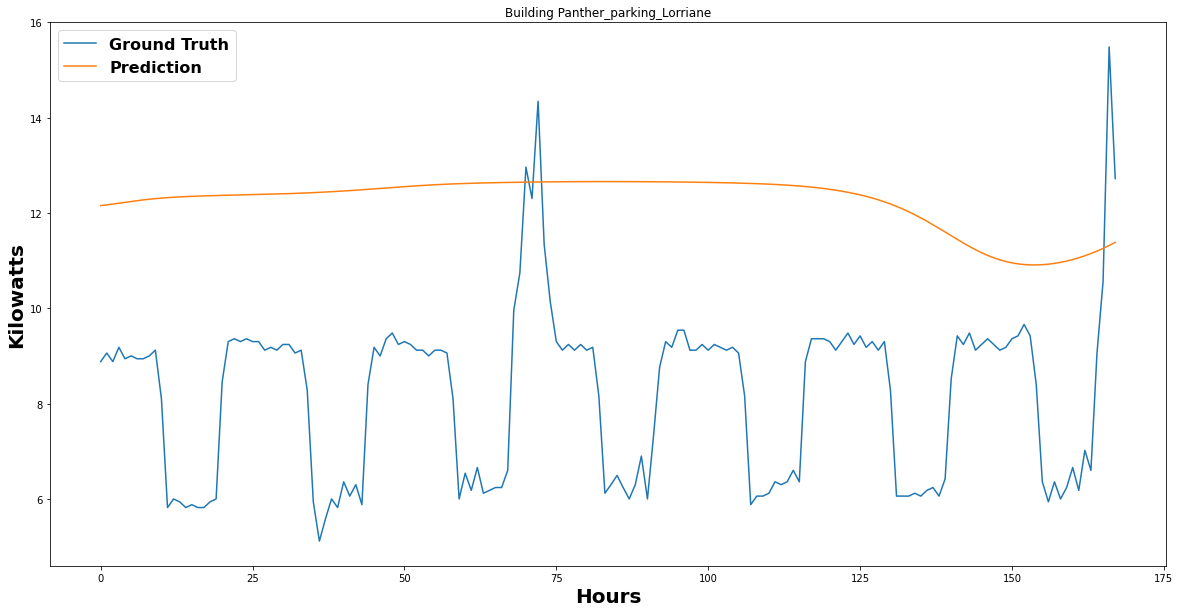

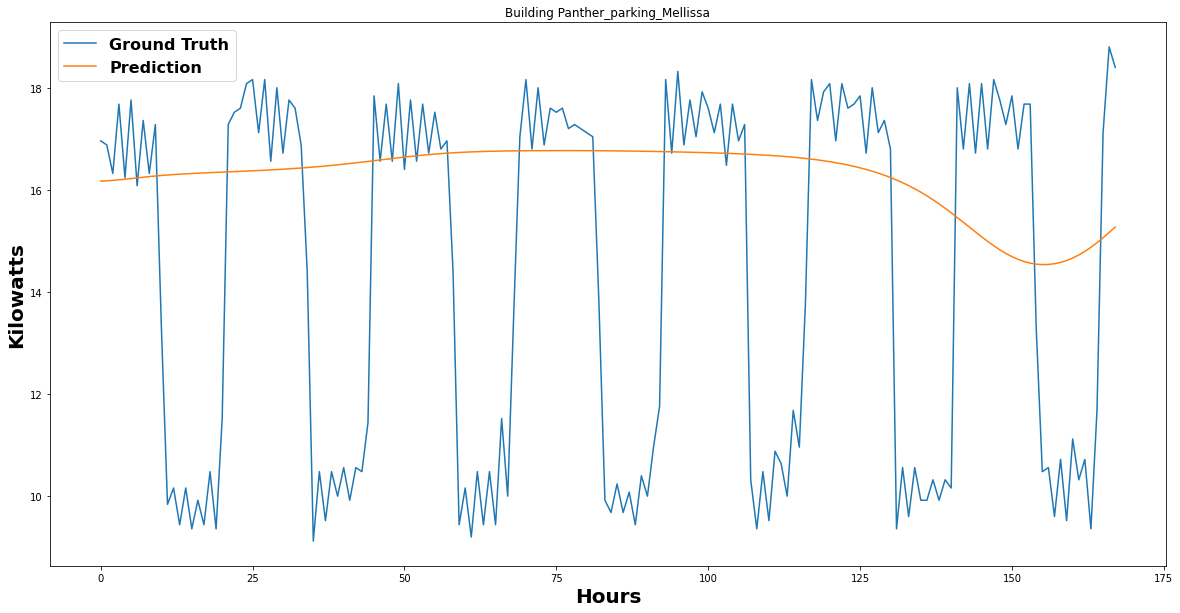

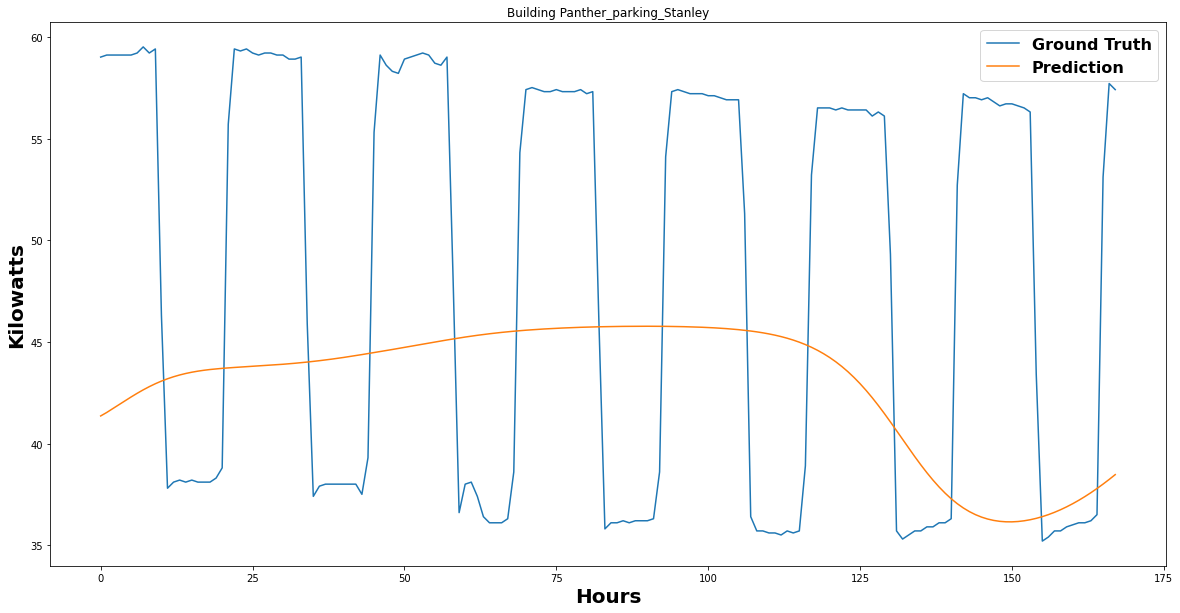

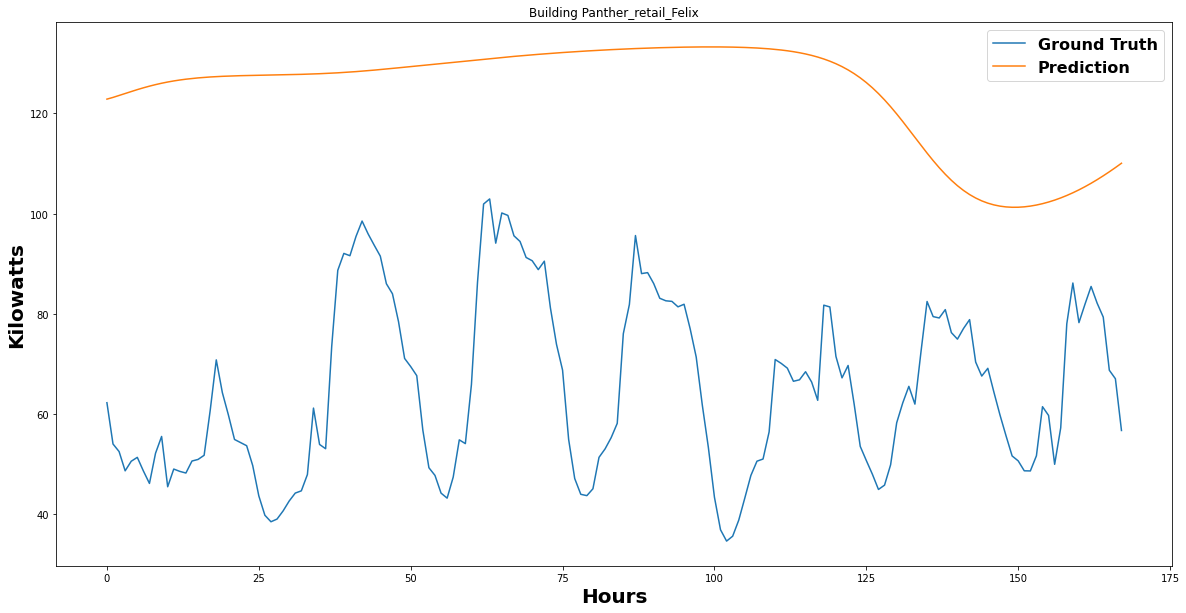

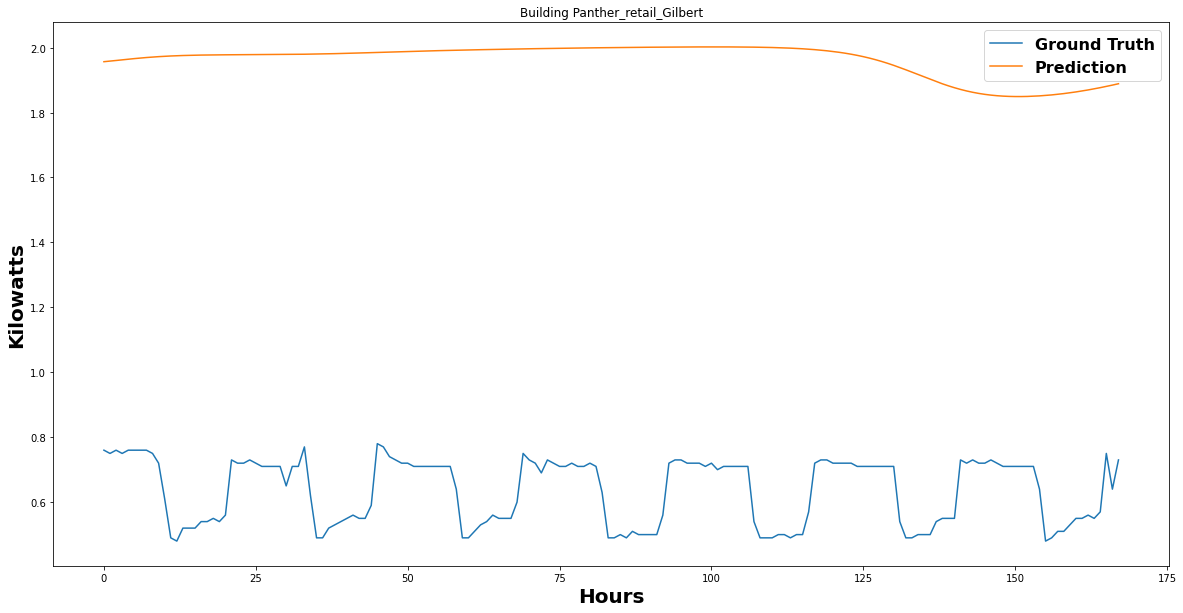

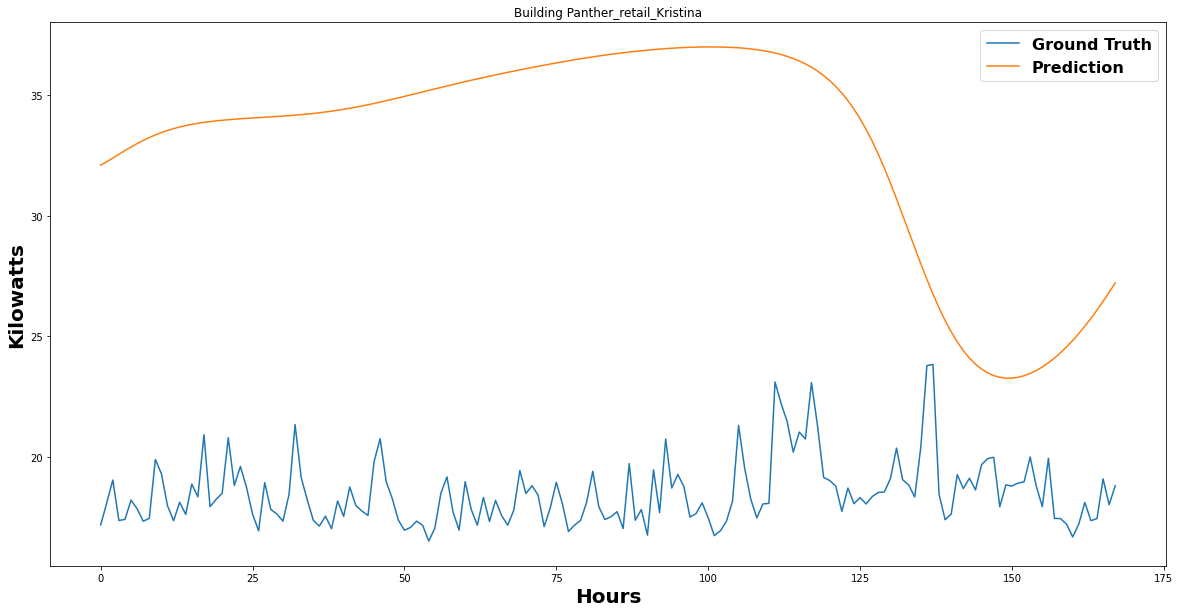

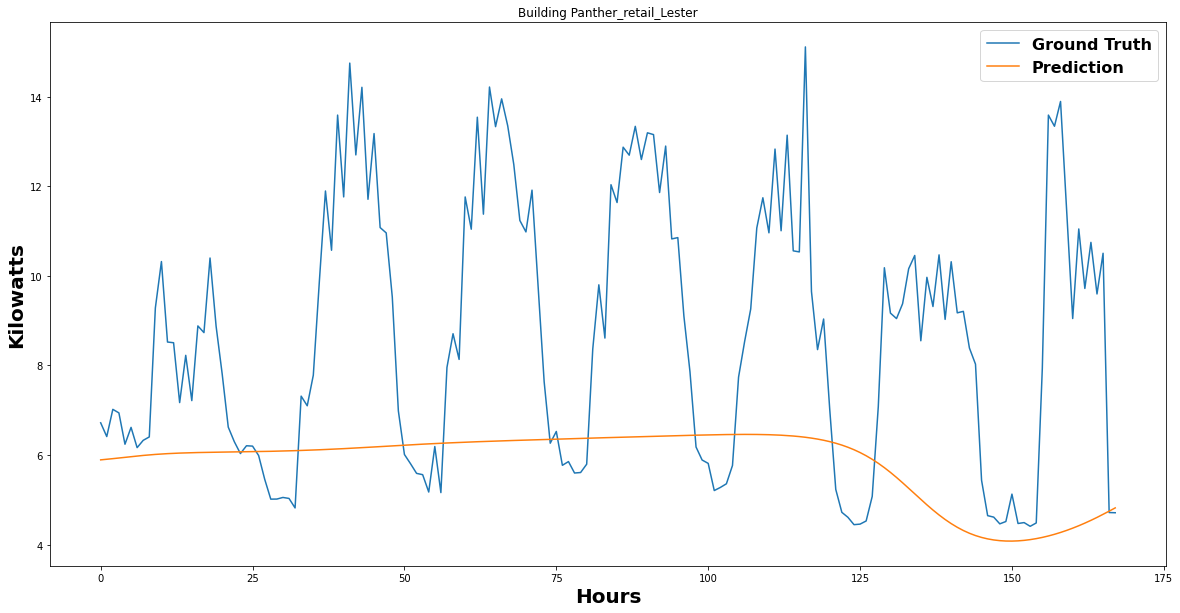

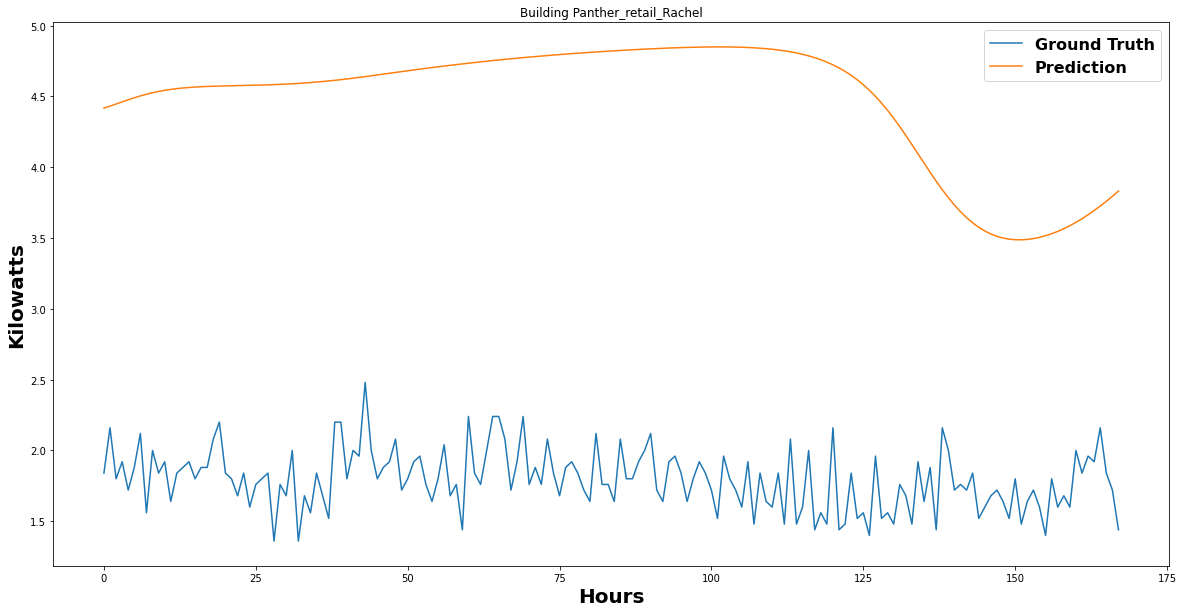

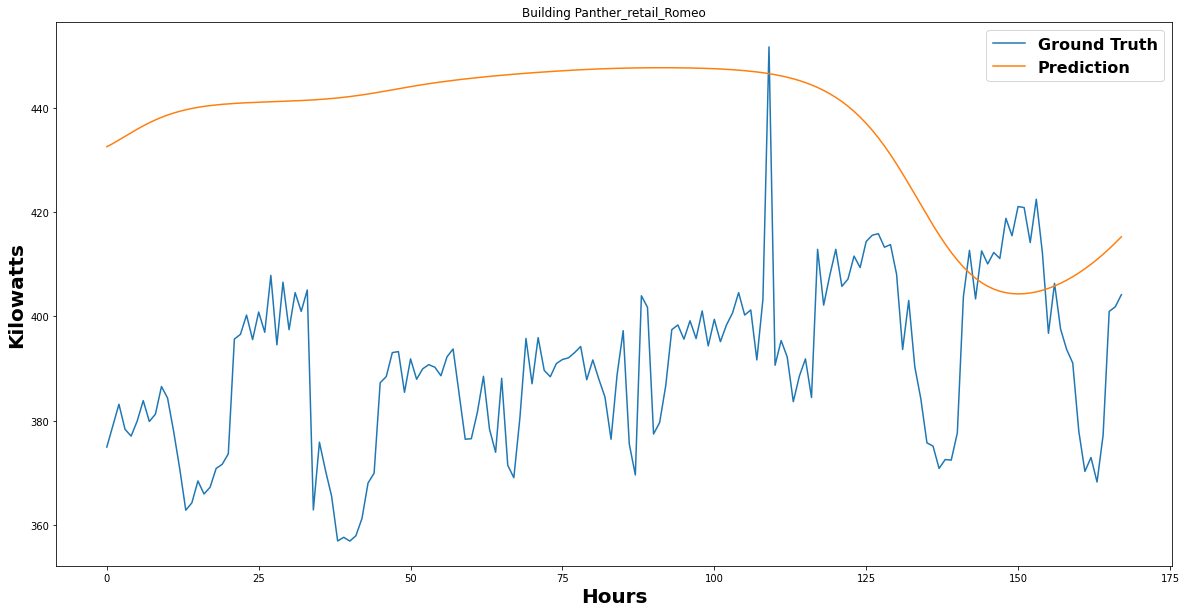

In [ ]:
for i in range(n):
    building = buildings[i]
    legend_properties = {'weight':'bold','size':'16'}
    fig, ax = plt.subplots(figsize = (20,10))
    ax.plot(actuals[i], label = "Ground Truth")
    ax.plot(predictions[i], label = "Prediction")
    ax.set_xlabel('Hours', fontsize=20, fontweight='bold')
    ax.set_ylabel('Kilowatts', fontsize=20, fontweight='bold')
    ax.set_title(f"Building {building}") 
    ax.legend(loc = 0, prop = legend_properties)
    plt.show()